In [1]:
import pandas as pd
import numpy as np

import cognitive_GLVQ as cglvq
import OGLVQ as oglvq
import optimizer as opt

import matplotlib.pyplot as plt

import random
import copy


In [2]:
random.seed(5)

In [3]:
num_prototypes = 3
colors = ["#5171fF", "#fF7151", "#519951"]
img_folder = "images/figs/"
data_name = "ionosphere"

In [4]:
def save_figs(model, experiment, model_name, lr):
    fig1 = model.lr_graph(f"{model_name} Learning Rate")
    fig2 = model.acc_graph(f"{model_name} Accuracy")
    fig3 = model.f1_graph(f"{model_name} F1 Score")
    figs = [fig1, fig2, fig3]
    fig_type = ["lr", "acc", "f1"]
    for i, fig in enumerate(figs):
        fig.savefig(
            f"{img_folder}/{experiment}/{data_name}/{model_name}_{lr}_{fig_type[i]}.png",
            dpi=150,
        )


# Data prep

In [5]:
# Load the data
df = pd.read_csv("dataset/ionosphere/ionosphere_data.csv")

# Shuffle the data
df = df.reset_index(drop=True)

In [6]:
feature = df[df.columns[:-1]]
label = df[df.columns[-1]]

feature = feature.to_numpy()
label = label.to_numpy()
label = label.reshape(-1, 1)

In [7]:
unique, count = np.unique(label, return_counts=True)
sample_number = dict(zip(unique, count))
sample_number

{'b': 126, 'g': 225}

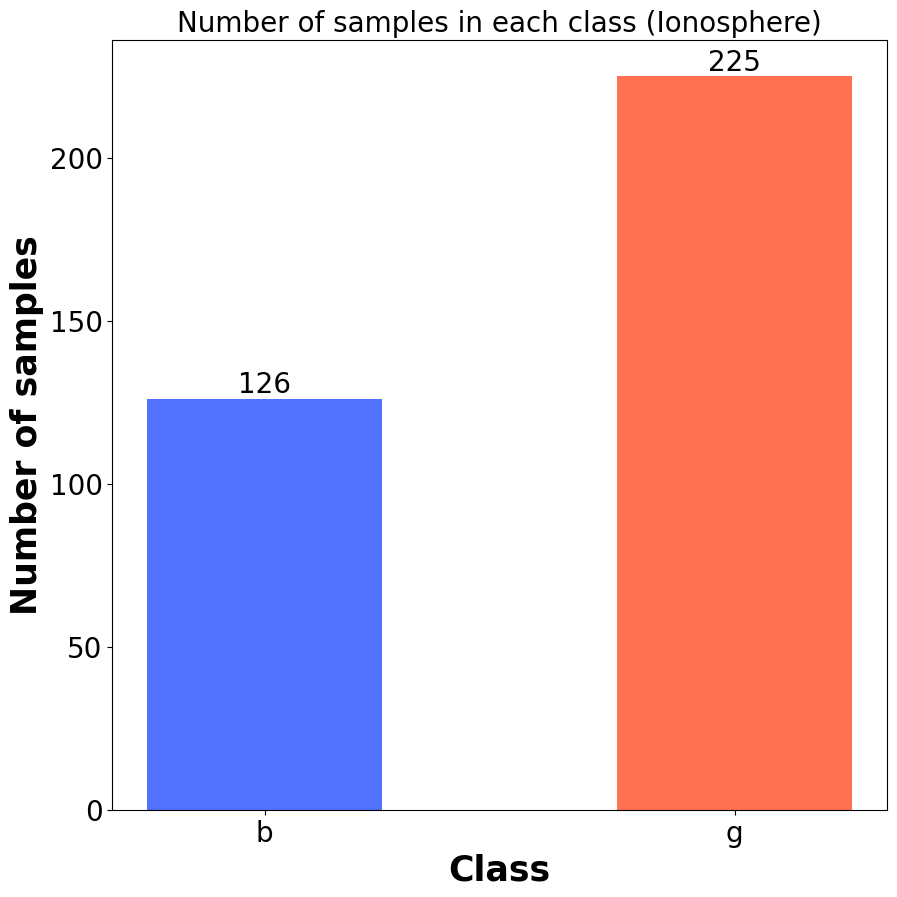

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
for i, (k, v) in enumerate(sample_number.items()):
    ax.bar(k, v, width=0.5, color=colors[i])
    plt.text(k, v + 0.1, str(v), ha="center", va="bottom", fontsize=20)
plt.title("Number of samples in each class (Ionosphere)", fontsize=20)
plt.xlabel("Class", fontsize=25, weight="bold")
plt.ylabel("Number of samples", fontsize=25, weight="bold")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
fig.savefig(img_folder + "sample/" + data_name, dpi=200)


## Select prototypes

In [9]:
prototypes_index = []
for class_name in sample_number:
    index_i = np.where(label == class_name)
    index_i = list(index_i[0])
    prototype_index_i = random.sample(index_i, num_prototypes)
    prototypes_index += prototype_index_i
prototypes_index.sort(reverse=True)
prototypes = [(feature[i], label[i]) for i in prototypes_index]
# Remove prototypes from dataset
feature = np.delete(feature, prototypes_index, axis=0)
label = np.delete(label, prototypes_index, axis=0)


### Accuracy

In [10]:
experiment = "experiment_1"

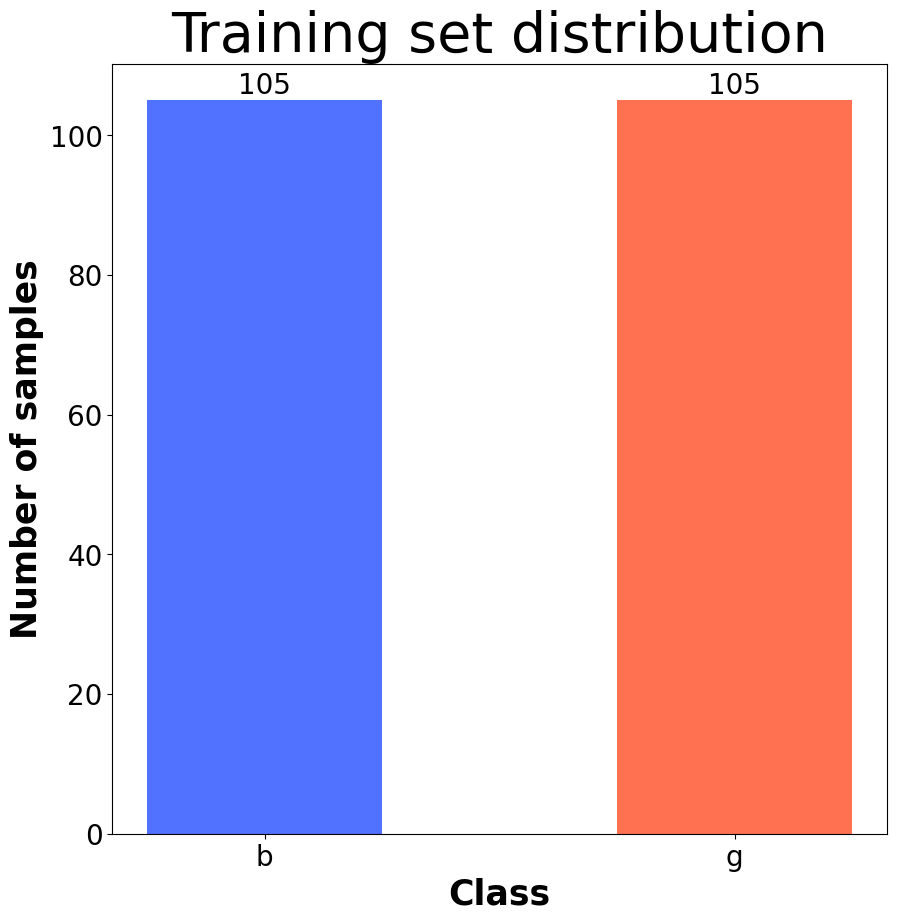

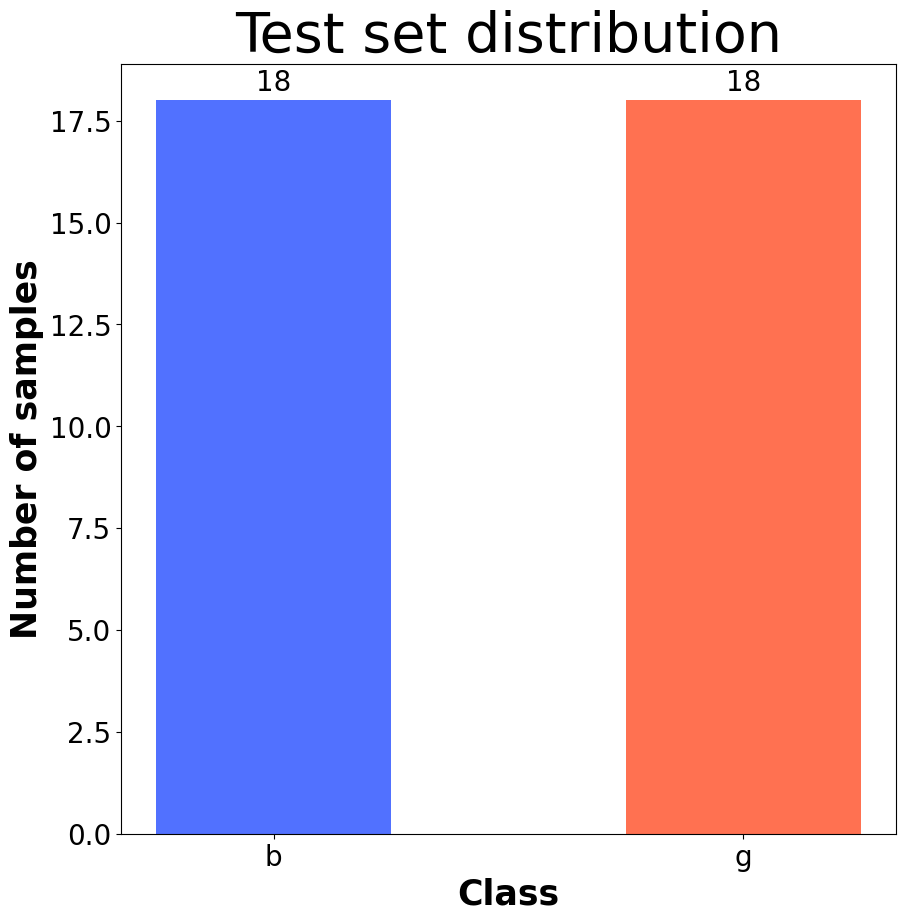

In [11]:
# Select equal amount of normal and abnormal data
data_per_class = min(count) - num_prototypes
test_percentage = 0.15
test_size = int(test_percentage * data_per_class)
train_size = data_per_class - test_size
feature_acc = copy.deepcopy(feature)
label_acc = copy.deepcopy(label)

# Select test set
test_index = []
for class_name in sample_number:
    index_i = np.where(label_acc == class_name)
    index_i = list(index_i[0])
    index_i_sample = random.sample(index_i, test_size)
    test_index += index_i_sample
test_index.sort(reverse=True)
test_set_acc = [(feature_acc[i], label_acc[i]) for i in test_index]
random.shuffle(test_set_acc)
unique, counts = np.unique(label_acc[test_index], return_counts=True)
test_dist = dict(zip(unique, counts))
feature_acc = np.delete(feature_acc, test_index, axis=0)
label_acc = np.delete(label_acc, test_index, axis=0)

# Select train set
train_index = []
for class_name in sample_number:
    index_i = np.where(label_acc == class_name)
    index_i = list(index_i[0])
    index_i_sample = random.sample(index_i, train_size)
    train_index += index_i_sample
train_index.sort(reverse=True)
unique, counts = np.unique(label_acc[train_index], return_counts=True)
train_dist = dict(zip(unique, counts))
train_set_acc = [(feature_acc[i], label_acc[i]) for i in train_index]
random.shuffle(train_set_acc)

fig, ax = plt.subplots(figsize=(10, 10))
for i, (k, v) in enumerate(train_dist.items()):
    ax.bar(k, v, width=0.5, color=colors[i])
    plt.text(k, v + 0.1, str(v), ha="center", va="bottom", fontsize=20)
plt.title("Training set distribution", fontsize=40)
plt.xlabel("Class", fontsize=25, weight="bold")
plt.ylabel("Number of samples", fontsize=25, weight="bold")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
fig.savefig(img_folder + experiment + "/" +
            data_name + "/train_dist.png", dpi=200)

fig, ax = plt.subplots(figsize=(10, 10))
for i, (k, v) in enumerate(test_dist.items()):
    ax.bar(k, v, width=0.5, color=colors[i])
    plt.text(k, v + 0.1, str(v), ha="center", va="bottom", fontsize=20)
plt.title("Test set distribution", fontsize=40)
plt.xlabel("Class", fontsize=25, weight="bold")
plt.ylabel("Number of samples", fontsize=25, weight="bold")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
fig.savefig(img_folder + experiment + "/" +
            data_name + "/test_dist.png", dpi=200)


#### Train the Models

In [12]:
num_epochs = 100


##### GLVQ

##### 1-step lr =0.1

In [13]:
learning_rate = 0.1
oglvq_acc = oglvq.OGLVQ(prototypes, learning_rate)
hist = oglvq_acc.train(
    num_epochs, train_set_acc, test_set_acc, sample_number=train_dist
)

Epoch: 1, Loss: 92.4067, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 11, Loss: 89.2510, Accuracy: 77.78 %, F_1_score: 77.71 %
Epoch: 21, Loss: 88.3751, Accuracy: 80.56 %, F_1_score: 80.17 %
Epoch: 31, Loss: 87.5707, Accuracy: 83.33 %, F_1_score: 82.86 %
Epoch: 41, Loss: 86.9462, Accuracy: 83.33 %, F_1_score: 82.86 %
Epoch: 51, Loss: 86.5094, Accuracy: 86.11 %, F_1_score: 85.84 %
Epoch: 61, Loss: 86.2015, Accuracy: 86.11 %, F_1_score: 85.84 %
Epoch: 71, Loss: 85.9903, Accuracy: 86.11 %, F_1_score: 85.84 %
Epoch: 81, Loss: 85.8516, Accuracy: 86.11 %, F_1_score: 85.84 %
Epoch: 91, Loss: 85.7556, Accuracy: 86.11 %, F_1_score: 85.84 %


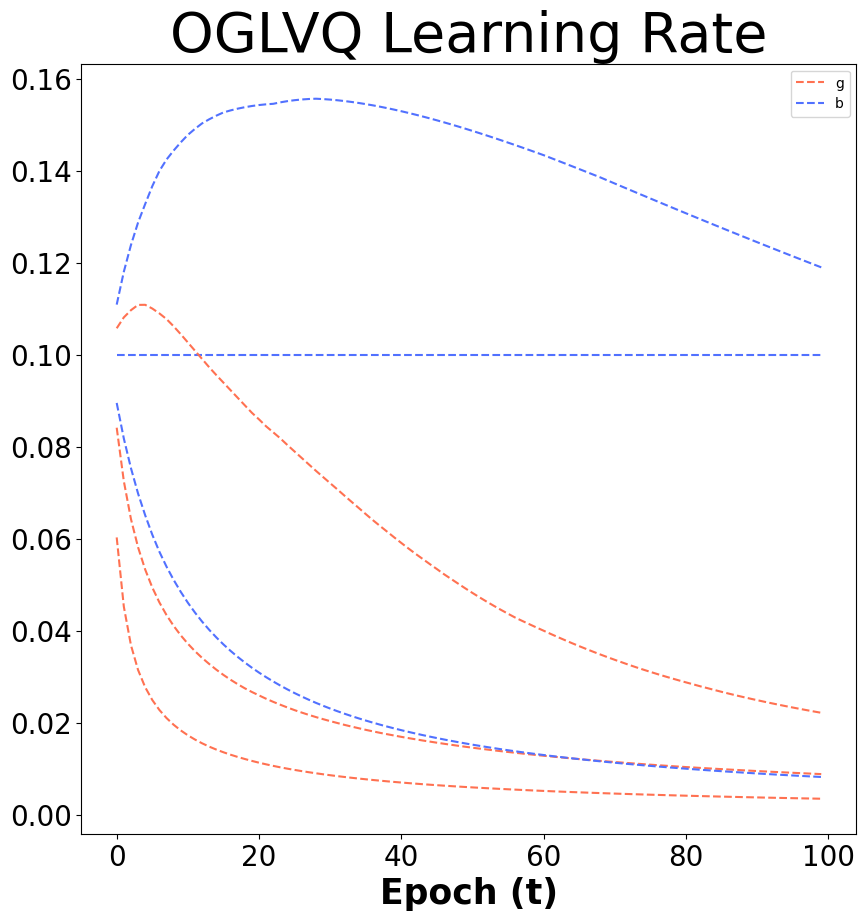

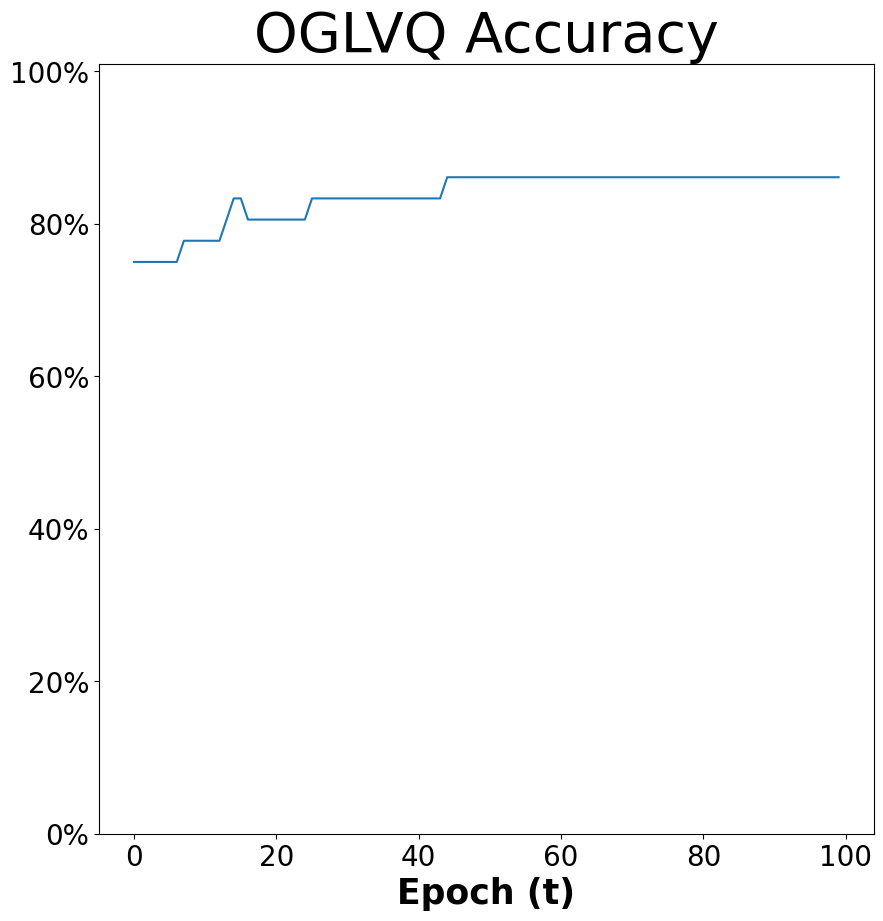

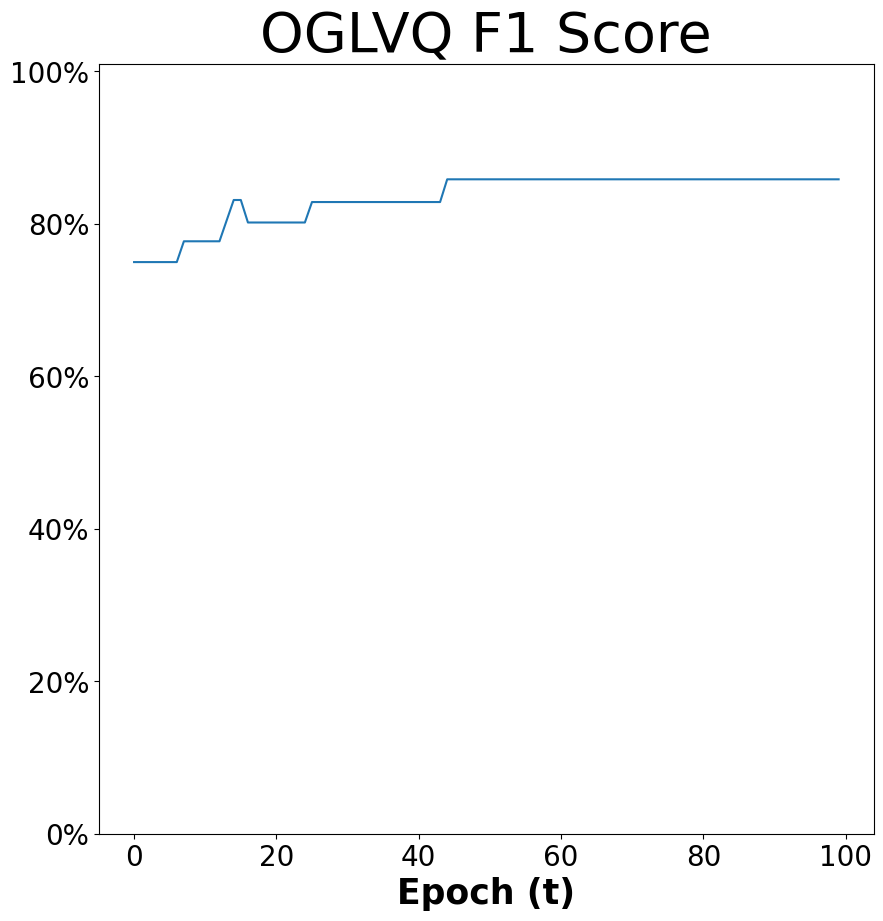

In [14]:
save_figs(oglvq_acc, experiment, "OGLVQ", learning_rate)

##### 2-step lr = 0.03

In [15]:
learning_rate = 0.03
oglvq_acc = oglvq.OGLVQ(
    prototypes,
    learning_rate,
)
hist = oglvq_acc.train(
    num_epochs, train_set_acc, test_set_acc, sample_number=train_dist
)

Epoch: 1, Loss: 92.9369, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 11, Loss: 90.5168, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 21, Loss: 89.7905, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 31, Loss: 89.3695, Accuracy: 77.78 %, F_1_score: 77.71 %
Epoch: 41, Loss: 89.0608, Accuracy: 77.78 %, F_1_score: 77.71 %
Epoch: 51, Loss: 88.8023, Accuracy: 83.33 %, F_1_score: 83.12 %
Epoch: 61, Loss: 88.5486, Accuracy: 80.56 %, F_1_score: 80.17 %
Epoch: 71, Loss: 88.3124, Accuracy: 80.56 %, F_1_score: 80.17 %
Epoch: 81, Loss: 88.0726, Accuracy: 80.56 %, F_1_score: 80.17 %
Epoch: 91, Loss: 87.8278, Accuracy: 83.33 %, F_1_score: 82.86 %


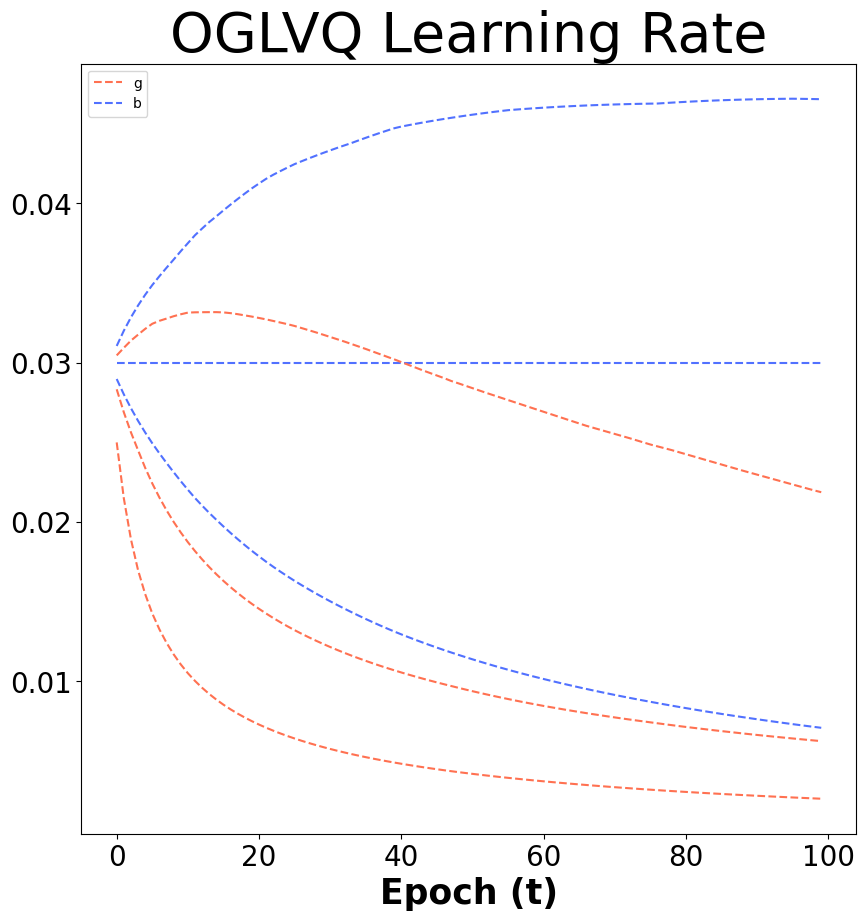

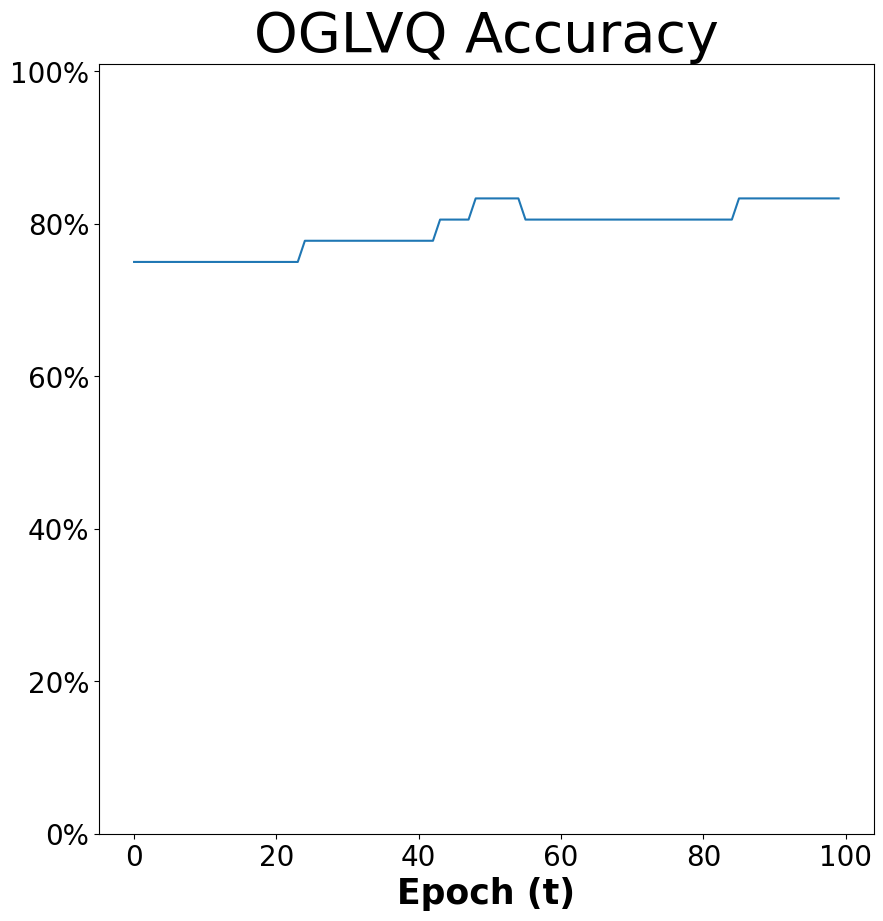

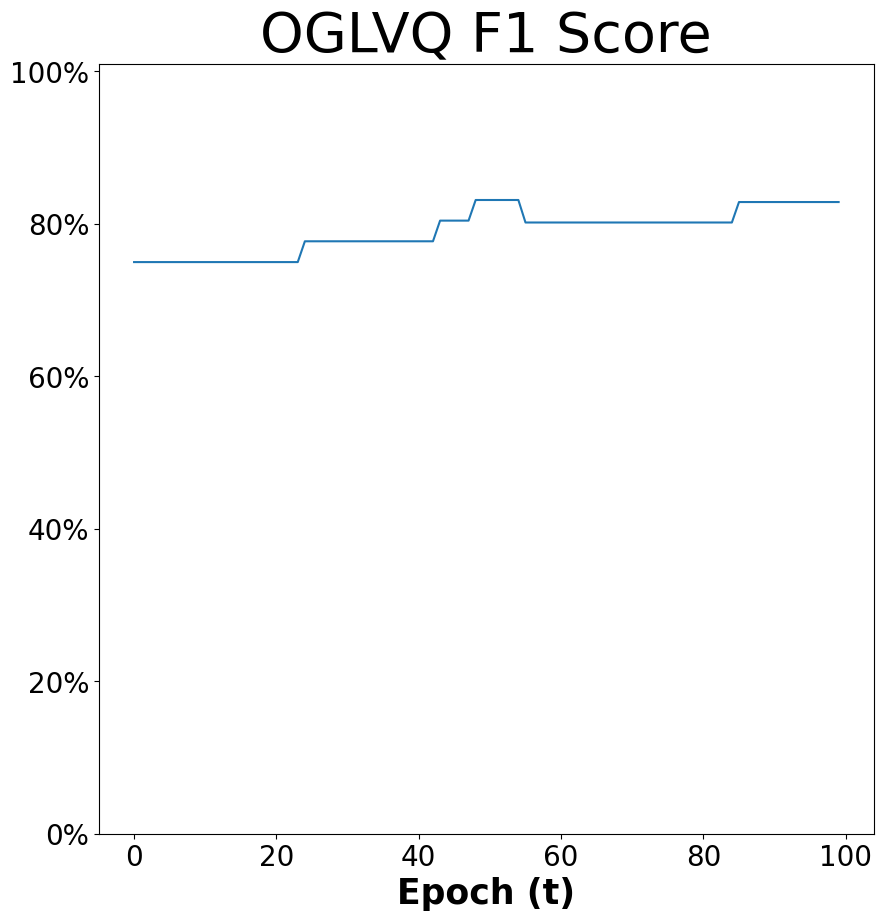

In [16]:
save_figs(oglvq_acc, experiment, "OGLVQ", learning_rate)

##### 3-step lr = 0.01

In [17]:
learning_rate = 0.01
oglvq_acc = oglvq.OGLVQ(prototypes, learning_rate)
hist = oglvq_acc.train(
    num_epochs, train_set_acc, test_set_acc, sample_number=train_dist
)

Epoch: 1, Loss: 93.1287, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 11, Loss: 91.6396, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 21, Loss: 90.9602, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 31, Loss: 90.5428, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 41, Loss: 90.2346, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 51, Loss: 89.9958, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 61, Loss: 89.8006, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 71, Loss: 89.6354, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 81, Loss: 89.4942, Accuracy: 77.78 %, F_1_score: 77.71 %
Epoch: 91, Loss: 89.3743, Accuracy: 77.78 %, F_1_score: 77.71 %


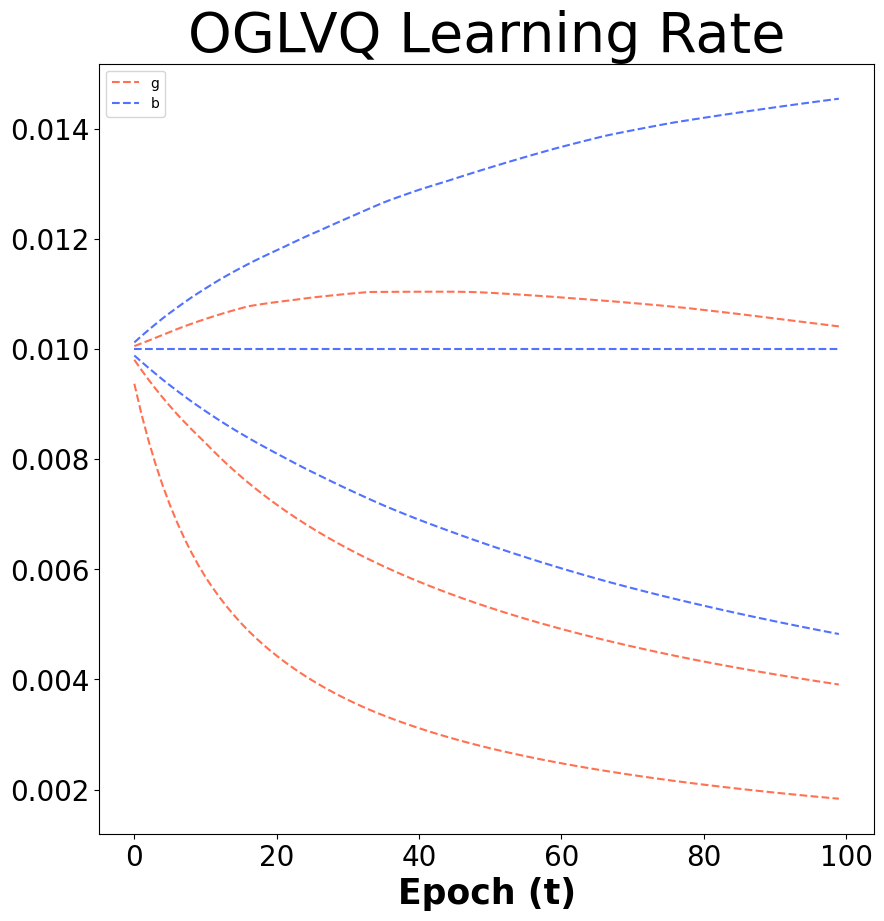

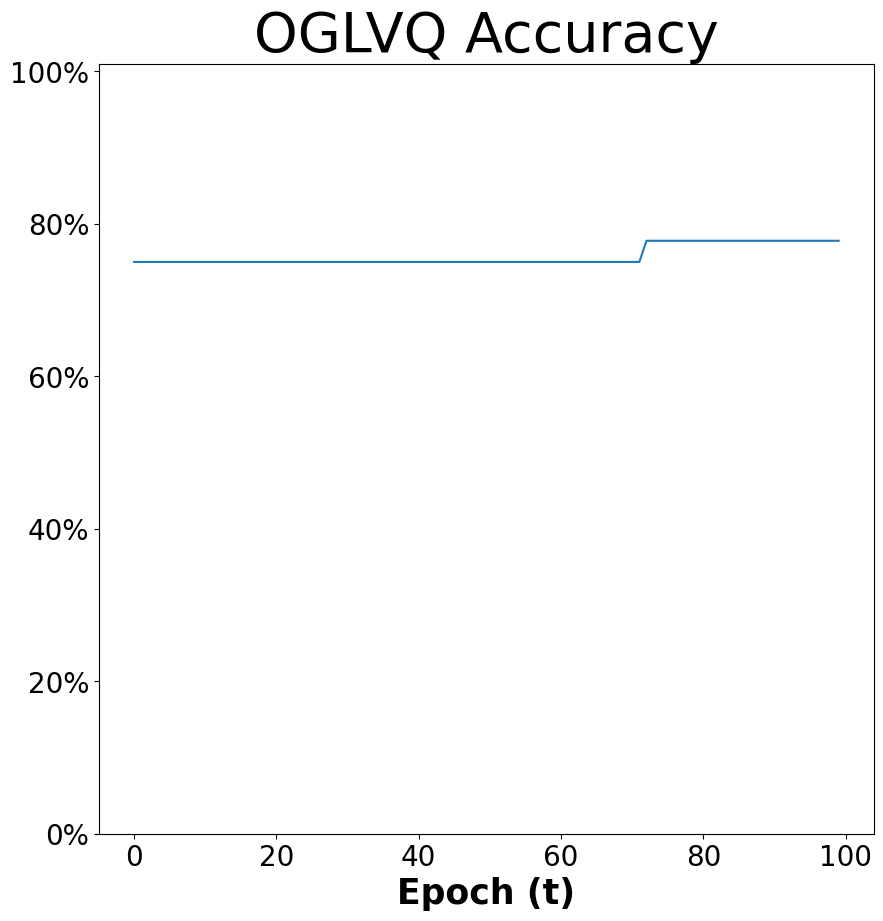

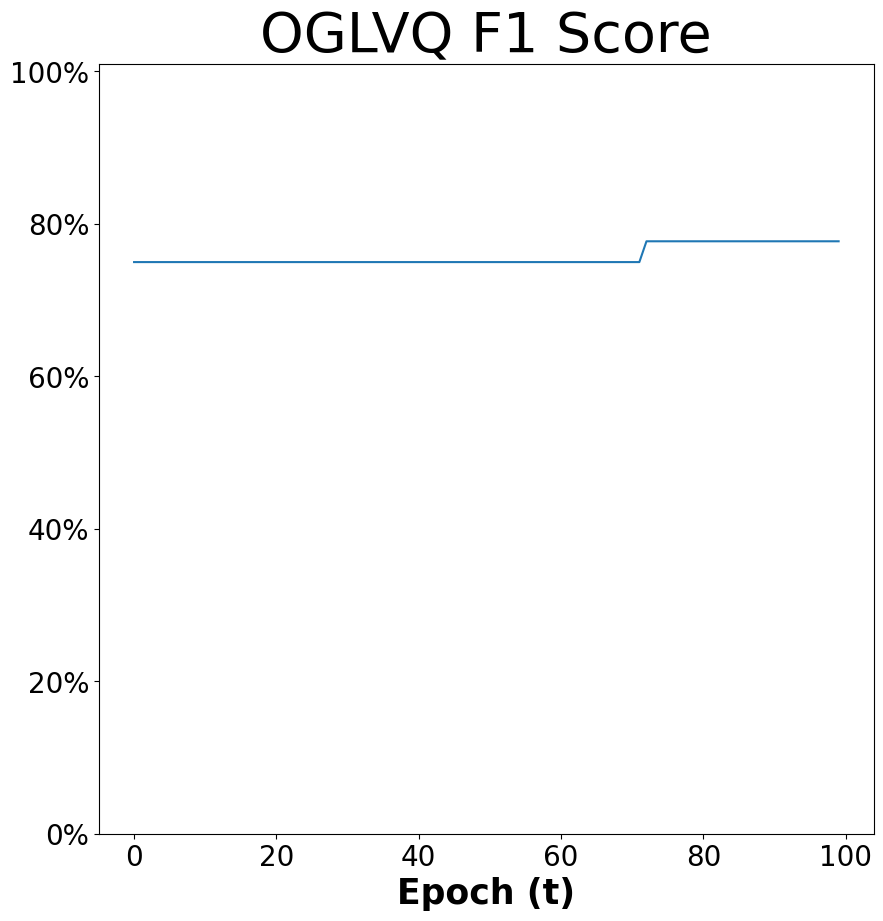

In [18]:
save_figs(oglvq_acc, experiment, "OGLVQ", learning_rate)

##### CP

##### 1-step lr = 0.1

In [19]:
learning_rate = 0.1
cp_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = cp_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.conditional_probability,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4425, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 11, Loss: 0.4307, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 21, Loss: 0.4275, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 31, Loss: 0.4253, Accuracy: 77.78 %, F_1_score: 77.71 %
Epoch: 41, Loss: 0.4238, Accuracy: 80.56 %, F_1_score: 80.17 %
Epoch: 51, Loss: 0.4230, Accuracy: 80.56 %, F_1_score: 80.17 %
Epoch: 61, Loss: 0.4241, Accuracy: 83.33 %, F_1_score: 82.86 %
Epoch: 71, Loss: 0.4280, Accuracy: 75.00 %, F_1_score: 73.33 %
Epoch: 81, Loss: 0.4332, Accuracy: 63.89 %, F_1_score: 58.47 %
Epoch: 91, Loss: 0.4362, Accuracy: 55.56 %, F_1_score: 44.62 %


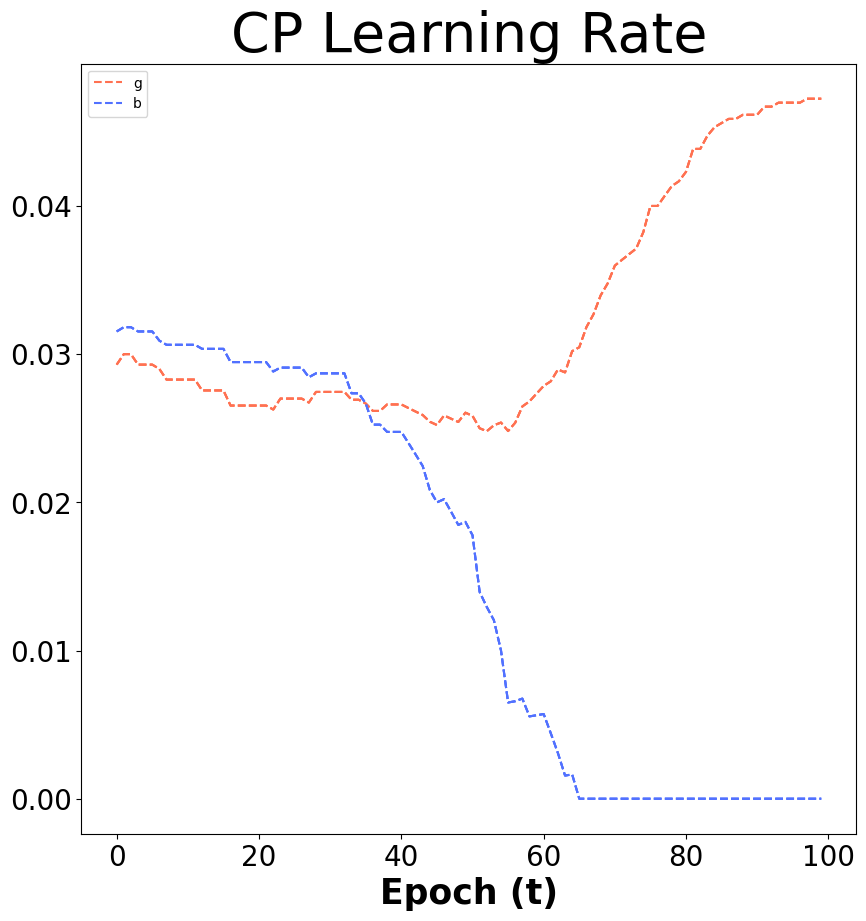

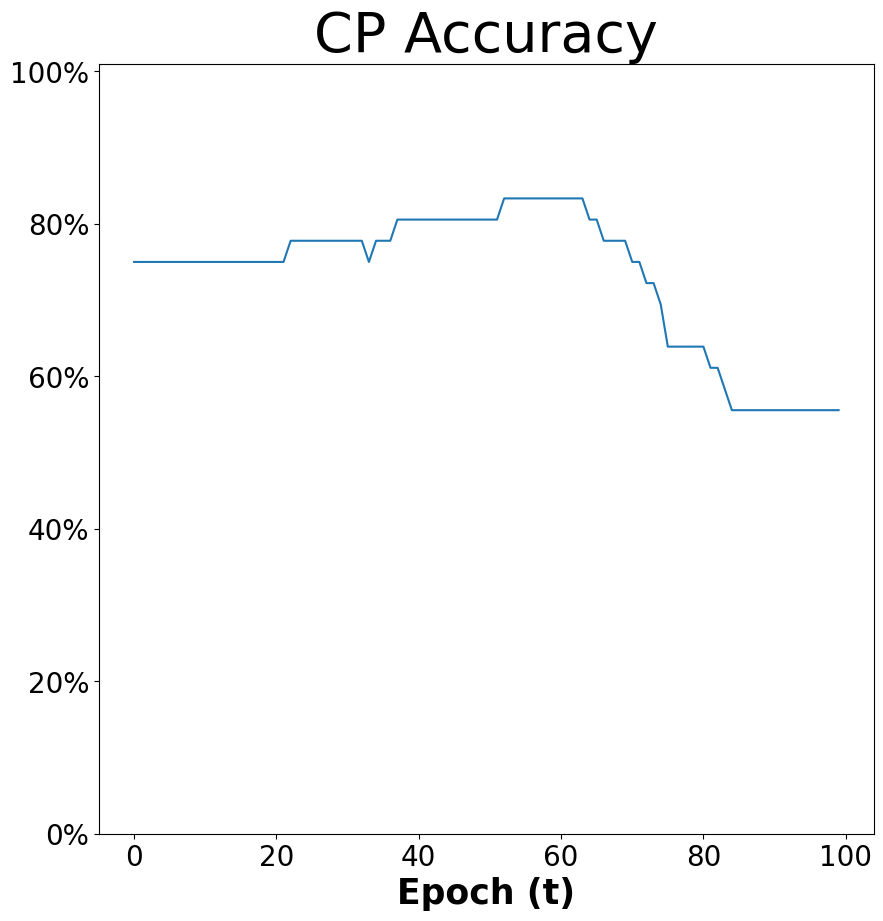

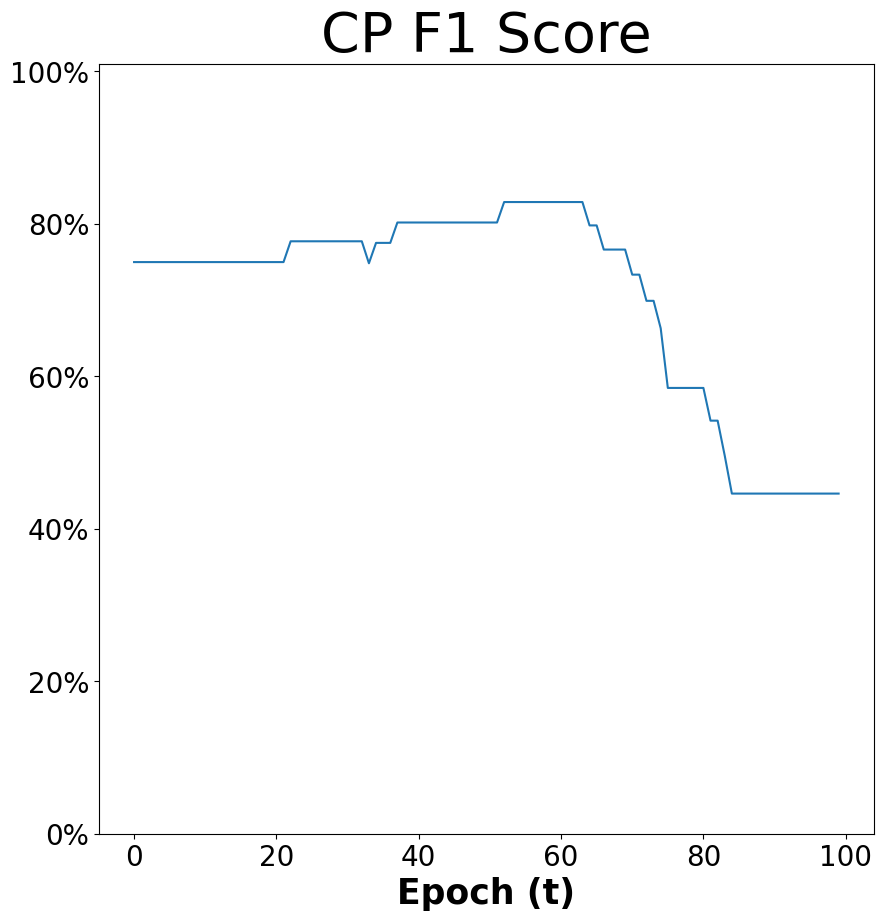

In [20]:
save_figs(cp_glvq_acc, experiment, "CP", learning_rate)

##### 2-step lr = 0.03

In [21]:
learning_rate = 0.03
cp_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = cp_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.conditional_probability,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4435, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 11, Loss: 0.4363, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 21, Loss: 0.4331, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 31, Loss: 0.4313, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 41, Loss: 0.4299, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 51, Loss: 0.4289, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 61, Loss: 0.4280, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 71, Loss: 0.4273, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 81, Loss: 0.4266, Accuracy: 77.78 %, F_1_score: 77.71 %
Epoch: 91, Loss: 0.4259, Accuracy: 77.78 %, F_1_score: 77.71 %


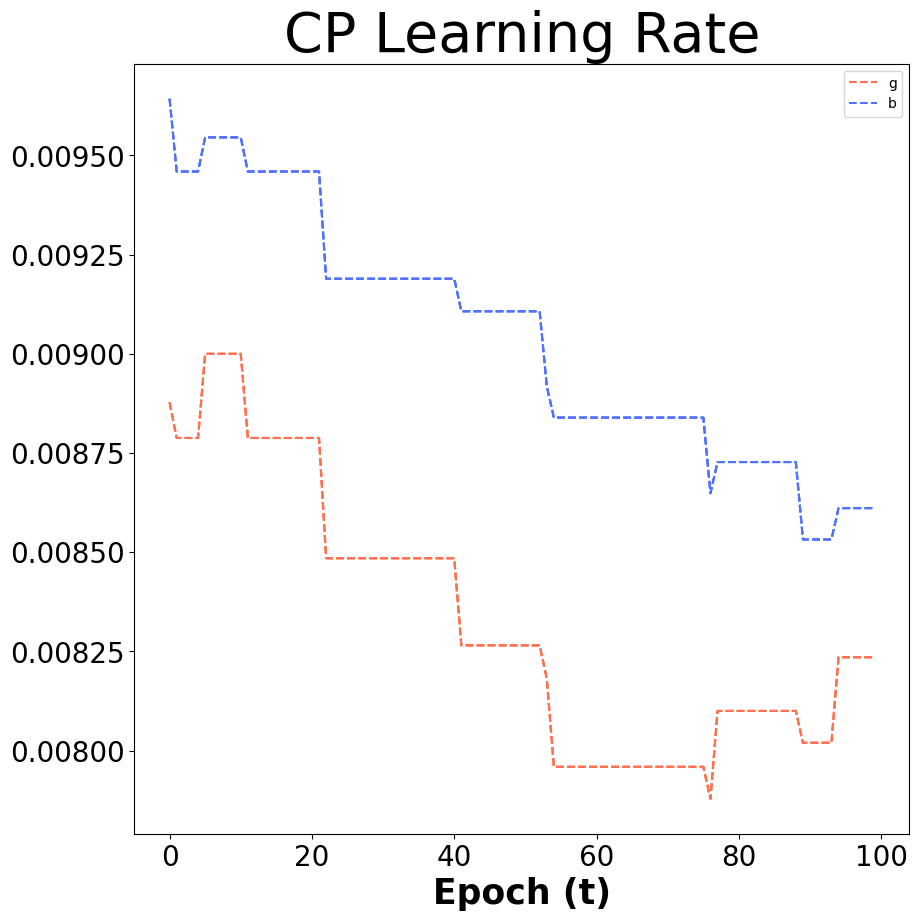

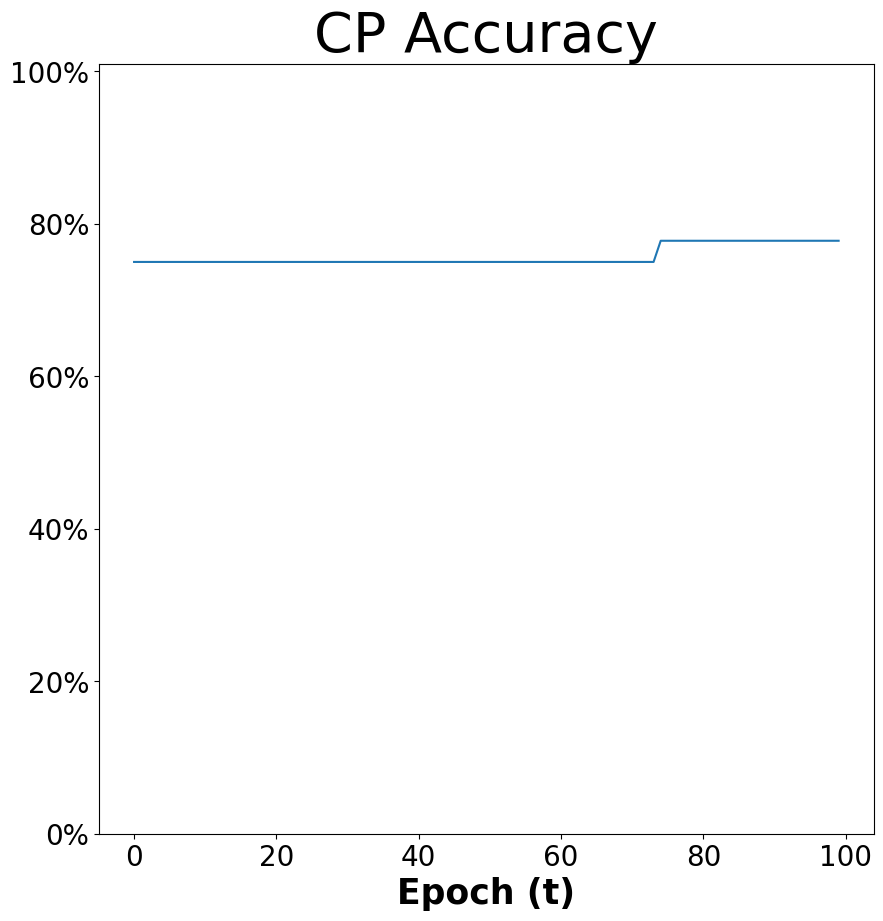

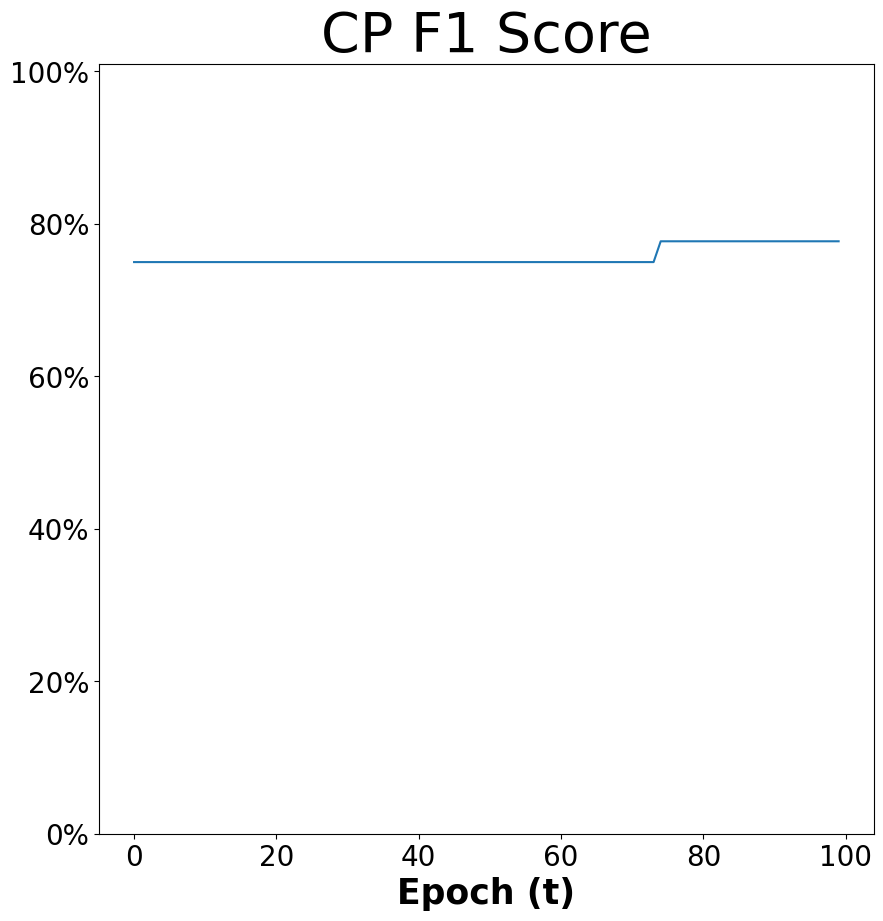

In [22]:
save_figs(cp_glvq_acc, experiment, "CP", learning_rate)

##### 3-step lr = 0.01

In [23]:
learning_rate = 0.01
cp_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = cp_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.conditional_probability,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4438, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 11, Loss: 0.4407, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 21, Loss: 0.4383, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 31, Loss: 0.4364, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 41, Loss: 0.4350, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 51, Loss: 0.4340, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 61, Loss: 0.4332, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 71, Loss: 0.4325, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 81, Loss: 0.4319, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 91, Loss: 0.4313, Accuracy: 75.00 %, F_1_score: 74.98 %


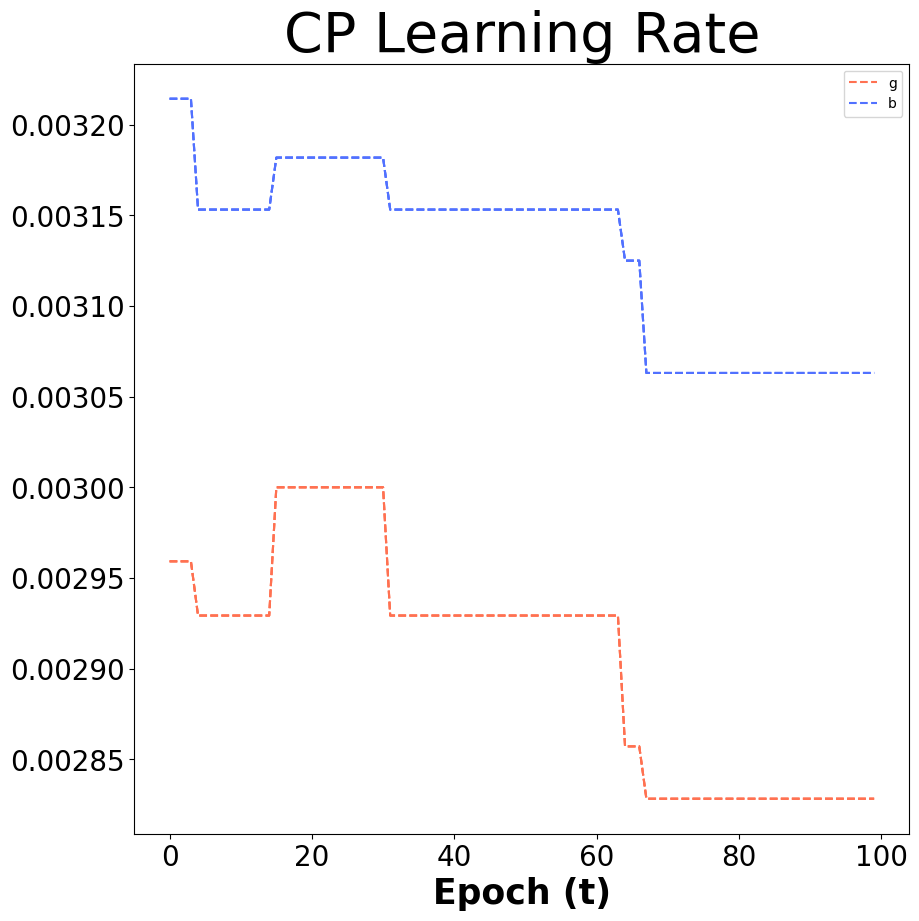

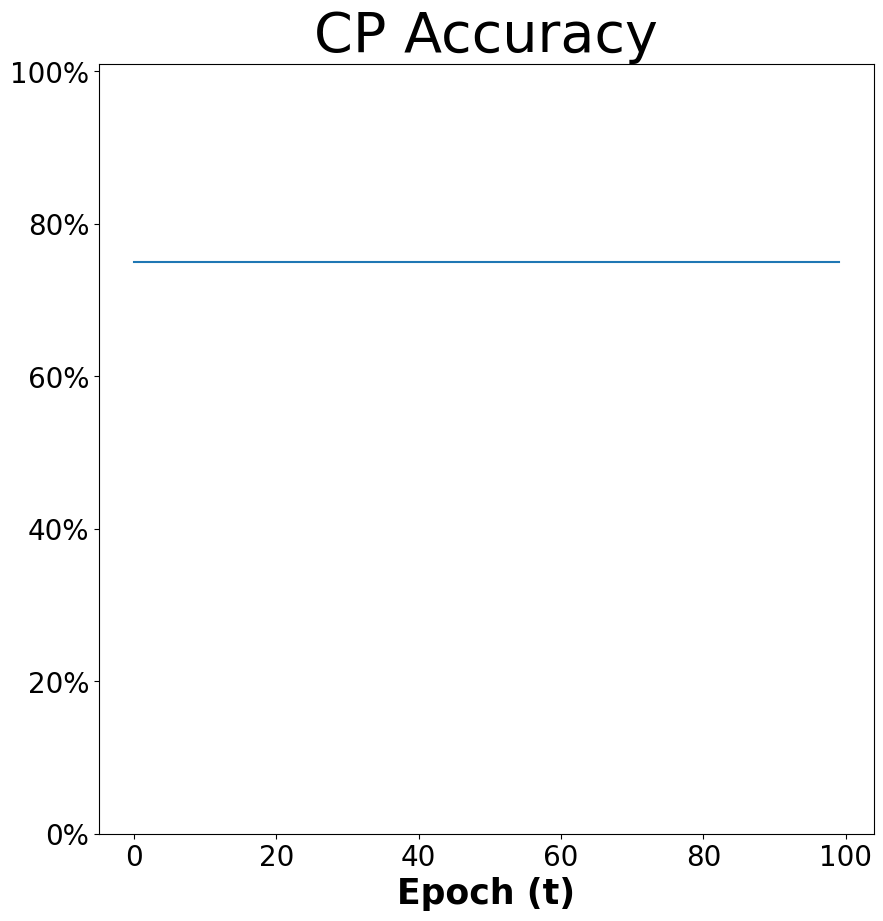

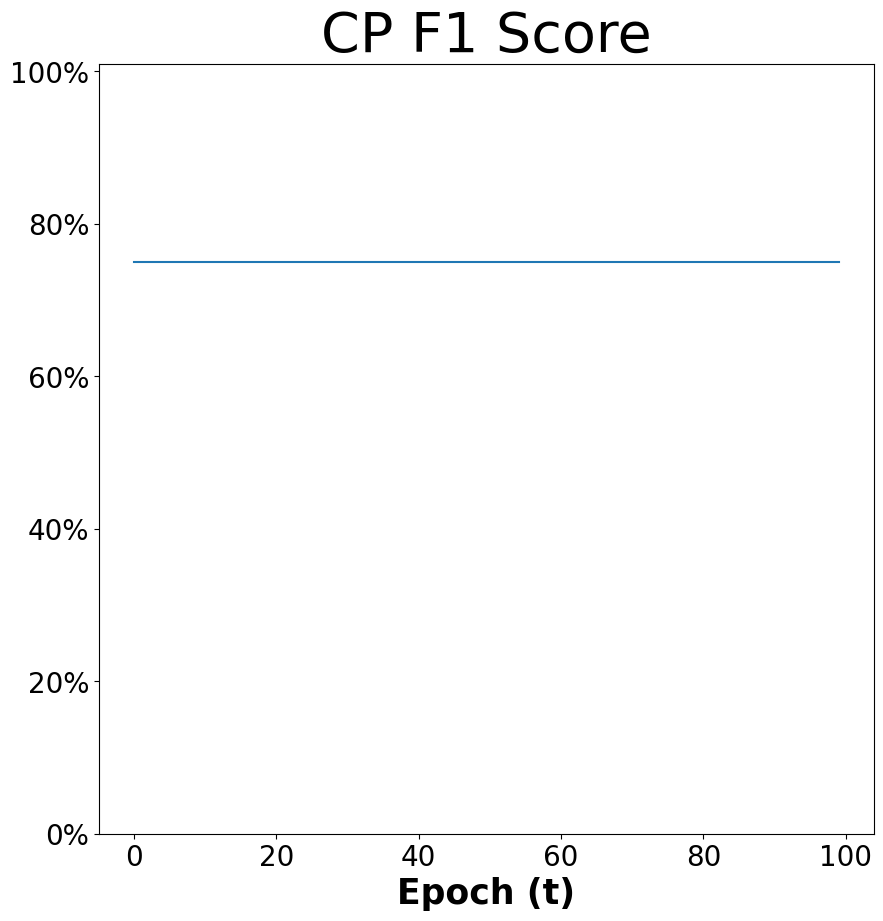

In [24]:
save_figs(cp_glvq_acc, experiment, "CP", learning_rate)

##### DFH

##### 1-step lr = 0.1

In [25]:
learning_rate = 0.1
dfh_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = dfh_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.dual_factor_heuristic,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4418, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 11, Loss: 0.4286, Accuracy: 77.78 %, F_1_score: 77.71 %
Epoch: 21, Loss: 0.4250, Accuracy: 80.56 %, F_1_score: 80.17 %
Epoch: 31, Loss: 0.4230, Accuracy: 80.56 %, F_1_score: 80.17 %
Epoch: 41, Loss: 0.4213, Accuracy: 80.56 %, F_1_score: 80.17 %
Epoch: 51, Loss: 0.4197, Accuracy: 83.33 %, F_1_score: 82.86 %
Epoch: 61, Loss: 0.4181, Accuracy: 83.33 %, F_1_score: 82.86 %
Epoch: 71, Loss: 0.4165, Accuracy: 83.33 %, F_1_score: 82.86 %
Epoch: 81, Loss: 0.4150, Accuracy: 83.33 %, F_1_score: 82.86 %
Epoch: 91, Loss: 0.4136, Accuracy: 83.33 %, F_1_score: 82.86 %


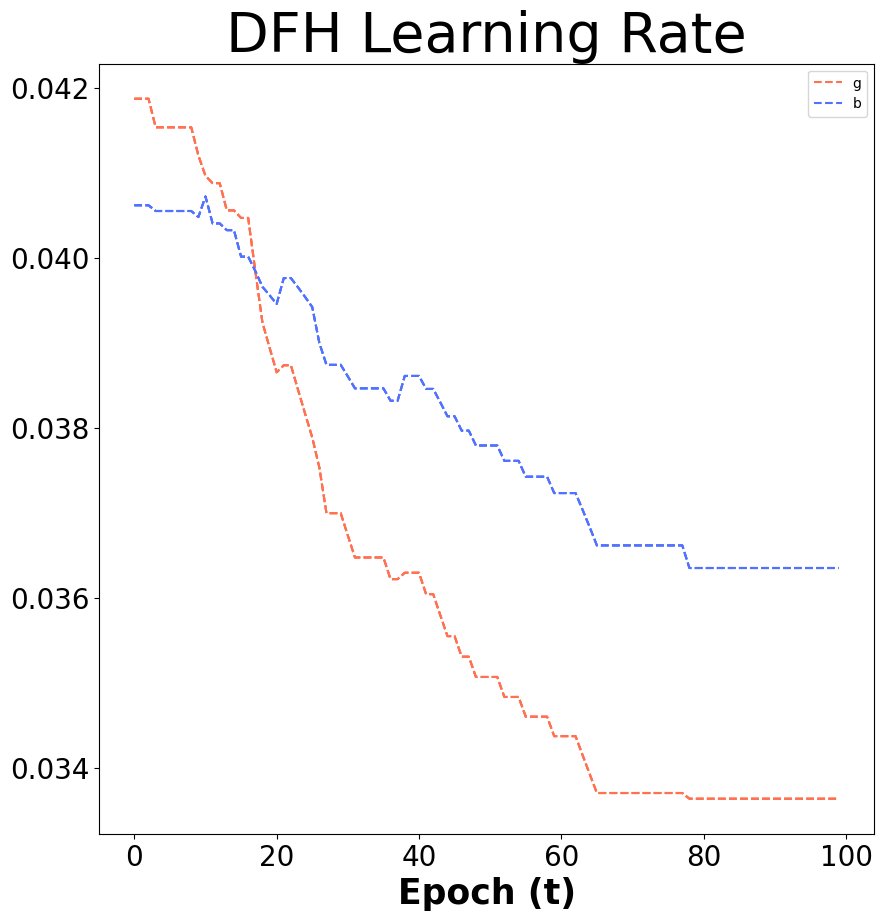

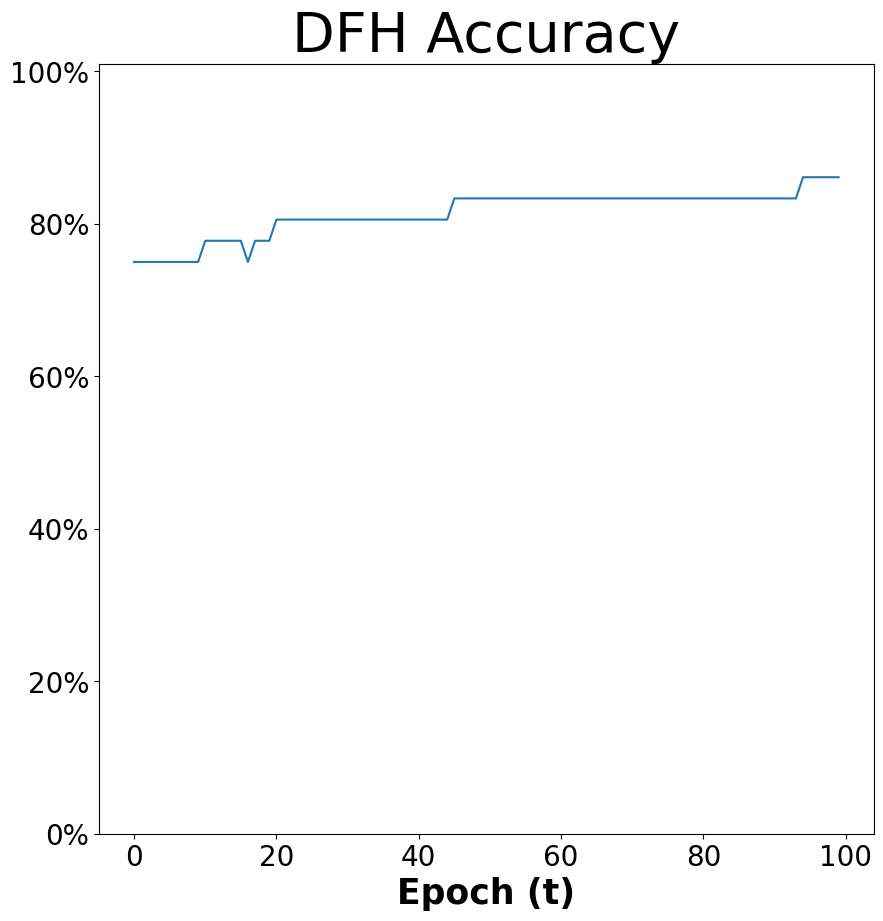

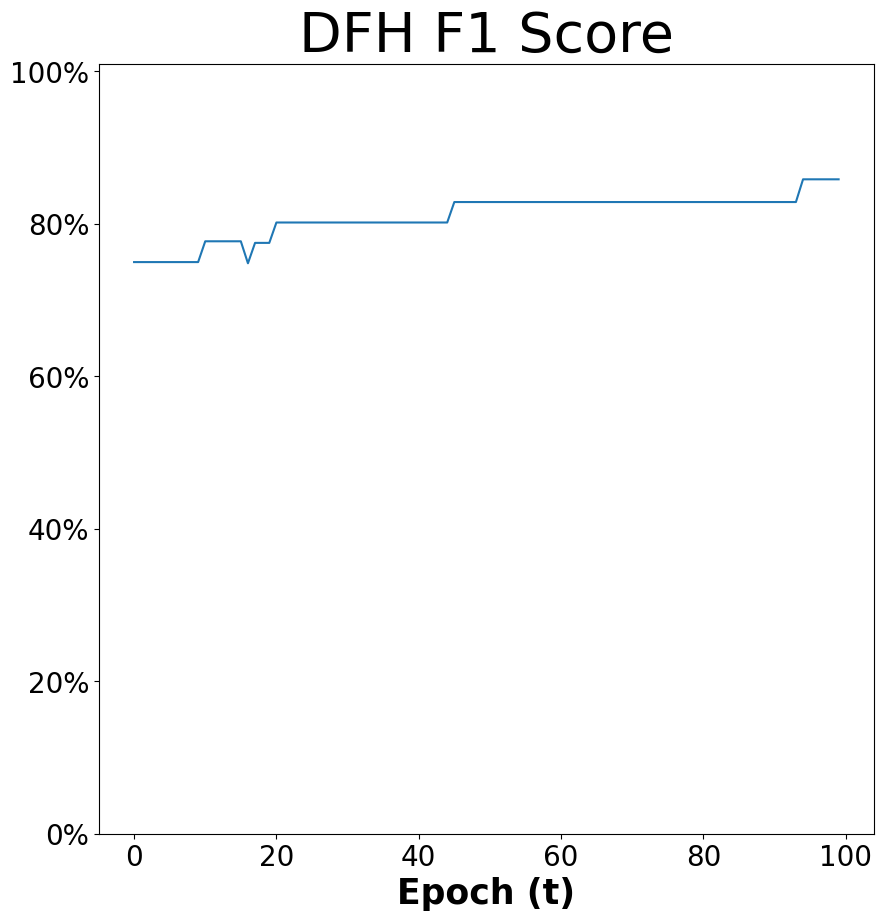

In [26]:
save_figs(dfh_glvq_acc, experiment, "DFH", learning_rate)

##### 2-step lr = 0.03

In [27]:
learning_rate = 0.03
dfh_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = dfh_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.dual_factor_heuristic,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4433, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 11, Loss: 0.4345, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 21, Loss: 0.4313, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 31, Loss: 0.4292, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 41, Loss: 0.4277, Accuracy: 77.78 %, F_1_score: 77.71 %
Epoch: 51, Loss: 0.4265, Accuracy: 77.78 %, F_1_score: 77.71 %
Epoch: 61, Loss: 0.4255, Accuracy: 77.78 %, F_1_score: 77.50 %
Epoch: 71, Loss: 0.4248, Accuracy: 80.56 %, F_1_score: 80.17 %
Epoch: 81, Loss: 0.4241, Accuracy: 80.56 %, F_1_score: 80.17 %
Epoch: 91, Loss: 0.4235, Accuracy: 80.56 %, F_1_score: 80.17 %


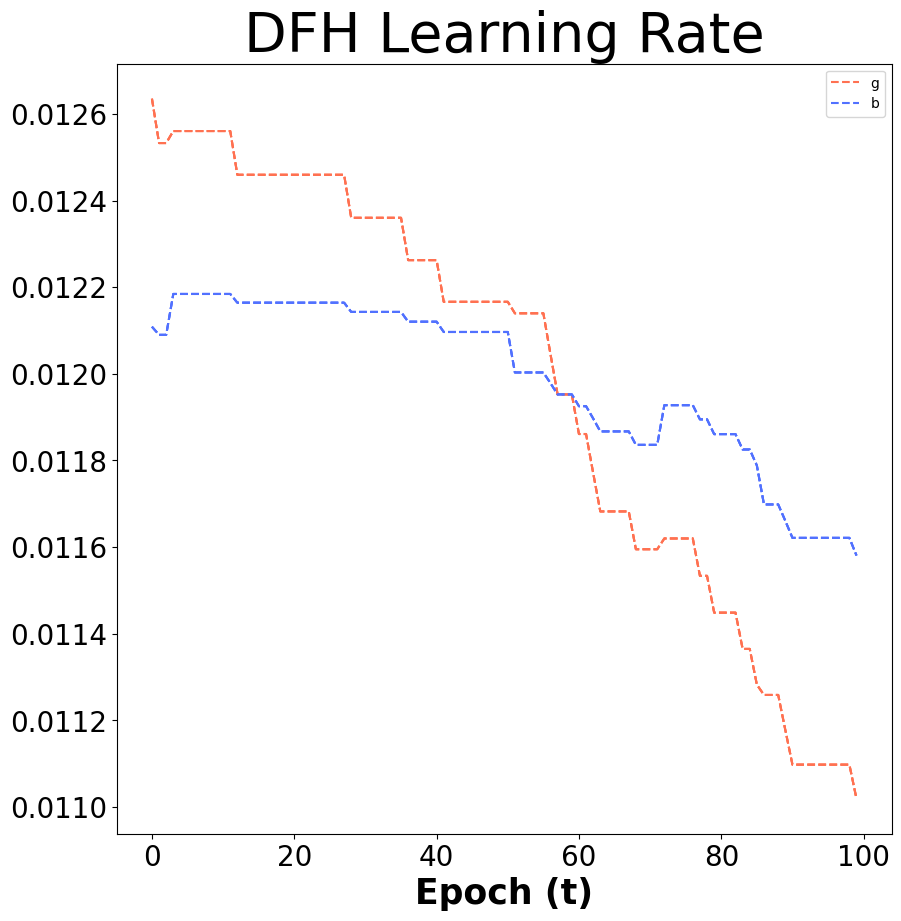

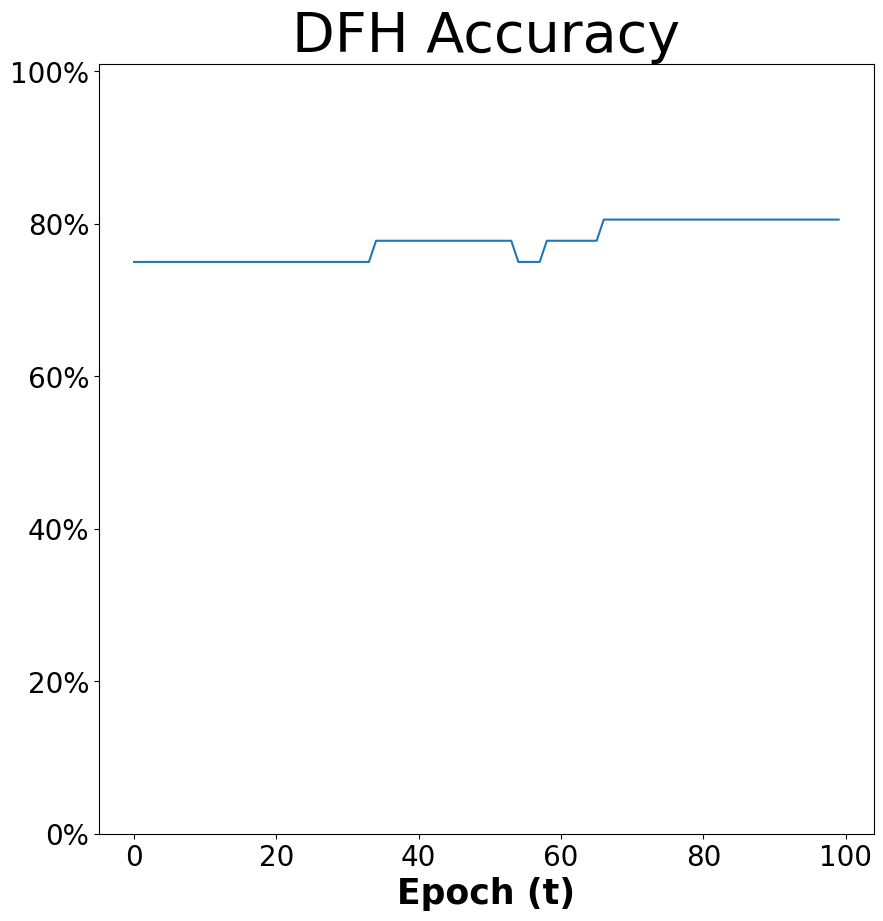

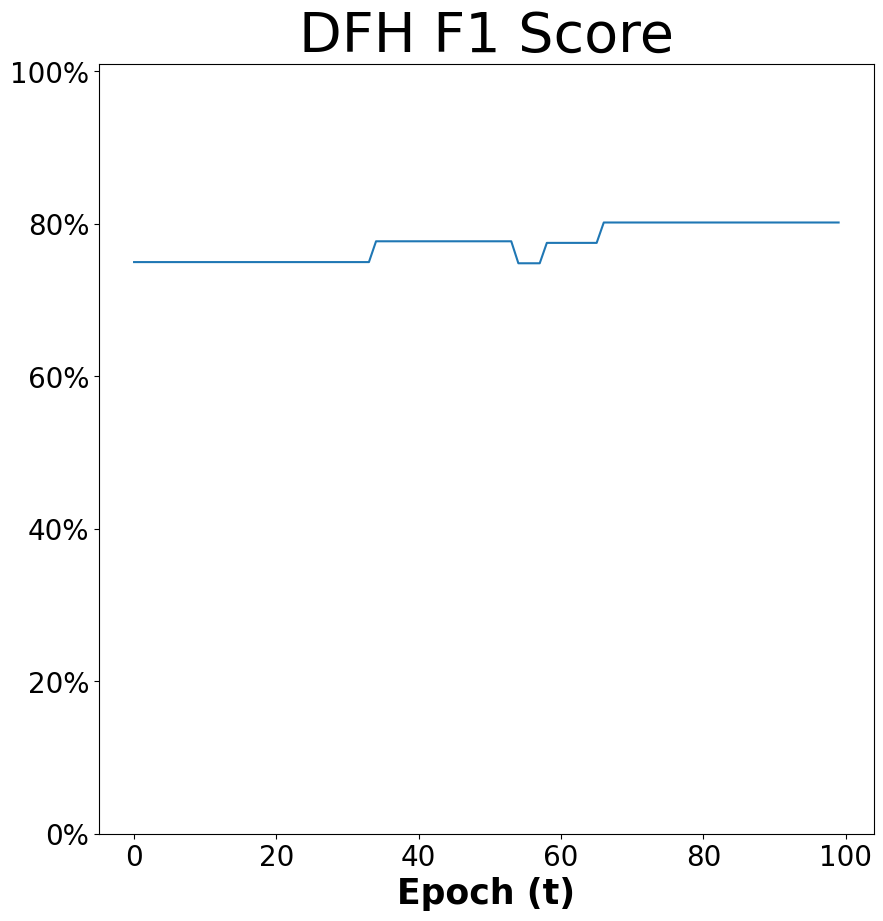

In [28]:
save_figs(dfh_glvq_acc, experiment, "DFH", learning_rate)

##### 3-step lr = 0.01

In [29]:
learning_rate = 0.01
dfh_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = dfh_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.dual_factor_heuristic,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4437, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 11, Loss: 0.4395, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 21, Loss: 0.4366, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 31, Loss: 0.4346, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 41, Loss: 0.4332, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 51, Loss: 0.4322, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 61, Loss: 0.4313, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 71, Loss: 0.4305, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 81, Loss: 0.4299, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 91, Loss: 0.4293, Accuracy: 75.00 %, F_1_score: 74.98 %


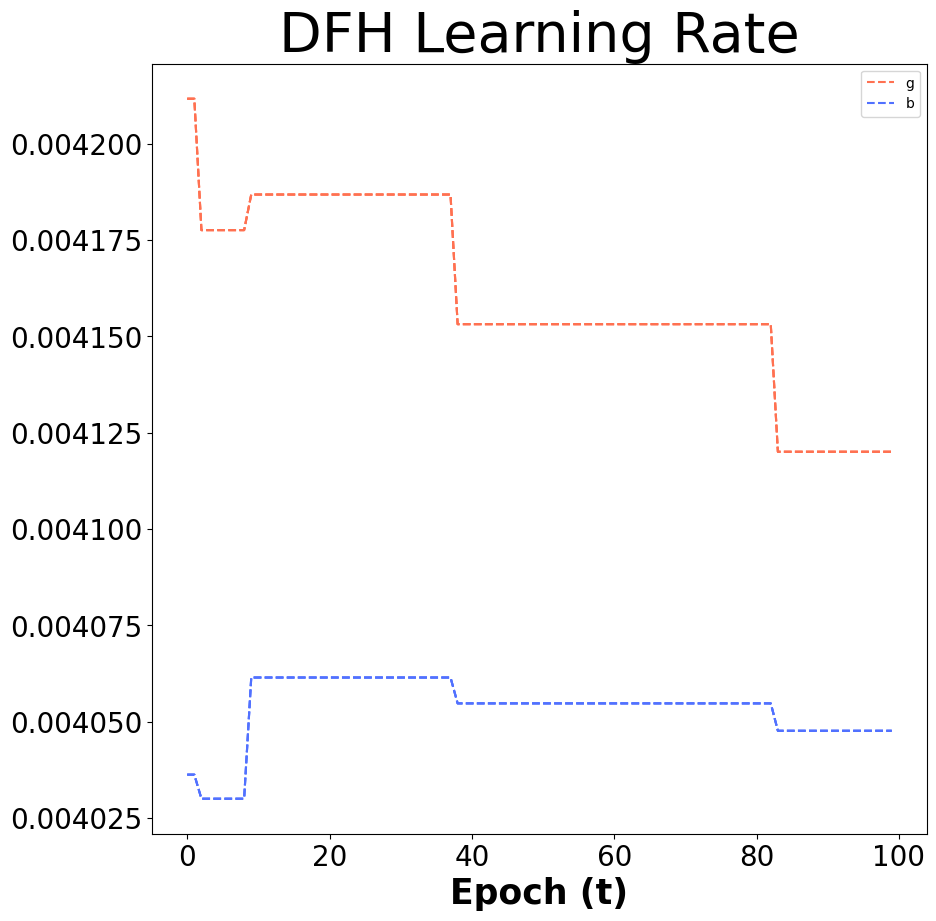

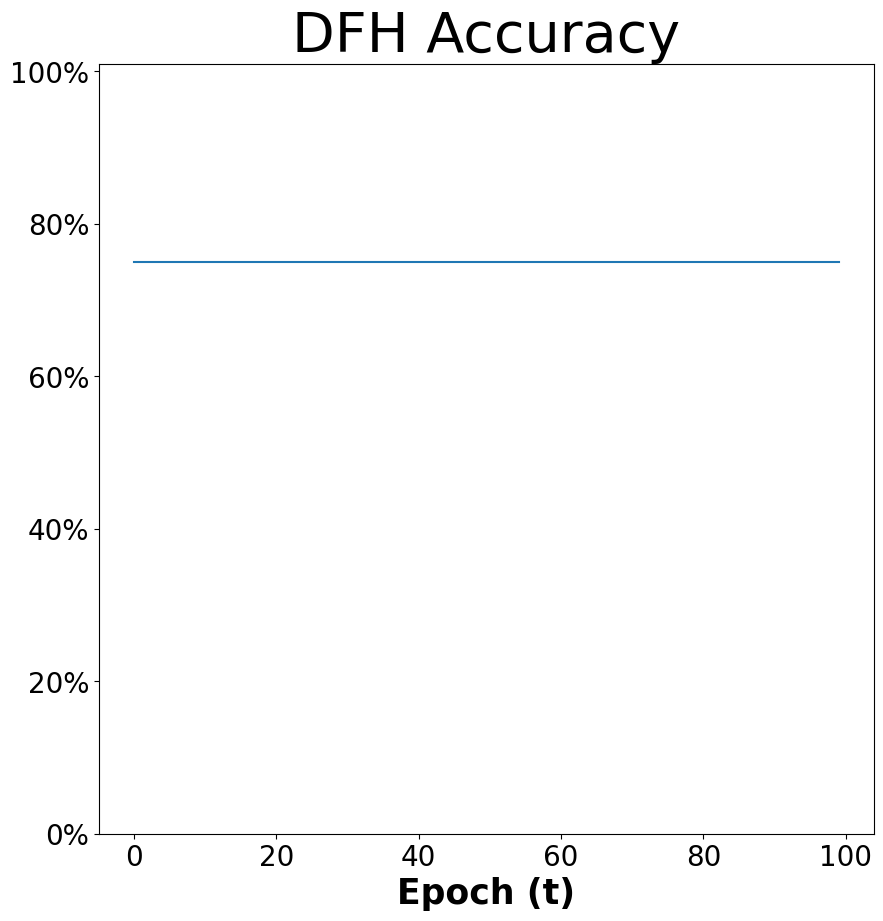

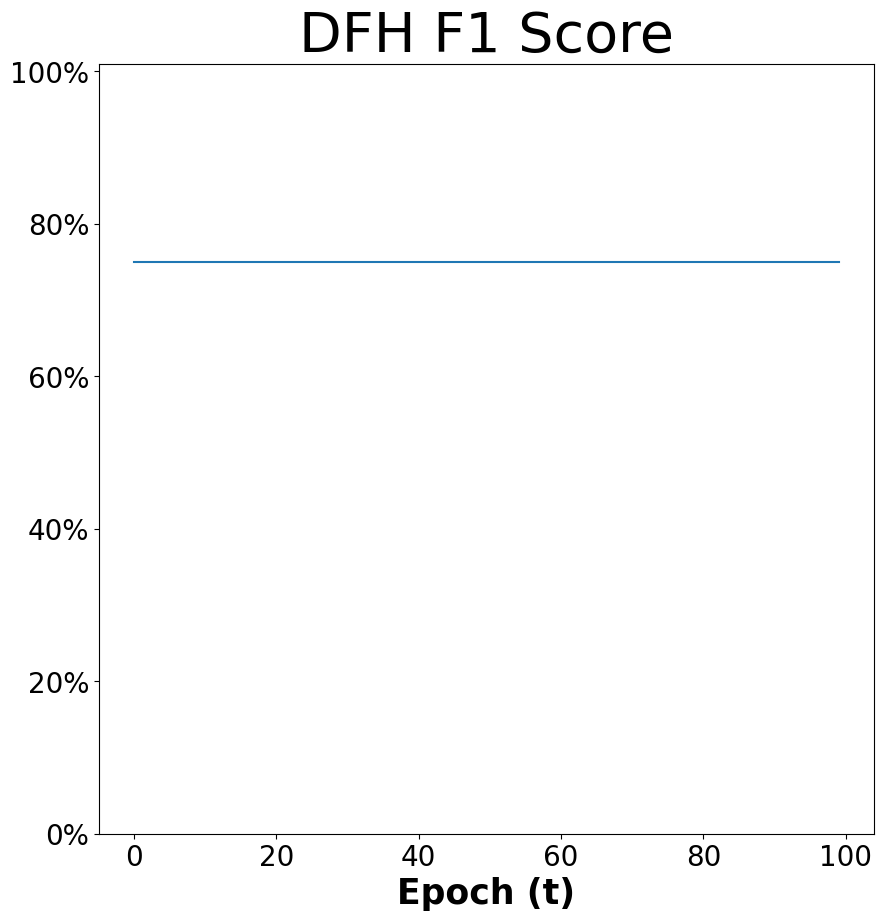

In [30]:
save_figs(dfh_glvq_acc, experiment, "DFH", learning_rate)

##### MS

##### 1-step lr = 0.1

In [31]:
learning_rate = 0.1
ms_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = ms_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.middle_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4410, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 11, Loss: 0.4269, Accuracy: 77.78 %, F_1_score: 77.71 %
Epoch: 21, Loss: 0.4234, Accuracy: 80.56 %, F_1_score: 80.17 %
Epoch: 31, Loss: 0.4210, Accuracy: 80.56 %, F_1_score: 80.17 %
Epoch: 41, Loss: 0.4187, Accuracy: 83.33 %, F_1_score: 82.86 %
Epoch: 51, Loss: 0.4164, Accuracy: 83.33 %, F_1_score: 82.86 %
Epoch: 61, Loss: 0.4143, Accuracy: 83.33 %, F_1_score: 82.86 %
Epoch: 71, Loss: 0.4124, Accuracy: 86.11 %, F_1_score: 85.84 %
Epoch: 81, Loss: 0.4108, Accuracy: 86.11 %, F_1_score: 85.84 %
Epoch: 91, Loss: 0.4097, Accuracy: 86.11 %, F_1_score: 85.84 %


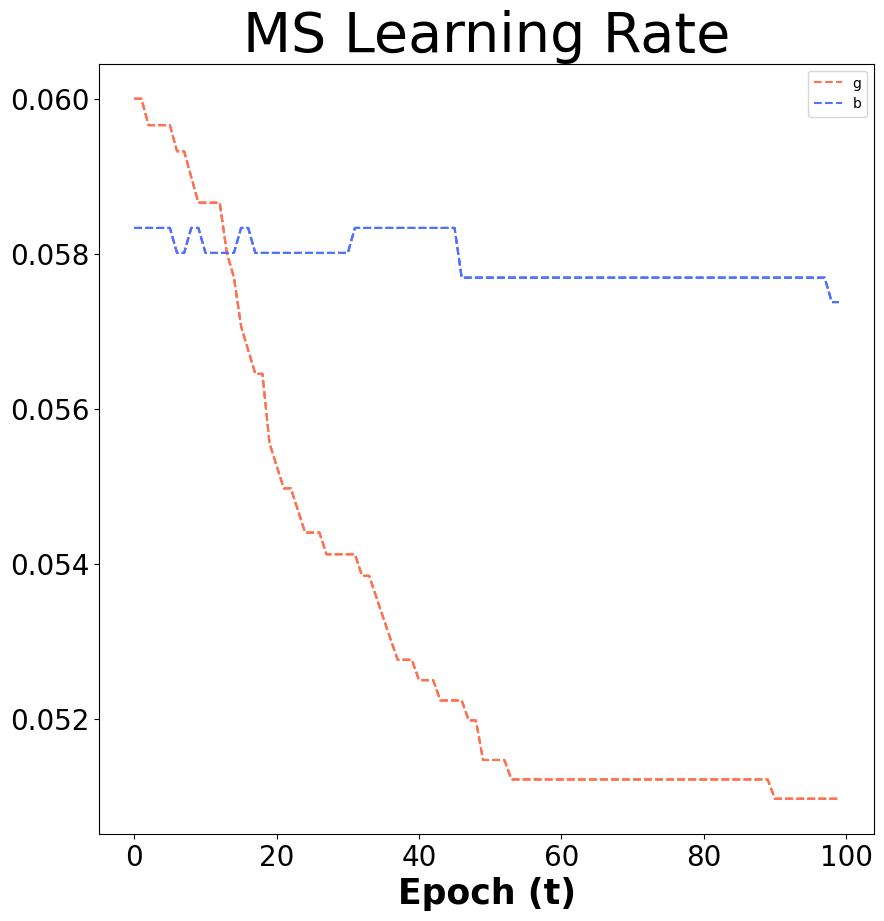

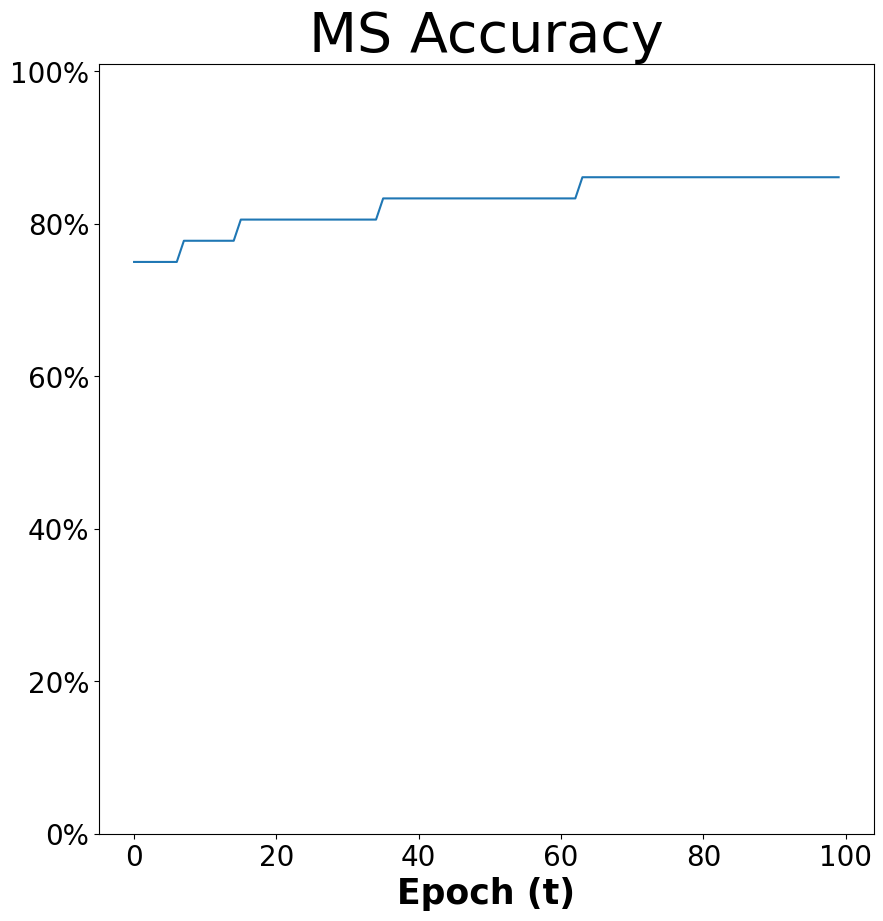

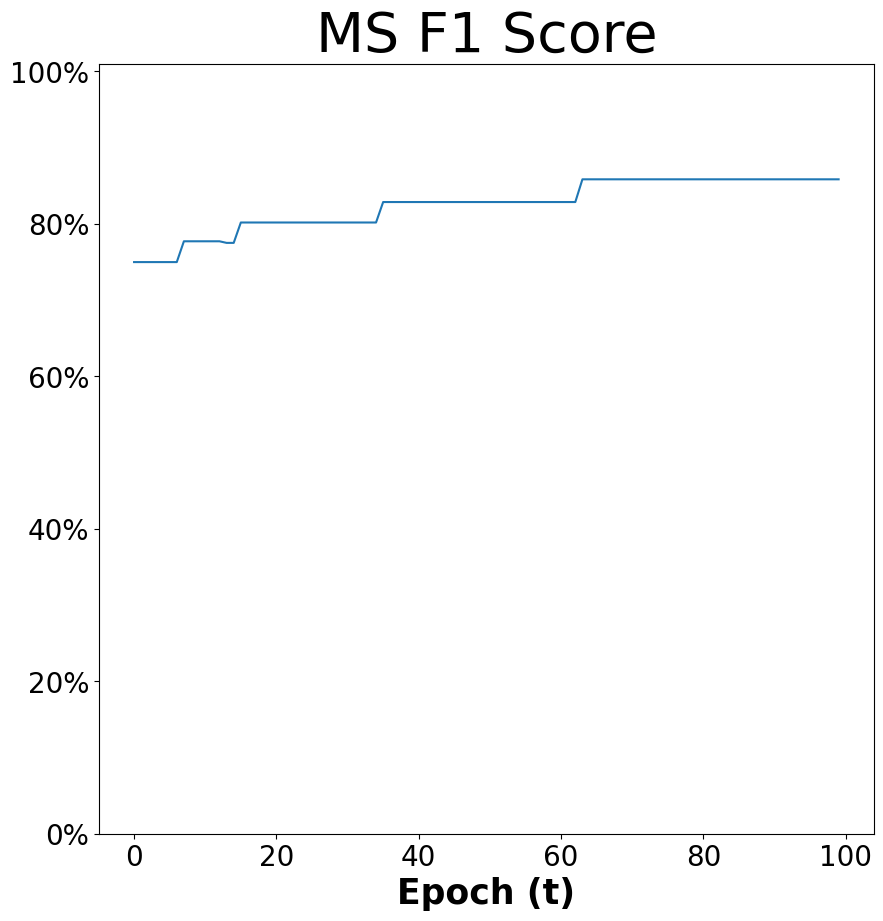

In [32]:
save_figs(ms_glvq_acc, experiment, "MS", learning_rate)

##### 2-step lr = 0.03

In [33]:
learning_rate = 0.03
ms_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = ms_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.middle_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4430, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 11, Loss: 0.4329, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 21, Loss: 0.4296, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 31, Loss: 0.4274, Accuracy: 77.78 %, F_1_score: 77.71 %
Epoch: 41, Loss: 0.4259, Accuracy: 77.78 %, F_1_score: 77.71 %
Epoch: 51, Loss: 0.4248, Accuracy: 77.78 %, F_1_score: 77.50 %
Epoch: 61, Loss: 0.4239, Accuracy: 80.56 %, F_1_score: 80.17 %
Epoch: 71, Loss: 0.4231, Accuracy: 80.56 %, F_1_score: 80.17 %
Epoch: 81, Loss: 0.4224, Accuracy: 80.56 %, F_1_score: 80.17 %
Epoch: 91, Loss: 0.4217, Accuracy: 80.56 %, F_1_score: 80.17 %


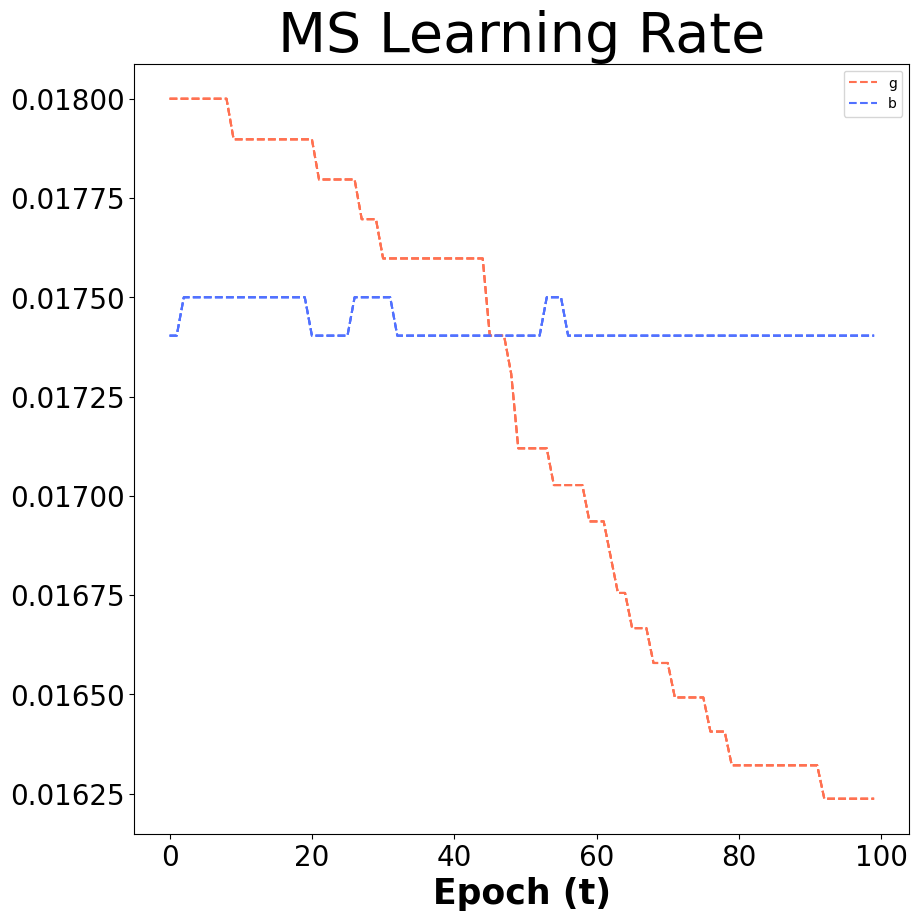

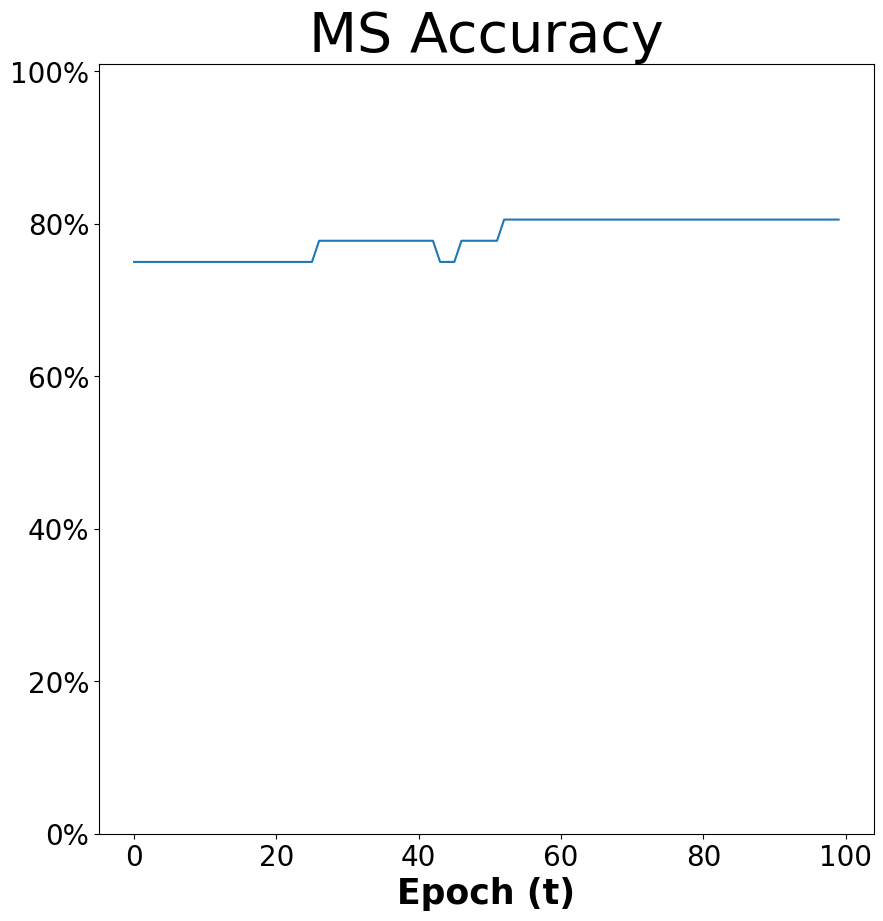

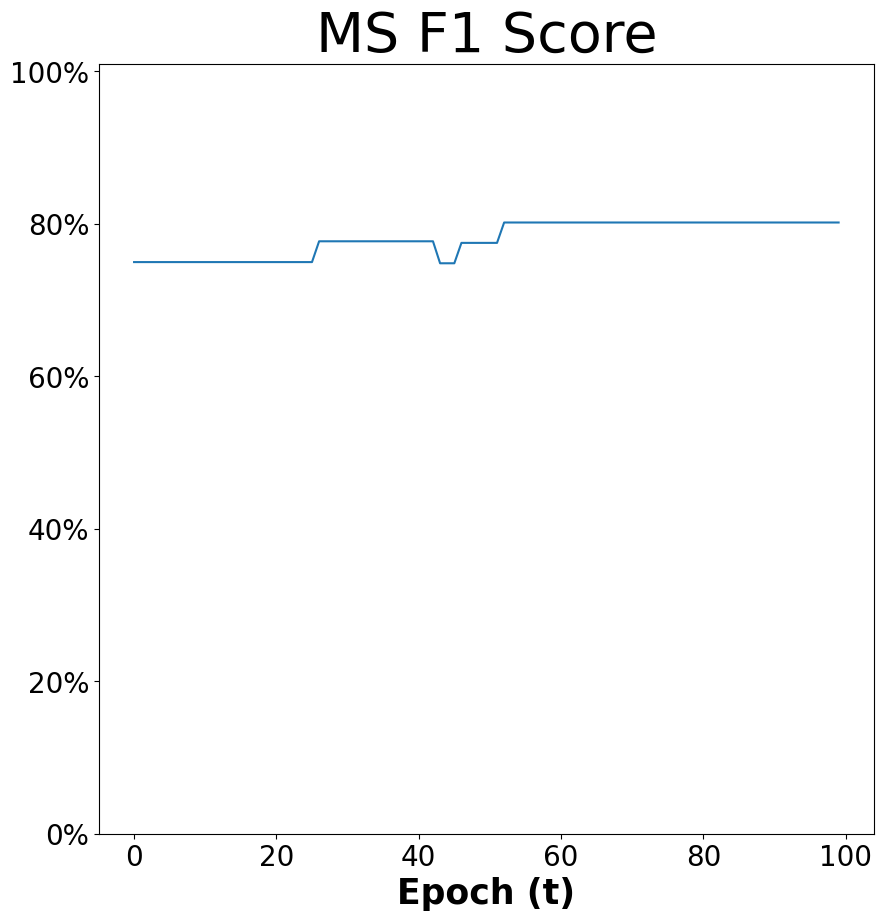

In [34]:
save_figs(ms_glvq_acc, experiment, "MS", learning_rate)

##### 3-step lr = 0.01

In [35]:
learning_rate = 0.01
ms_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = ms_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.middle_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4436, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 11, Loss: 0.4381, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 21, Loss: 0.4349, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 31, Loss: 0.4330, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 41, Loss: 0.4316, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 51, Loss: 0.4305, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 61, Loss: 0.4296, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 71, Loss: 0.4288, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 81, Loss: 0.4281, Accuracy: 77.78 %, F_1_score: 77.71 %
Epoch: 91, Loss: 0.4275, Accuracy: 77.78 %, F_1_score: 77.71 %


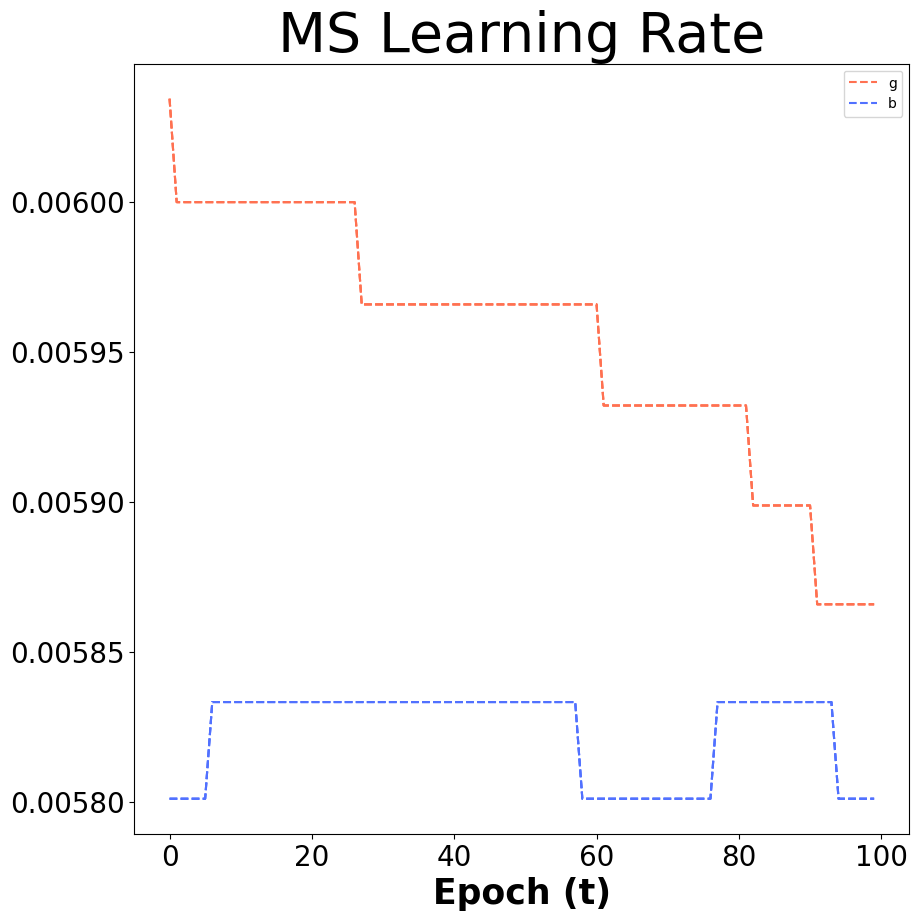

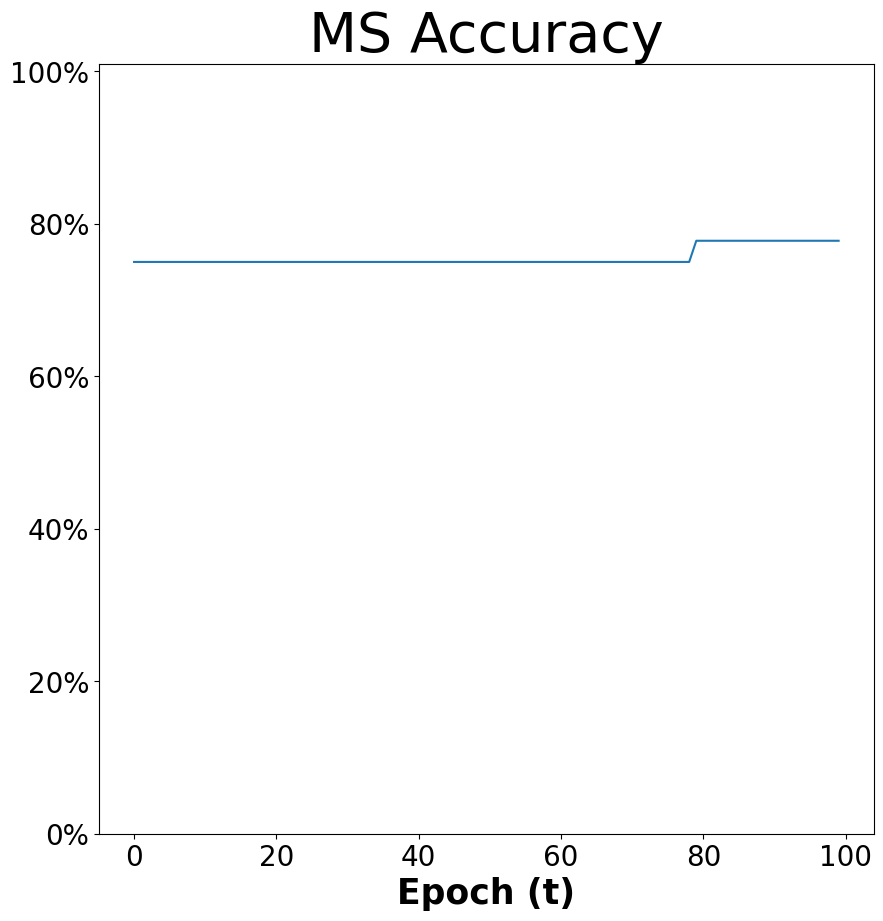

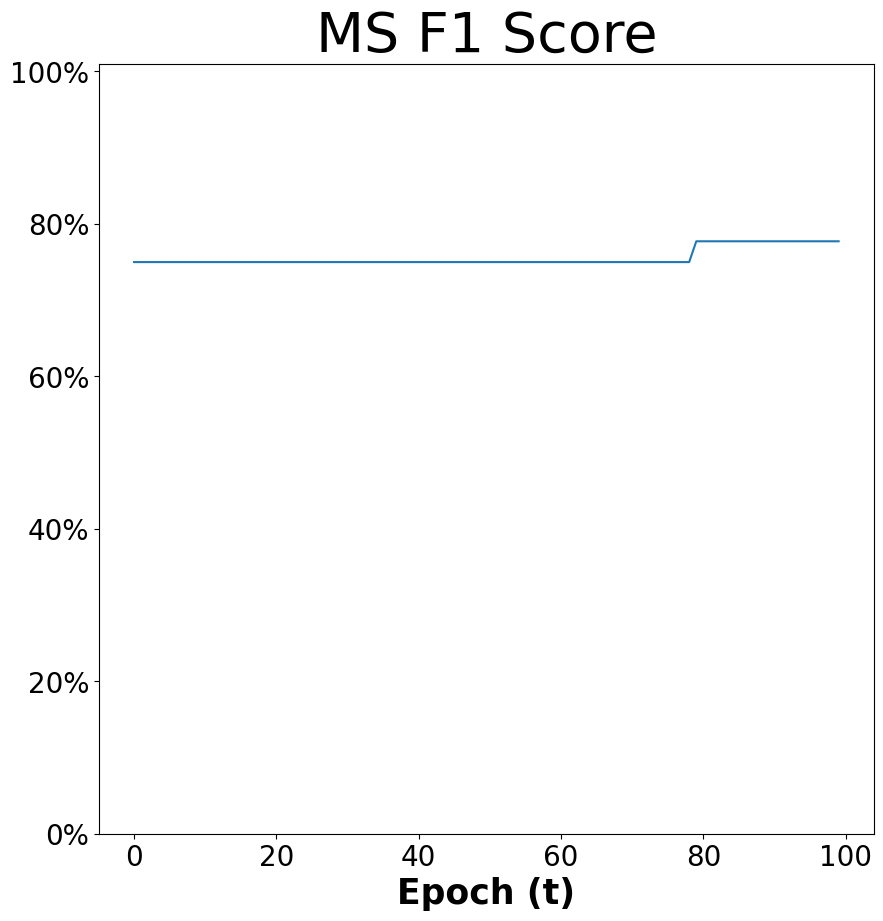

In [36]:
save_figs(ms_glvq_acc, experiment, "MS", learning_rate)

##### LS

##### 1-step lr = 0.1

In [37]:
learning_rate = 0.1
ls_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = ls_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.loose_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4419, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 11, Loss: 0.4286, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 21, Loss: 0.4250, Accuracy: 77.78 %, F_1_score: 77.50 %
Epoch: 31, Loss: 0.4230, Accuracy: 80.56 %, F_1_score: 80.17 %
Epoch: 41, Loss: 0.4212, Accuracy: 80.56 %, F_1_score: 80.17 %
Epoch: 51, Loss: 0.4195, Accuracy: 83.33 %, F_1_score: 82.86 %
Epoch: 61, Loss: 0.4176, Accuracy: 83.33 %, F_1_score: 82.86 %
Epoch: 71, Loss: 0.4158, Accuracy: 83.33 %, F_1_score: 82.86 %
Epoch: 81, Loss: 0.4141, Accuracy: 83.33 %, F_1_score: 82.86 %
Epoch: 91, Loss: 0.4127, Accuracy: 86.11 %, F_1_score: 85.84 %


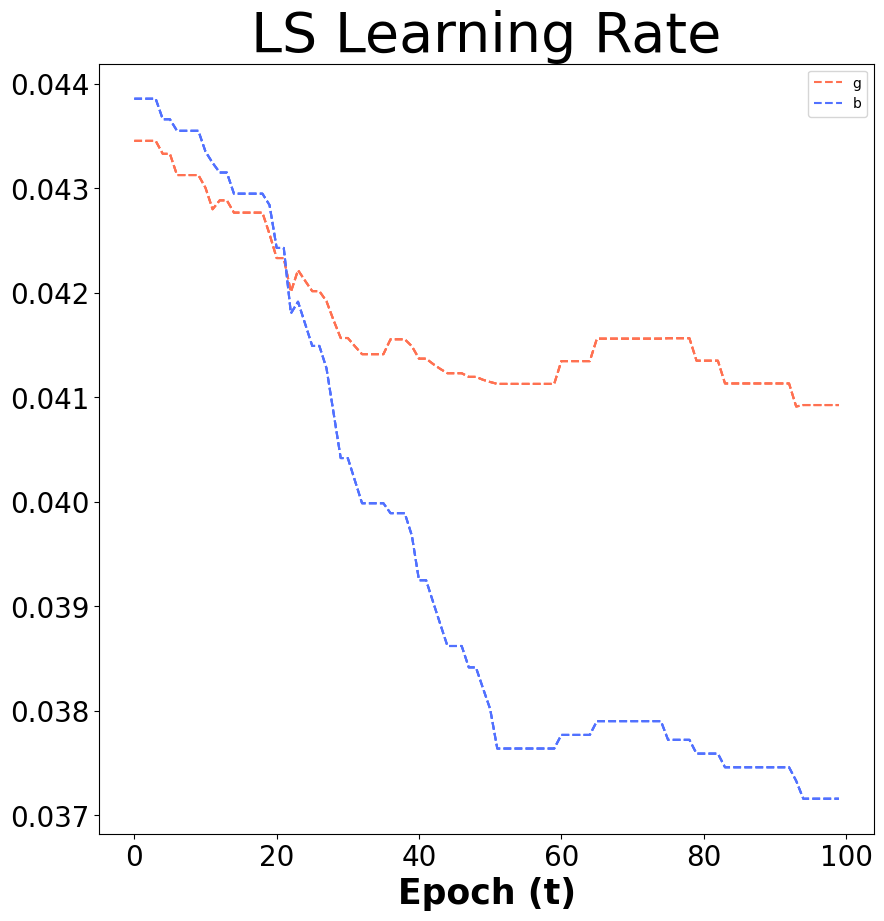

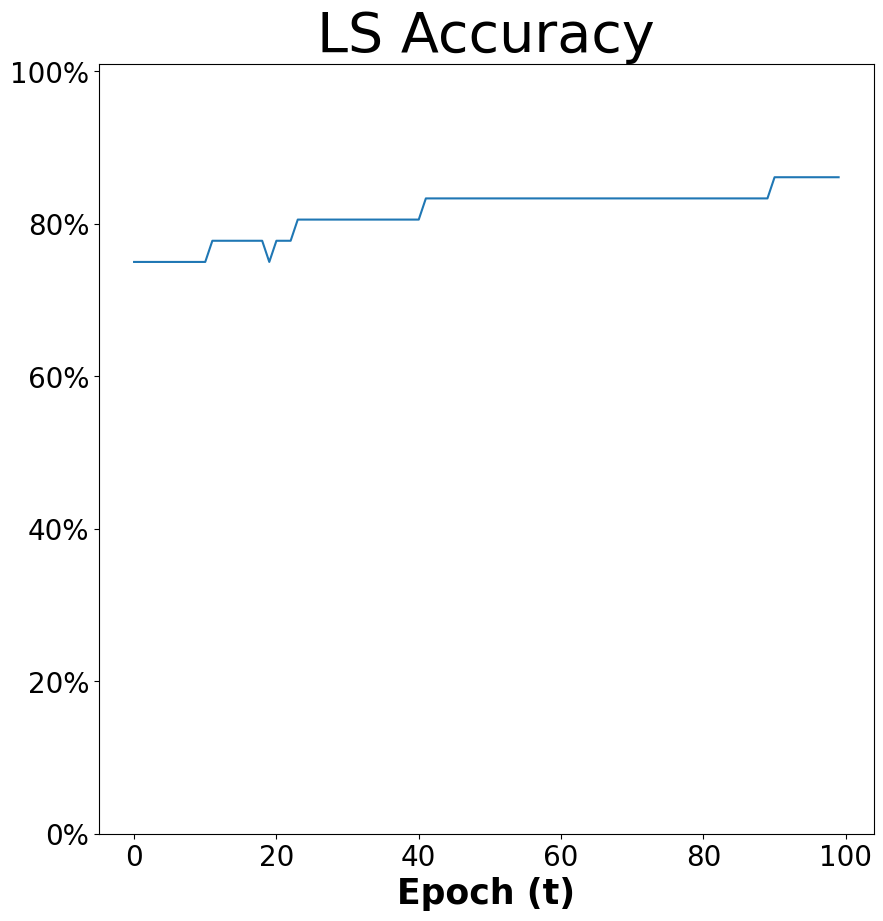

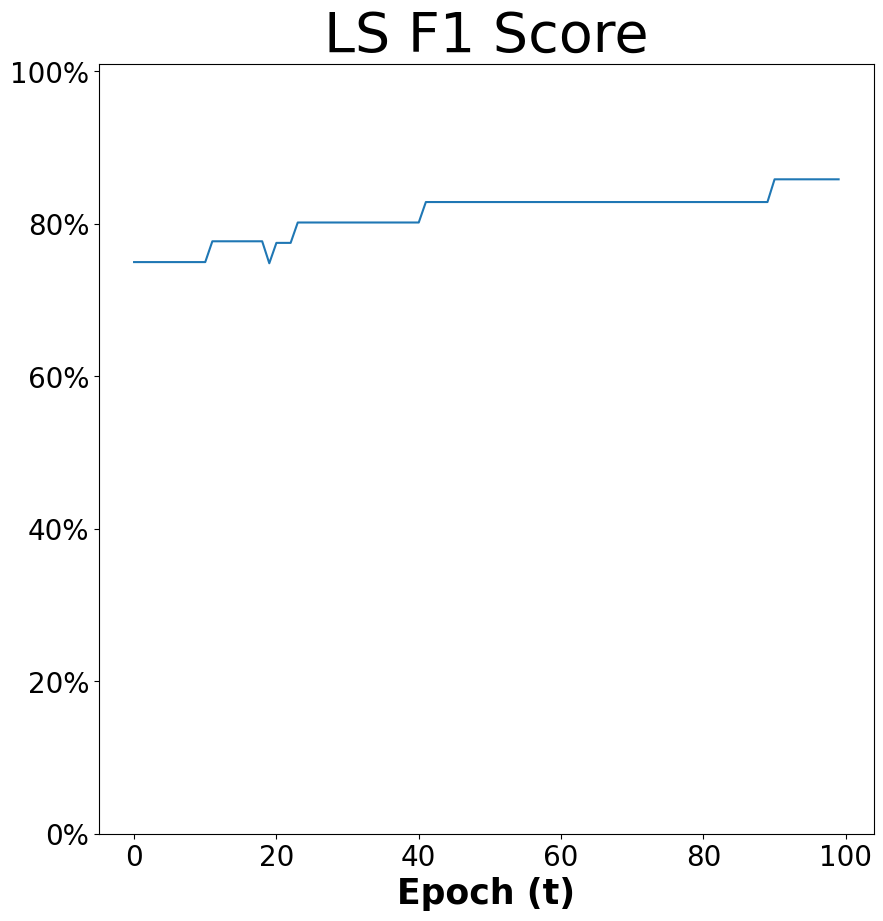

In [38]:
save_figs(ls_glvq_acc, experiment, "LS", learning_rate)

##### 2-step lr = 0.03

In [39]:
learning_rate = 0.03
ls_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = ls_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.loose_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4433, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 11, Loss: 0.4344, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 21, Loss: 0.4312, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 31, Loss: 0.4292, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 41, Loss: 0.4277, Accuracy: 77.78 %, F_1_score: 77.71 %
Epoch: 51, Loss: 0.4265, Accuracy: 77.78 %, F_1_score: 77.71 %
Epoch: 61, Loss: 0.4255, Accuracy: 77.78 %, F_1_score: 77.71 %
Epoch: 71, Loss: 0.4247, Accuracy: 77.78 %, F_1_score: 77.50 %
Epoch: 81, Loss: 0.4241, Accuracy: 80.56 %, F_1_score: 80.17 %
Epoch: 91, Loss: 0.4235, Accuracy: 80.56 %, F_1_score: 80.17 %


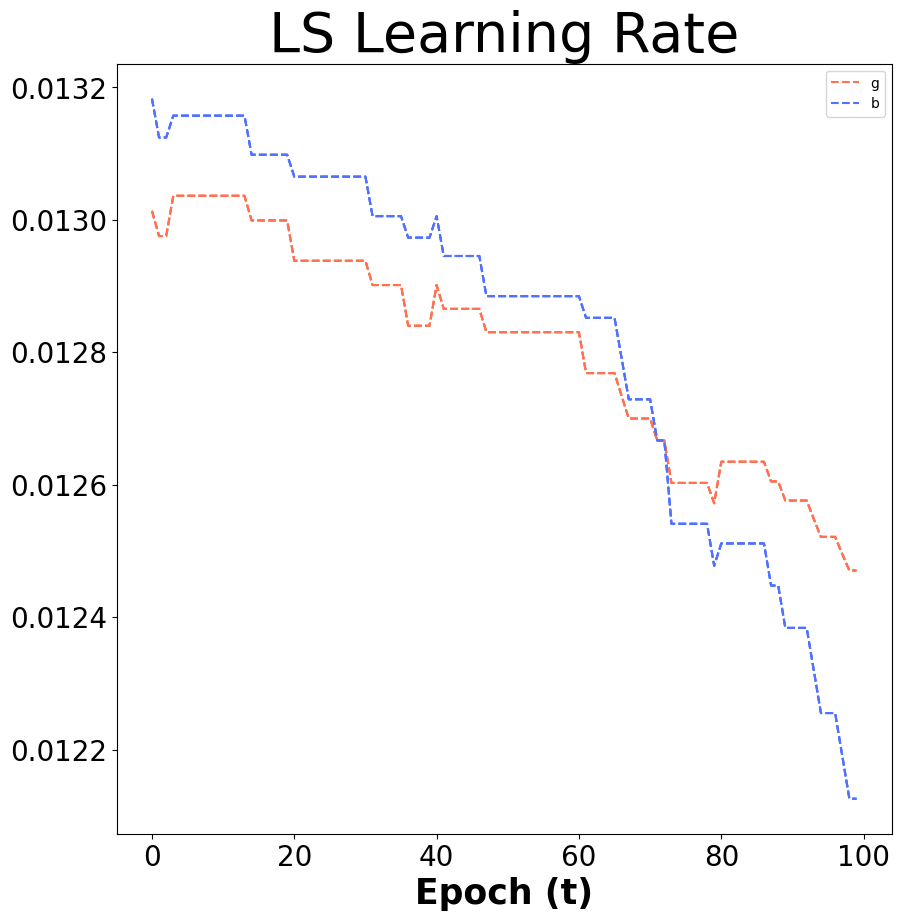

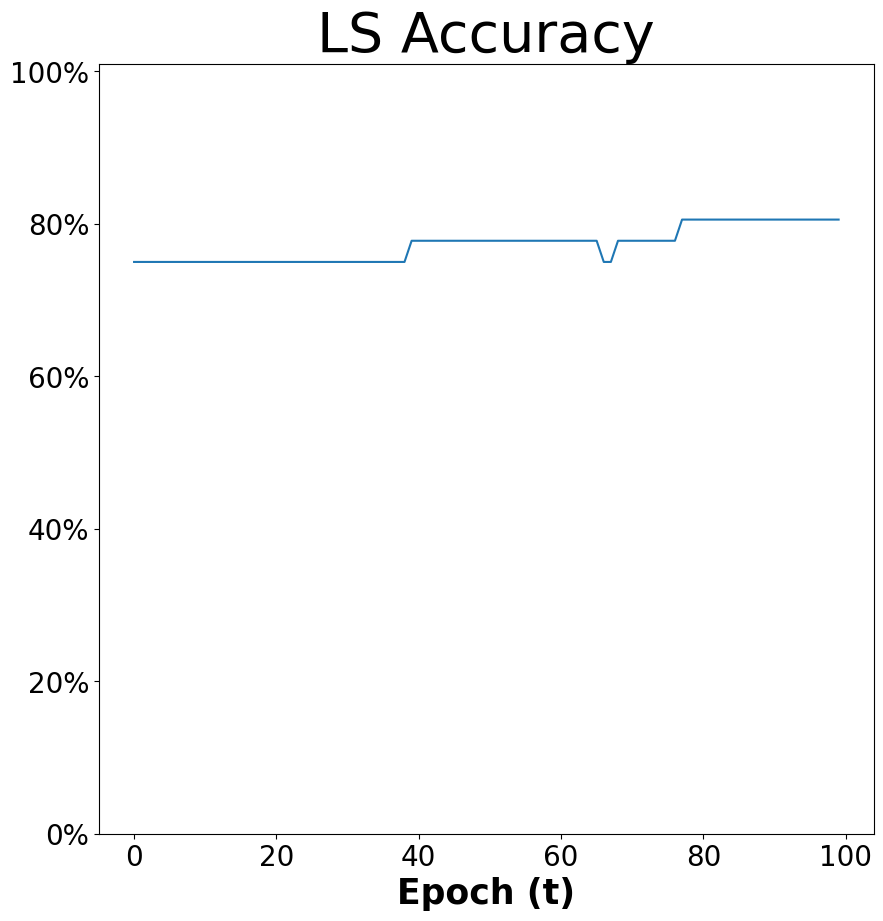

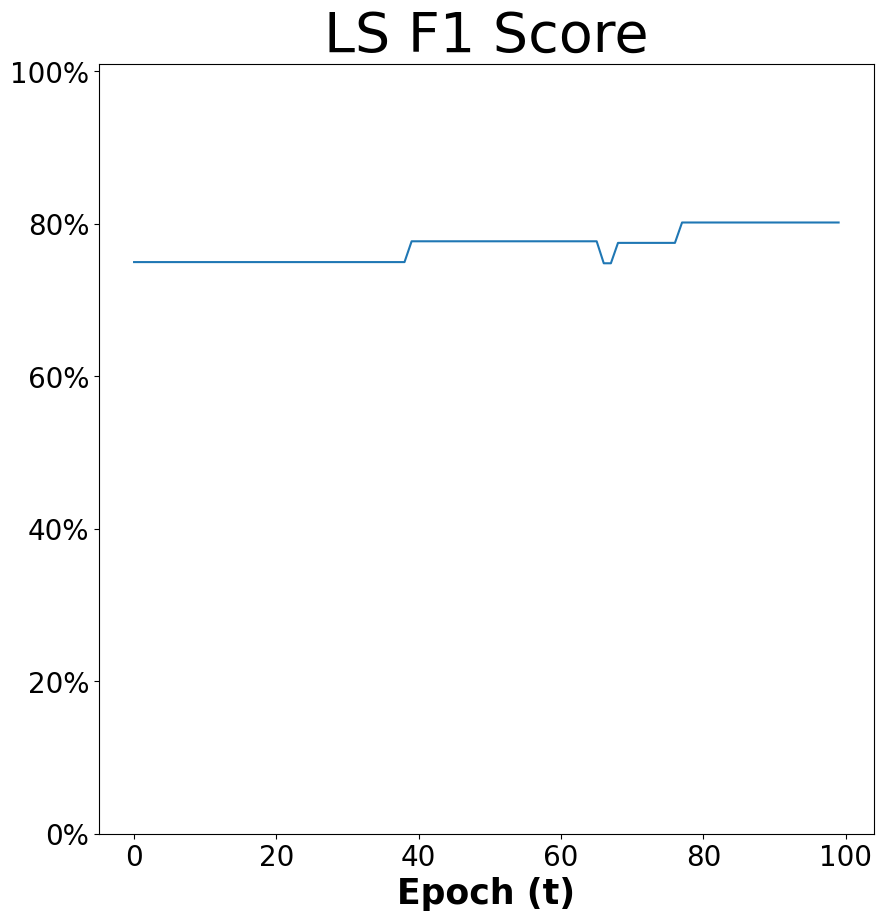

In [40]:
save_figs(ls_glvq_acc, experiment, "LS", learning_rate)

##### 3-step lr = 0.01

In [41]:
learning_rate = 0.01
ls_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = ls_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.loose_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4438, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 11, Loss: 0.4395, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 21, Loss: 0.4366, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 31, Loss: 0.4346, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 41, Loss: 0.4332, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 51, Loss: 0.4322, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 61, Loss: 0.4313, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 71, Loss: 0.4305, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 81, Loss: 0.4299, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 91, Loss: 0.4292, Accuracy: 75.00 %, F_1_score: 74.98 %


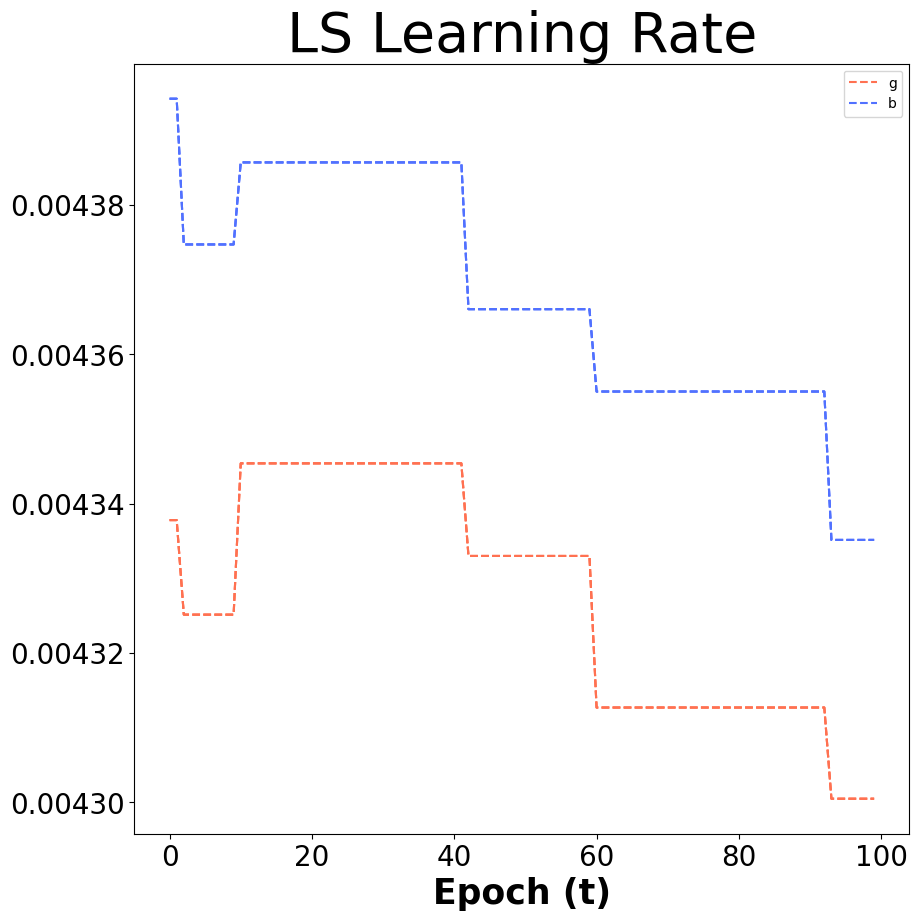

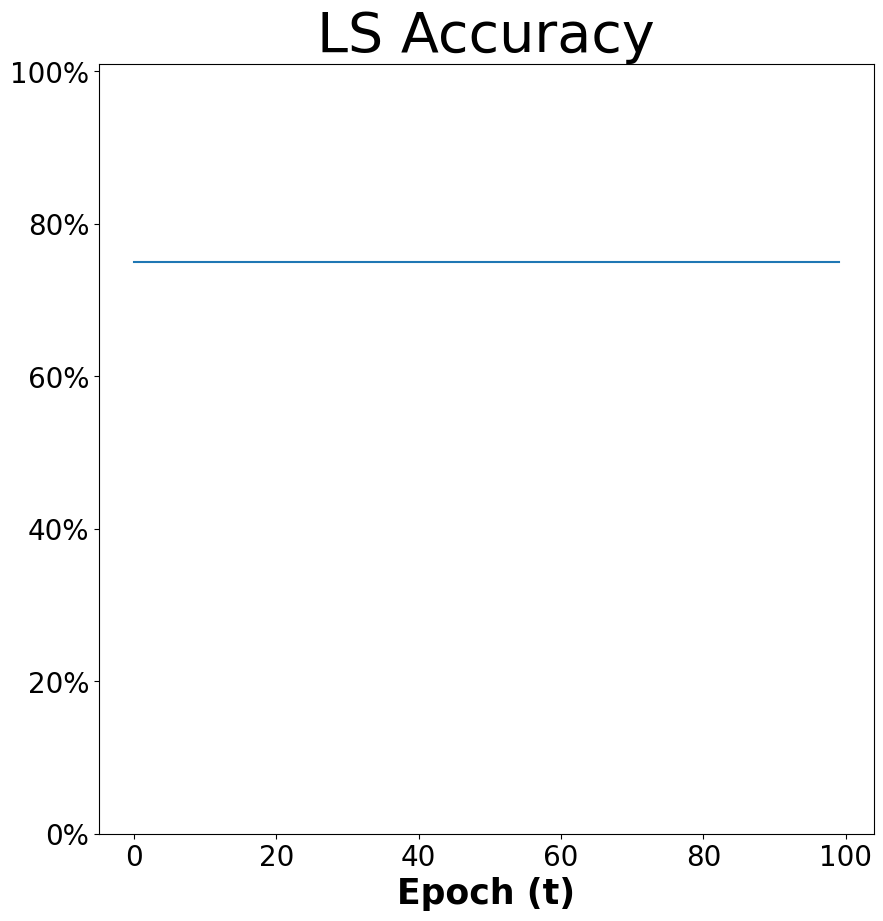

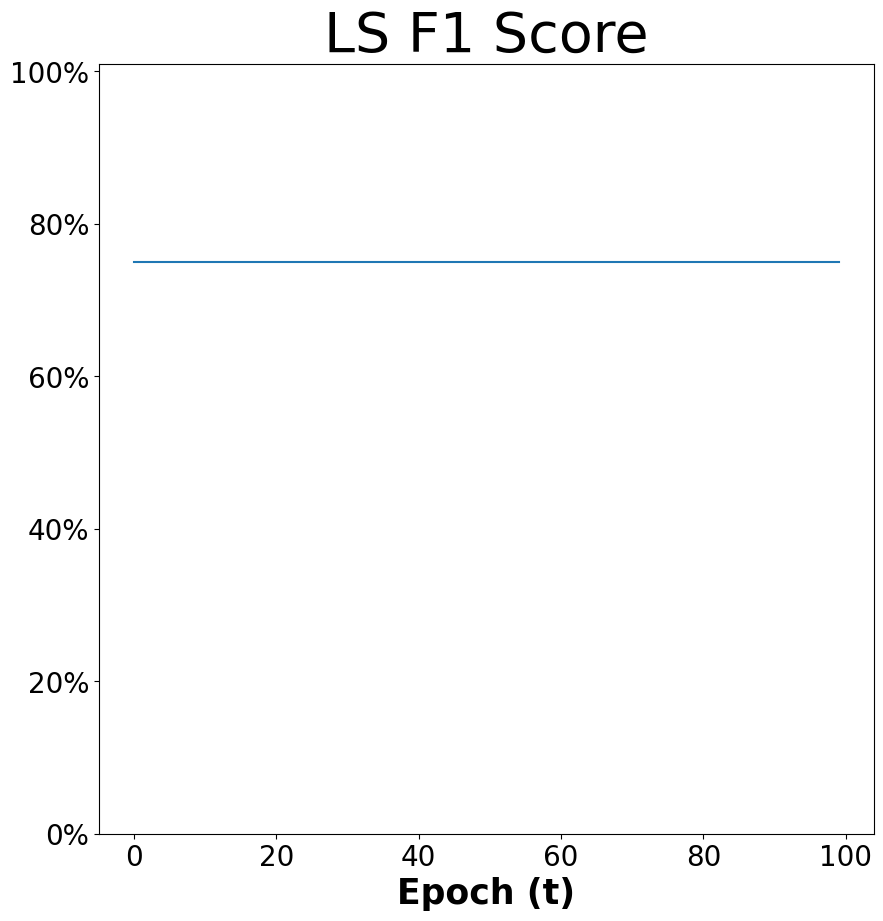

In [42]:
save_figs(ls_glvq_acc, experiment, "LS", learning_rate)

##### LSR

##### 1-step lr = 0.1

In [43]:
learning_rate = 0.1
lsr_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = lsr_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.loose_symmetry_rarity,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4420, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 11, Loss: 0.4291, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 21, Loss: 0.4254, Accuracy: 77.78 %, F_1_score: 77.71 %
Epoch: 31, Loss: 0.4234, Accuracy: 80.56 %, F_1_score: 80.17 %
Epoch: 41, Loss: 0.4218, Accuracy: 80.56 %, F_1_score: 80.17 %
Epoch: 51, Loss: 0.4203, Accuracy: 83.33 %, F_1_score: 82.86 %
Epoch: 61, Loss: 0.4187, Accuracy: 83.33 %, F_1_score: 82.86 %
Epoch: 71, Loss: 0.4171, Accuracy: 83.33 %, F_1_score: 82.86 %
Epoch: 81, Loss: 0.4155, Accuracy: 83.33 %, F_1_score: 82.86 %
Epoch: 91, Loss: 0.4141, Accuracy: 83.33 %, F_1_score: 82.86 %


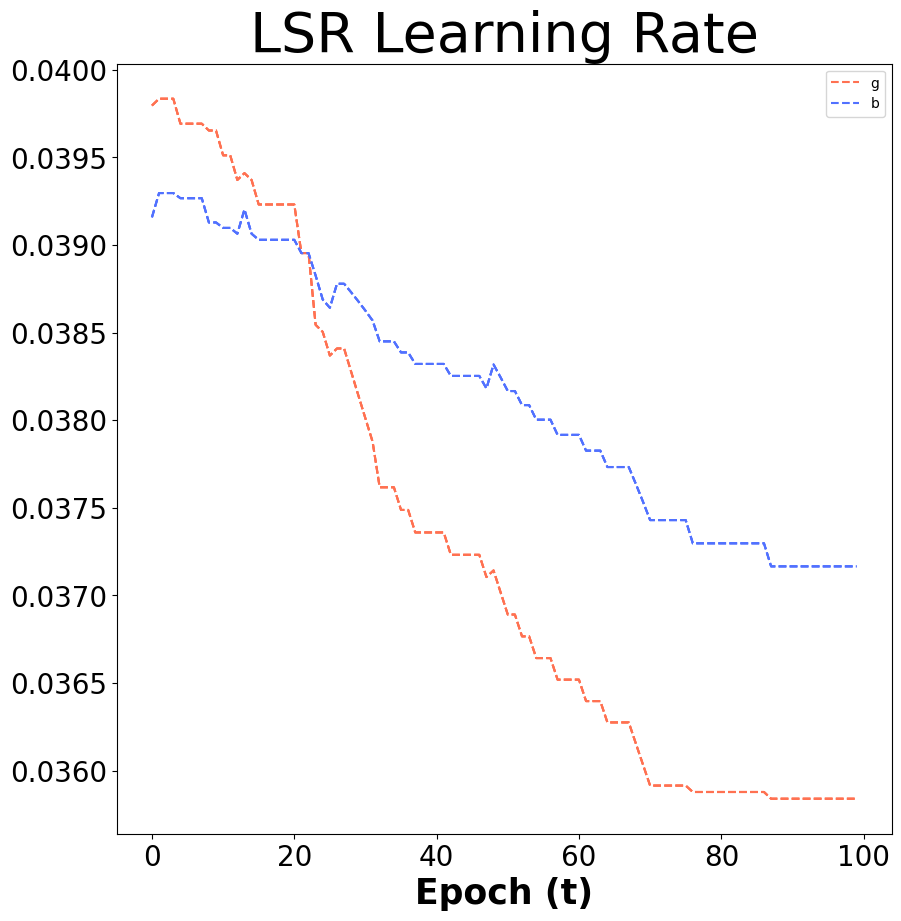

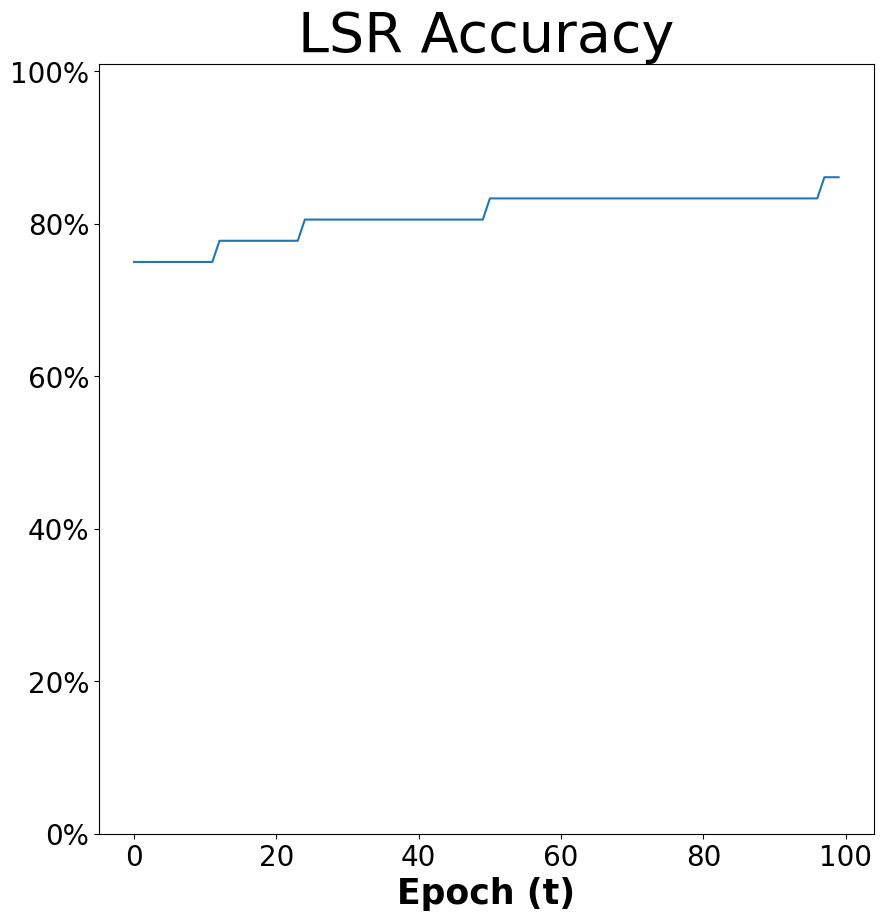

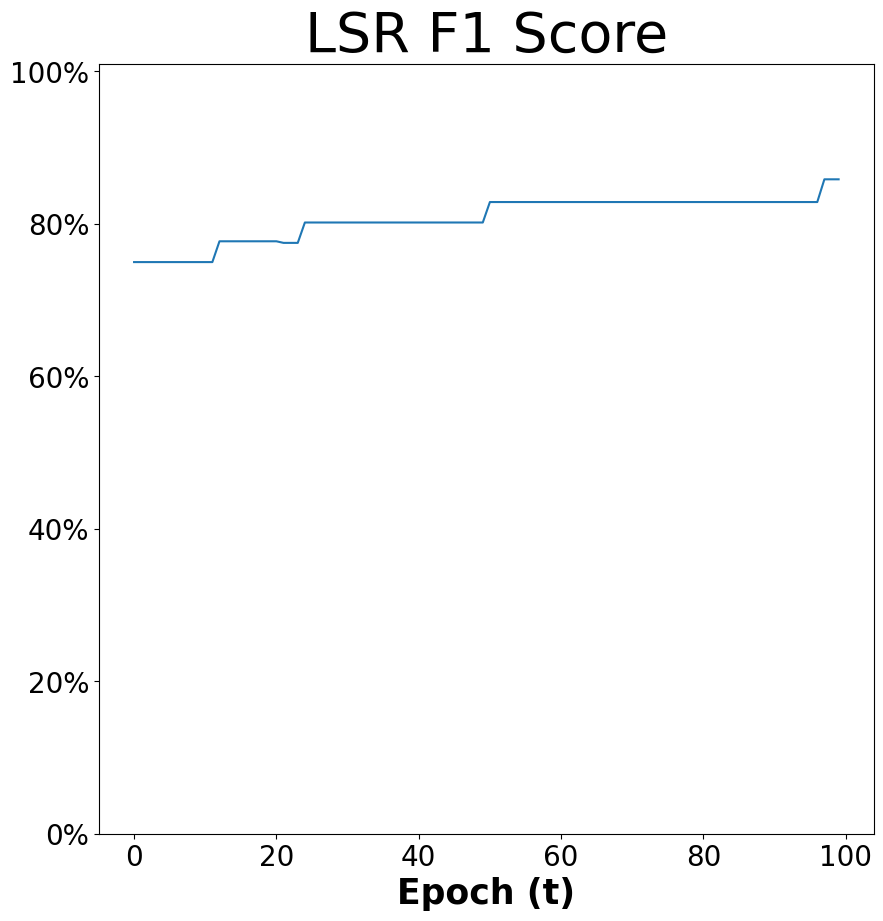

In [44]:
save_figs(lsr_glvq_acc, experiment, "LSR", learning_rate)

##### 2-step lr = 0.03

In [45]:
learning_rate = 0.03
lsr_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = lsr_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.loose_symmetry_rarity,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4433, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 11, Loss: 0.4349, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 21, Loss: 0.4317, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 31, Loss: 0.4297, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 41, Loss: 0.4282, Accuracy: 77.78 %, F_1_score: 77.71 %
Epoch: 51, Loss: 0.4269, Accuracy: 77.78 %, F_1_score: 77.71 %
Epoch: 61, Loss: 0.4260, Accuracy: 77.78 %, F_1_score: 77.71 %
Epoch: 71, Loss: 0.4252, Accuracy: 75.00 %, F_1_score: 74.83 %
Epoch: 81, Loss: 0.4245, Accuracy: 77.78 %, F_1_score: 77.50 %
Epoch: 91, Loss: 0.4240, Accuracy: 80.56 %, F_1_score: 80.17 %


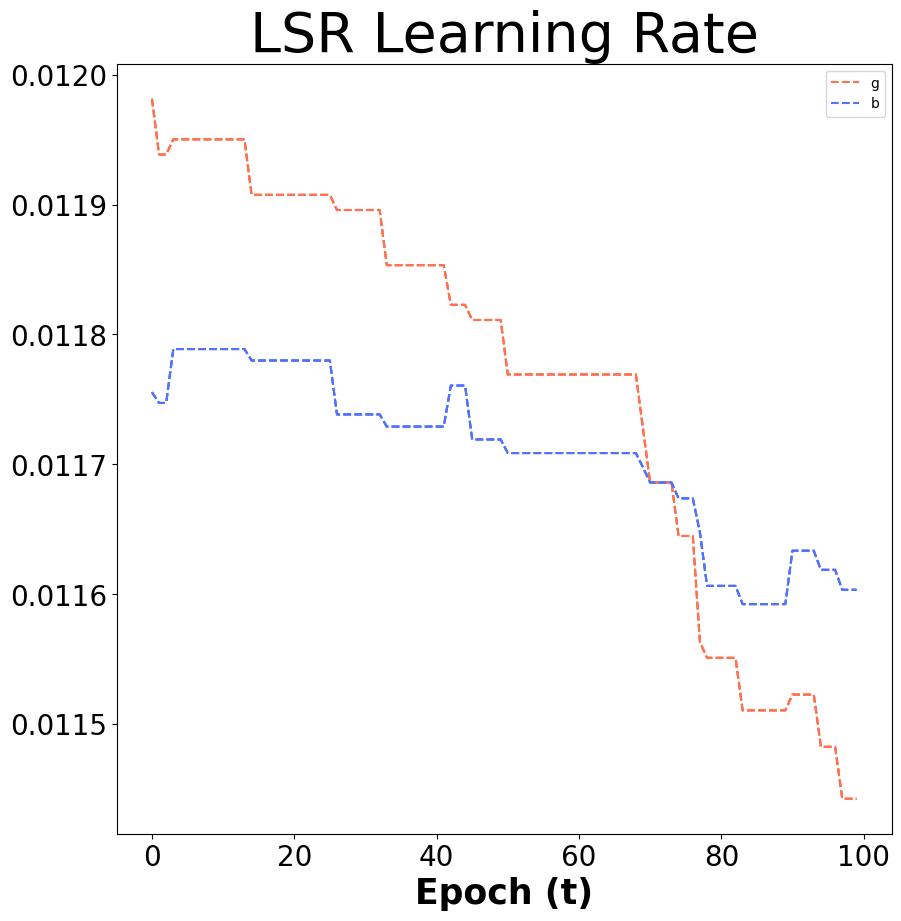

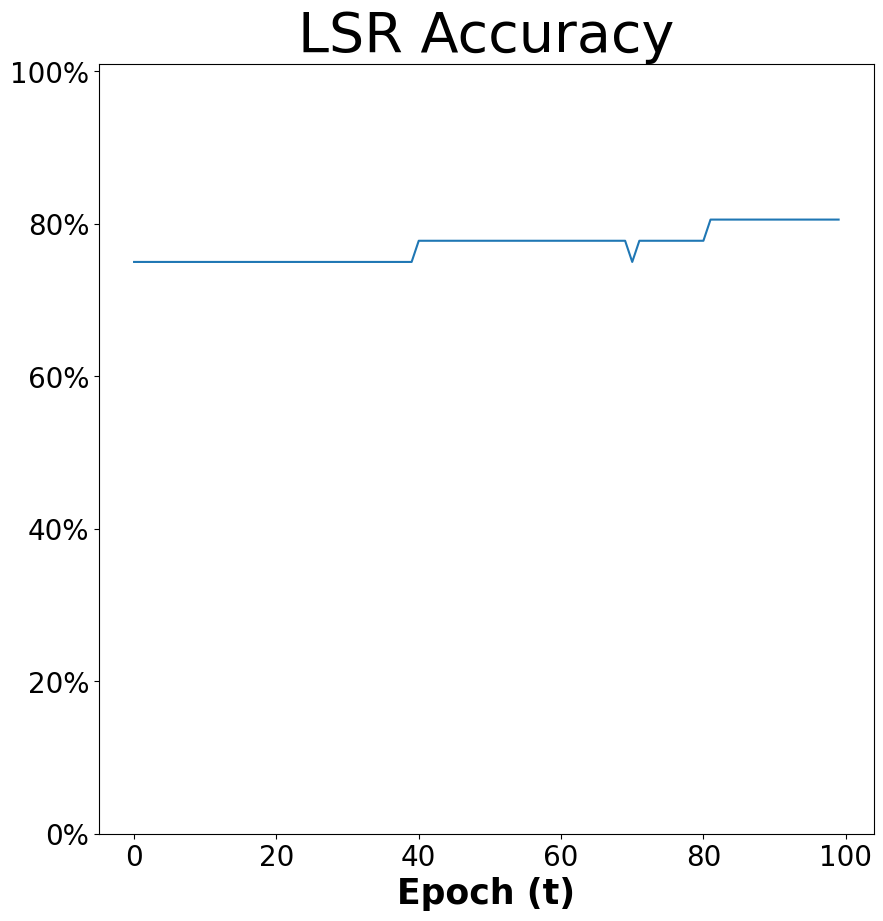

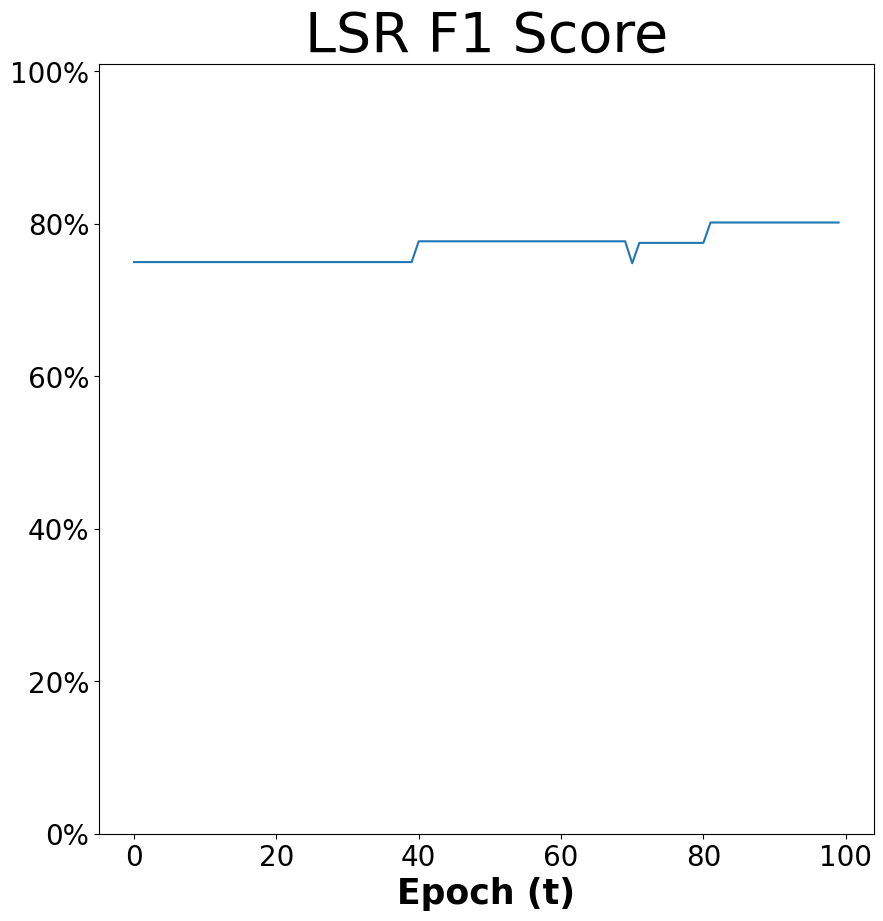

In [46]:
save_figs(lsr_glvq_acc, experiment, "LSR", learning_rate)

##### 3-step lr = 0.01

In [47]:
learning_rate = 0.01
lsr_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = lsr_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.loose_symmetry_rarity,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4438, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 11, Loss: 0.4398, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 21, Loss: 0.4370, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 31, Loss: 0.4350, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 41, Loss: 0.4336, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 51, Loss: 0.4326, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 61, Loss: 0.4317, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 71, Loss: 0.4309, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 81, Loss: 0.4303, Accuracy: 75.00 %, F_1_score: 74.98 %
Epoch: 91, Loss: 0.4297, Accuracy: 75.00 %, F_1_score: 74.98 %


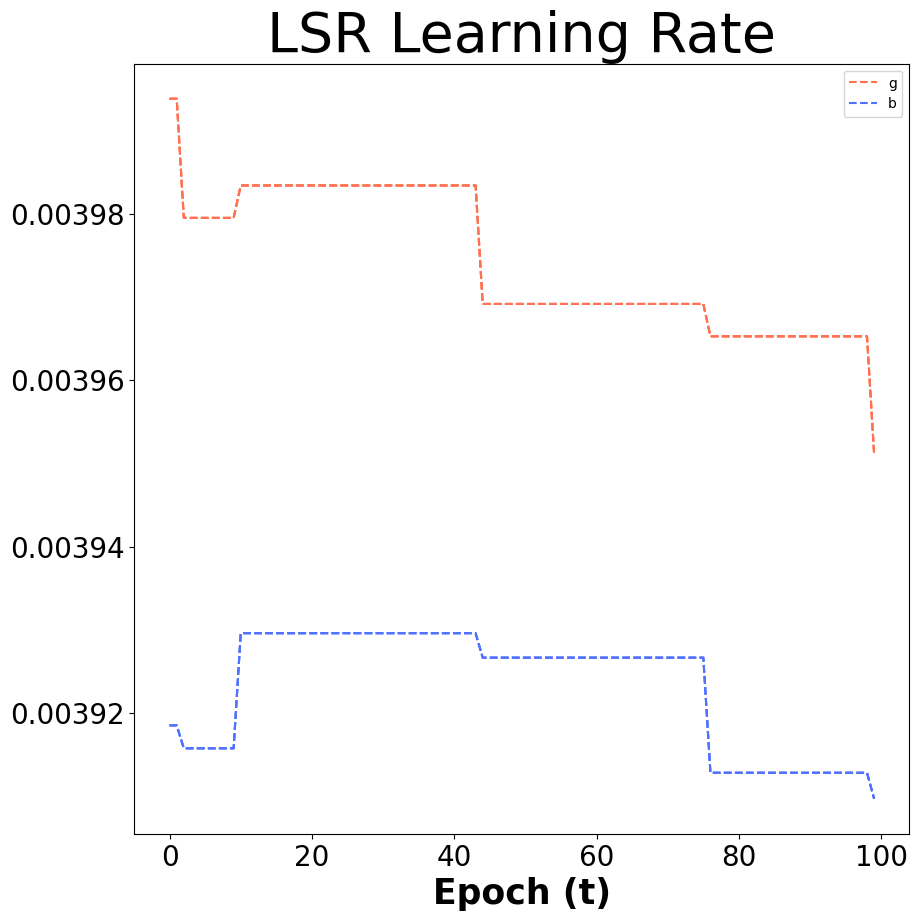

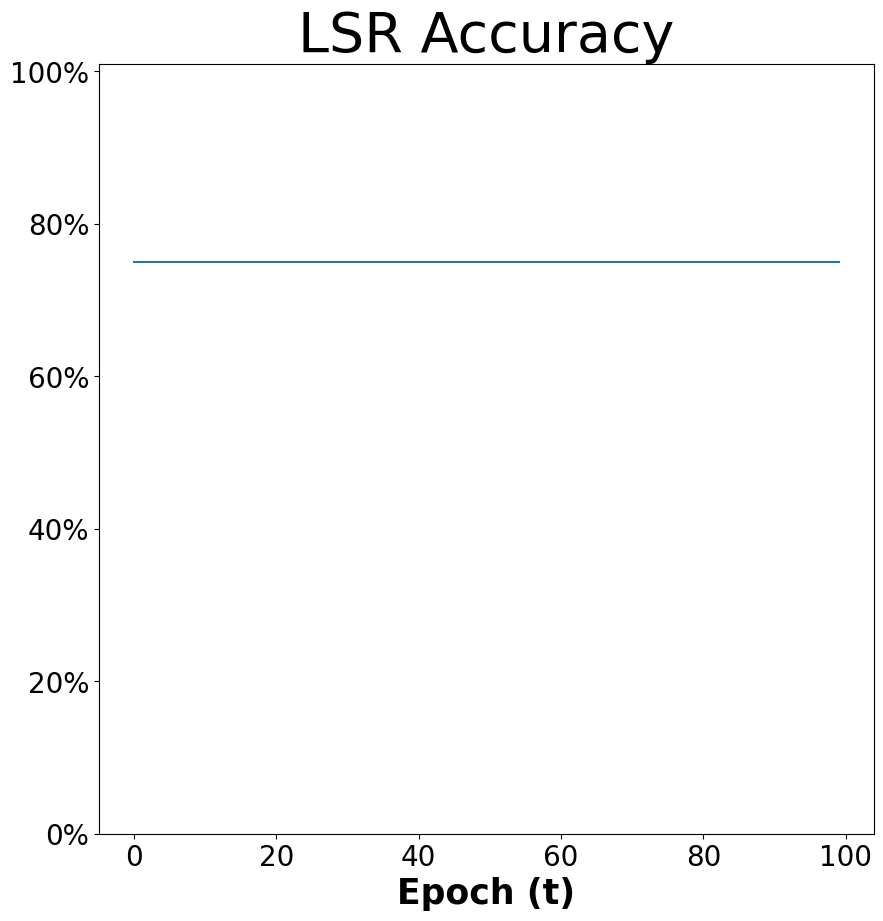

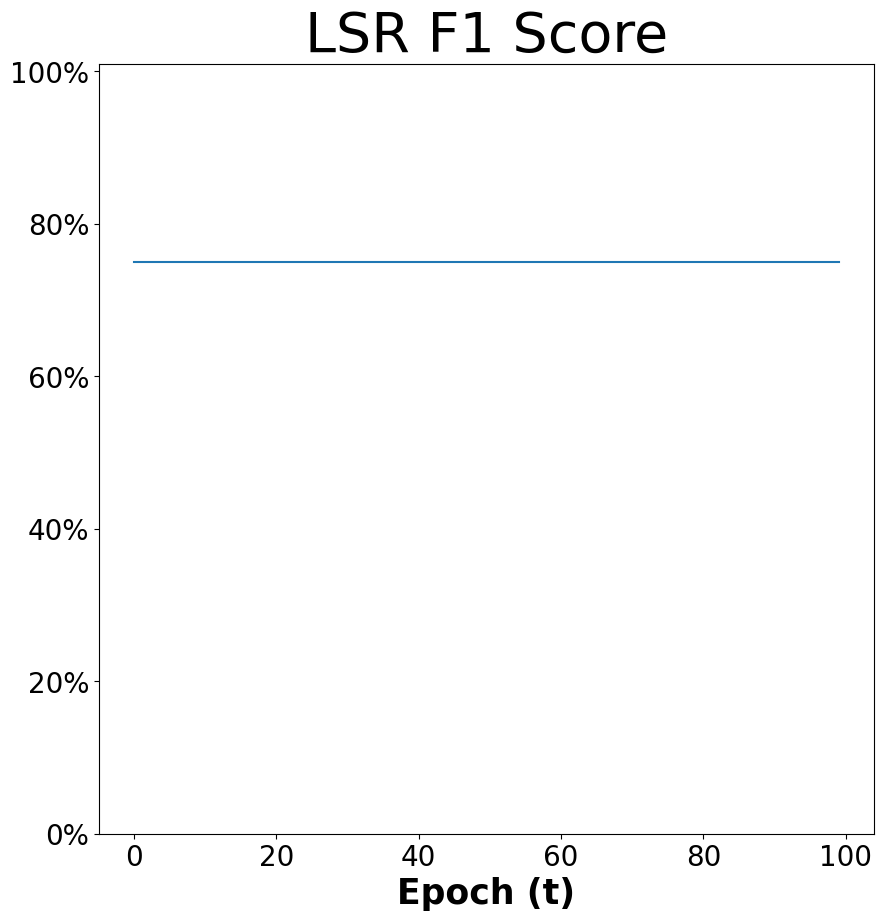

In [48]:
save_figs(lsr_glvq_acc, experiment, "LSR", learning_rate)

##### F1 Score

In [49]:
experiment = "experiment_2"

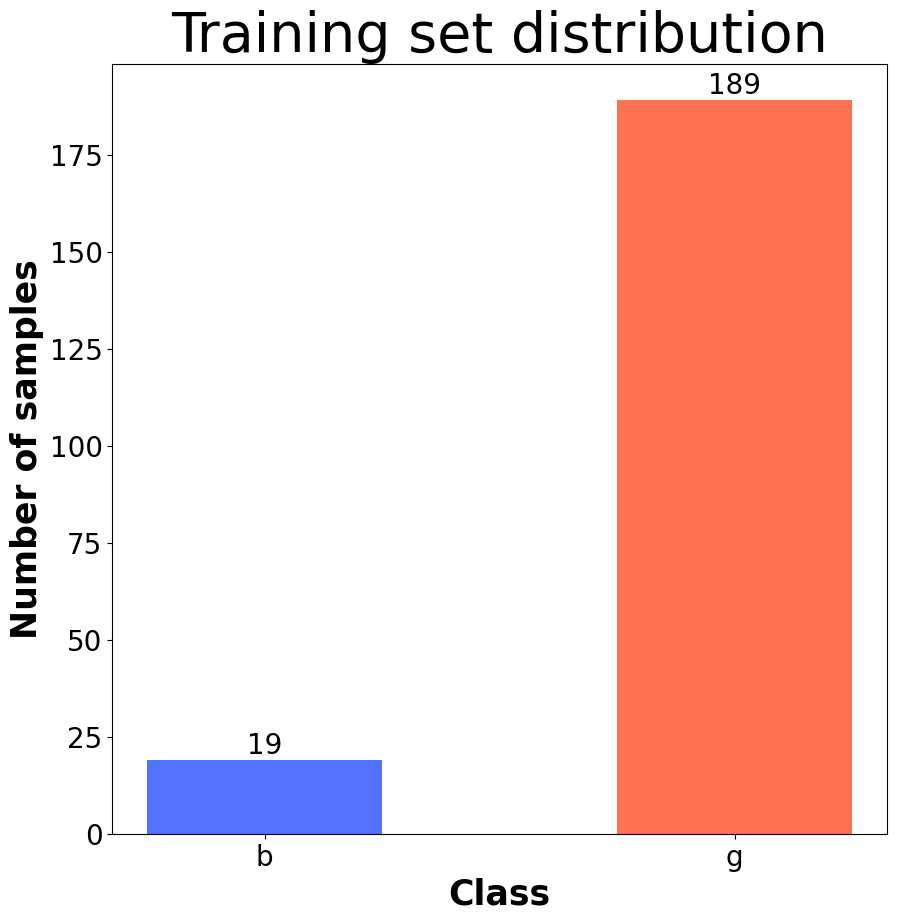

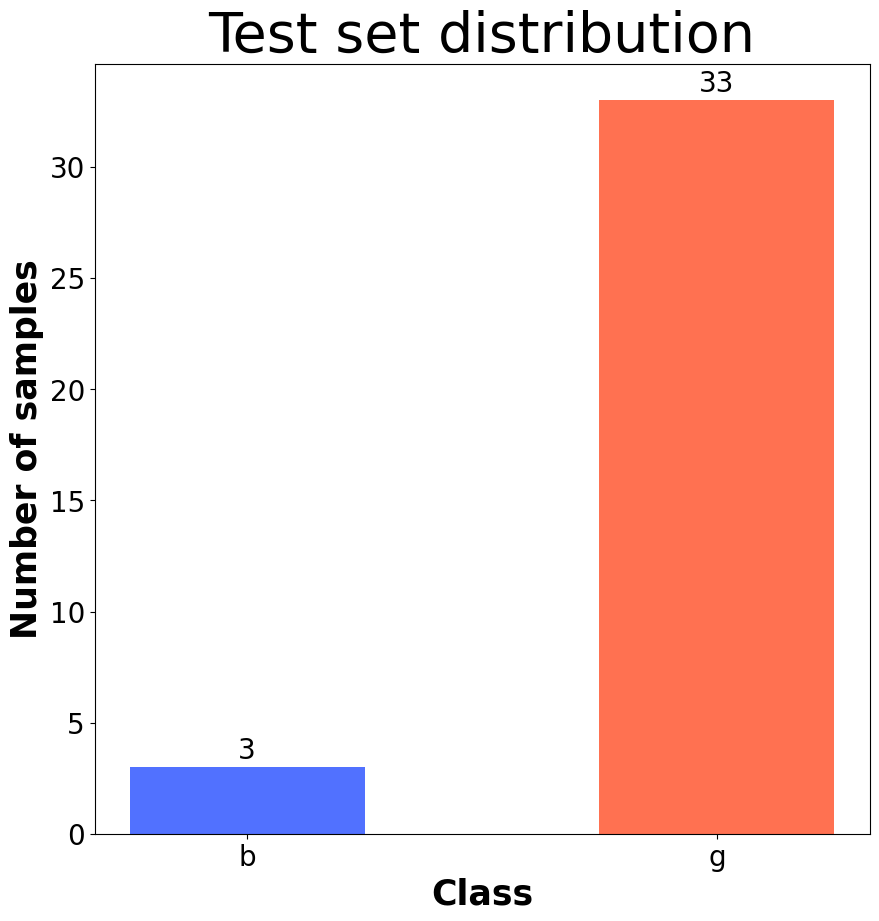

In [50]:
# Select 20% of #sample-1 as #sample-2
max_data = max(count) - num_prototypes
data_per_class = [int(max_data / 10), max_data]
test_percentage = 0.15
test_size = list(map(lambda data: int(data * test_percentage), data_per_class))
train_size = [data - test for data, test in zip(data_per_class, test_size)]
feature_f1 = copy.deepcopy(feature)
label_f1 = copy.deepcopy(label)
# Select test set
test_index = []
for j, class_name in enumerate(sample_number):
    index_i = np.where(label_f1 == class_name)
    index_i = list(index_i[0])
    index_i_sample = random.sample(index_i, test_size[j])
    test_index += index_i_sample
test_index.sort(reverse=True)
test_set_fscore = [(feature_f1[i], label_f1[i]) for i in test_index]
random.shuffle(test_set_fscore)
unique, counts = np.unique(label_f1[test_index], return_counts=True)
test_dist = dict(zip(unique, counts))
feature_f1 = np.delete(feature_f1, test_index, axis=0)
label_f1 = np.delete(label_f1, test_index, axis=0)

# Select train set
train_index = []
for j, class_name in enumerate(sample_number):
    index_i = np.where(label_f1 == class_name)
    index_i = list(index_i[0])
    index_i_sample = random.sample(index_i, train_size[j])
    train_index += index_i_sample
train_index.sort(reverse=True)
train_set_fscore = [(feature_f1[i], label_f1[i]) for i in train_index]
random.shuffle(train_set_fscore)
unique, counts = np.unique(label_f1[train_index], return_counts=True)
train_dist = dict(zip(unique, counts))

fig, ax = plt.subplots(figsize=(10, 10))
for i, (k, v) in enumerate(train_dist.items()):
    ax.bar(k, v, width=0.5, color=colors[i])
    plt.text(k, v + 0.1, str(v), ha="center", va="bottom", fontsize=20)
plt.title("Training set distribution", fontsize=40)
plt.xlabel("Class", fontsize=25, weight="bold")
plt.ylabel("Number of samples", fontsize=25, weight="bold")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
fig.savefig(img_folder + experiment + "/" +
            data_name + "/train_dist.png", dpi=200)


fig, ax = plt.subplots(figsize=(10, 10))
for i, (k, v) in enumerate(test_dist.items()):
    ax.bar(k, v, width=0.5, color=colors[i])
    plt.text(k, v + 0.1, str(v), ha="center", va="bottom", fontsize=20)
plt.title("Test set distribution", fontsize=40)
plt.xlabel("Class", fontsize=25, weight="bold")
plt.ylabel("Number of samples", fontsize=25, weight="bold")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
fig.savefig(img_folder + experiment + "/" +
            data_name + "/test_dist.png", dpi=200)


#### Train the Models

In [51]:
num_epochs = 100

##### GLVQ

##### 1-step lr =0.1

In [52]:
learning_rate = 0.1
oglvq_fscore = oglvq.OGLVQ(prototypes, learning_rate)
hist = oglvq_fscore.train(
    num_epochs, train_set_fscore, test_set_fscore, sample_number=train_dist
)


Epoch: 1, Loss: 88.6978, Accuracy: 75.00 %, F_1_score: 80.17 %
Epoch: 11, Loss: 70.7153, Accuracy: 91.67 %, F_1_score: 86.91 %
Epoch: 21, Loss: 68.2235, Accuracy: 91.67 %, F_1_score: 86.91 %
Epoch: 31, Loss: 67.1828, Accuracy: 91.67 %, F_1_score: 86.91 %
Epoch: 41, Loss: 66.6325, Accuracy: 91.67 %, F_1_score: 86.91 %
Epoch: 51, Loss: 66.2936, Accuracy: 91.67 %, F_1_score: 86.91 %
Epoch: 61, Loss: 66.0581, Accuracy: 91.67 %, F_1_score: 86.91 %
Epoch: 71, Loss: 65.8851, Accuracy: 91.67 %, F_1_score: 86.91 %
Epoch: 81, Loss: 65.7498, Accuracy: 91.67 %, F_1_score: 86.91 %
Epoch: 91, Loss: 65.6459, Accuracy: 91.67 %, F_1_score: 86.91 %


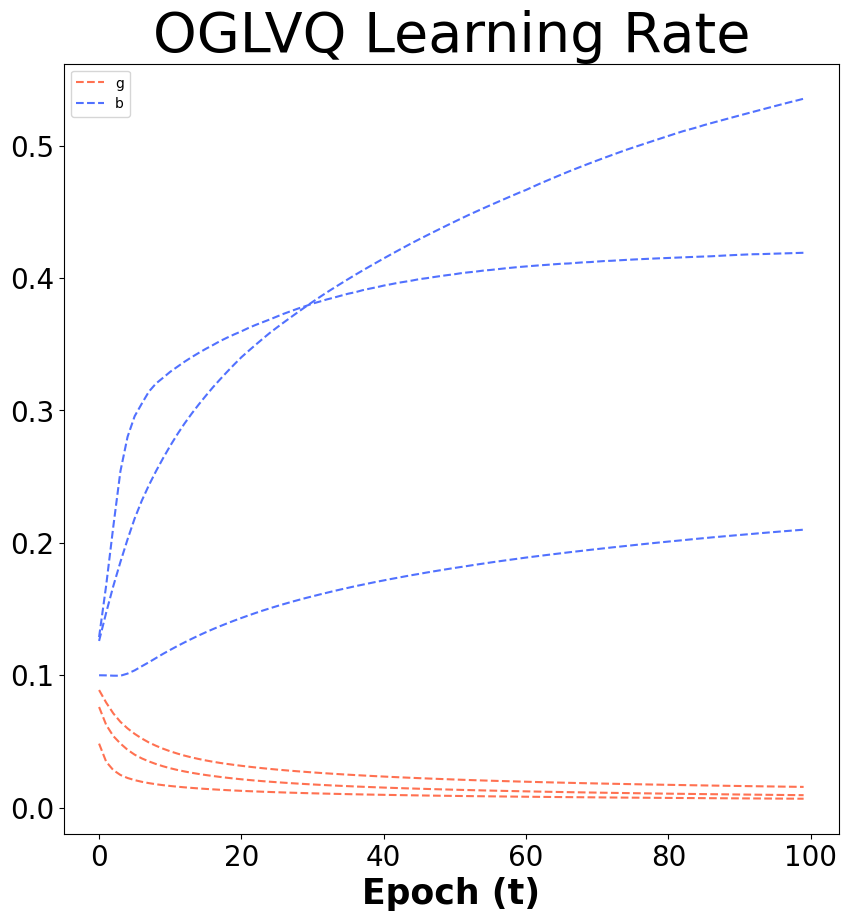

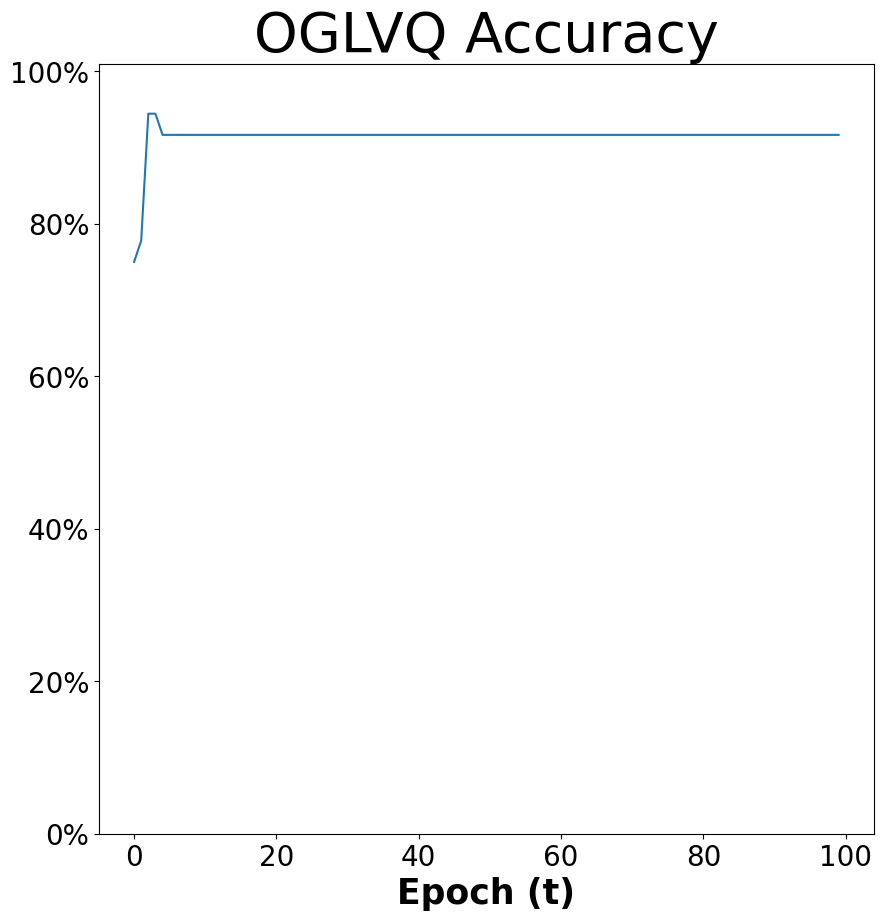

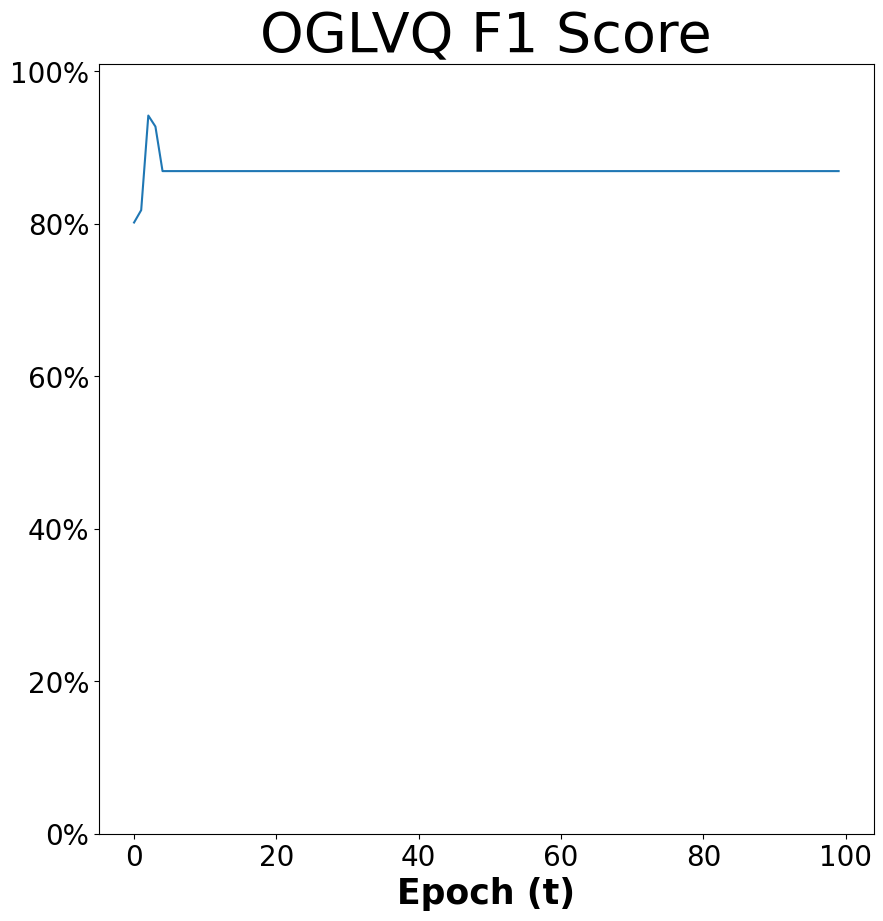

In [53]:
save_figs(oglvq_fscore, experiment, "OGLVQ", learning_rate)

##### 2-step lr = 0.03

In [54]:
learning_rate = 0.03
oglvq_fscore = oglvq.OGLVQ(
    prototypes,
    learning_rate,
)
hist = oglvq_fscore.train(
    num_epochs, train_set_fscore, test_set_fscore, sample_number=train_dist
)


Epoch: 1, Loss: 90.5454, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 11, Loss: 78.2666, Accuracy: 94.44 %, F_1_score: 94.20 %
Epoch: 21, Loss: 73.3036, Accuracy: 91.67 %, F_1_score: 86.91 %
Epoch: 31, Loss: 71.3478, Accuracy: 91.67 %, F_1_score: 86.91 %
Epoch: 41, Loss: 70.1191, Accuracy: 91.67 %, F_1_score: 86.91 %
Epoch: 51, Loss: 69.2732, Accuracy: 91.67 %, F_1_score: 86.91 %
Epoch: 61, Loss: 68.6510, Accuracy: 91.67 %, F_1_score: 86.91 %
Epoch: 71, Loss: 68.1616, Accuracy: 91.67 %, F_1_score: 86.91 %
Epoch: 81, Loss: 67.7826, Accuracy: 91.67 %, F_1_score: 86.91 %
Epoch: 91, Loss: 67.4833, Accuracy: 91.67 %, F_1_score: 86.91 %


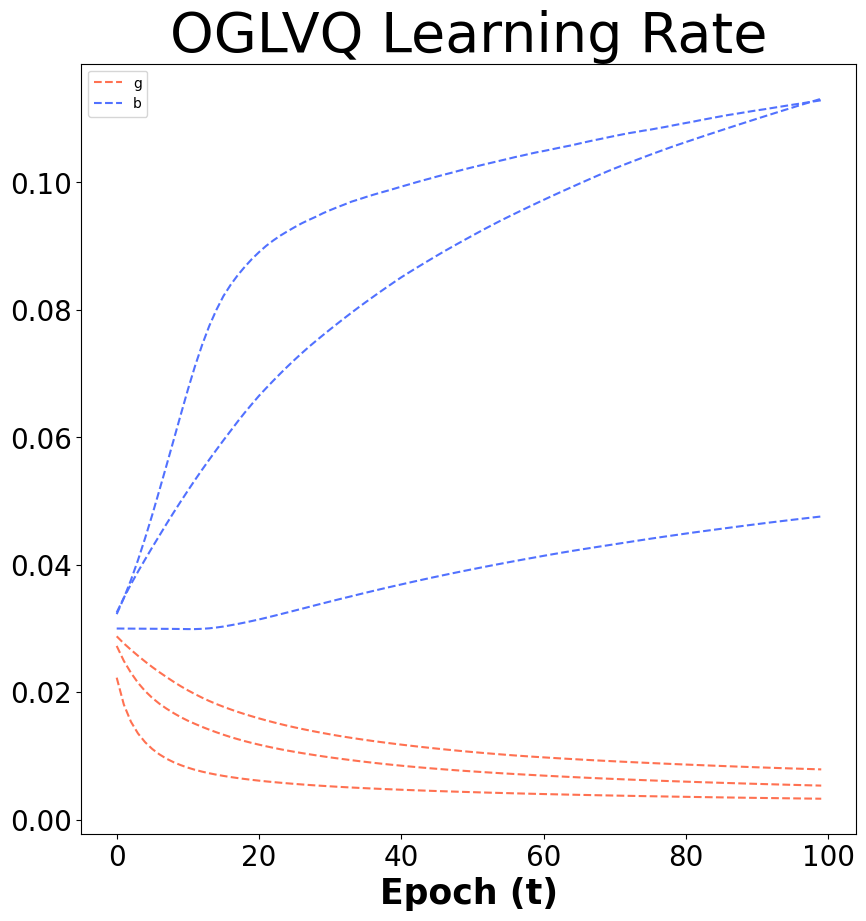

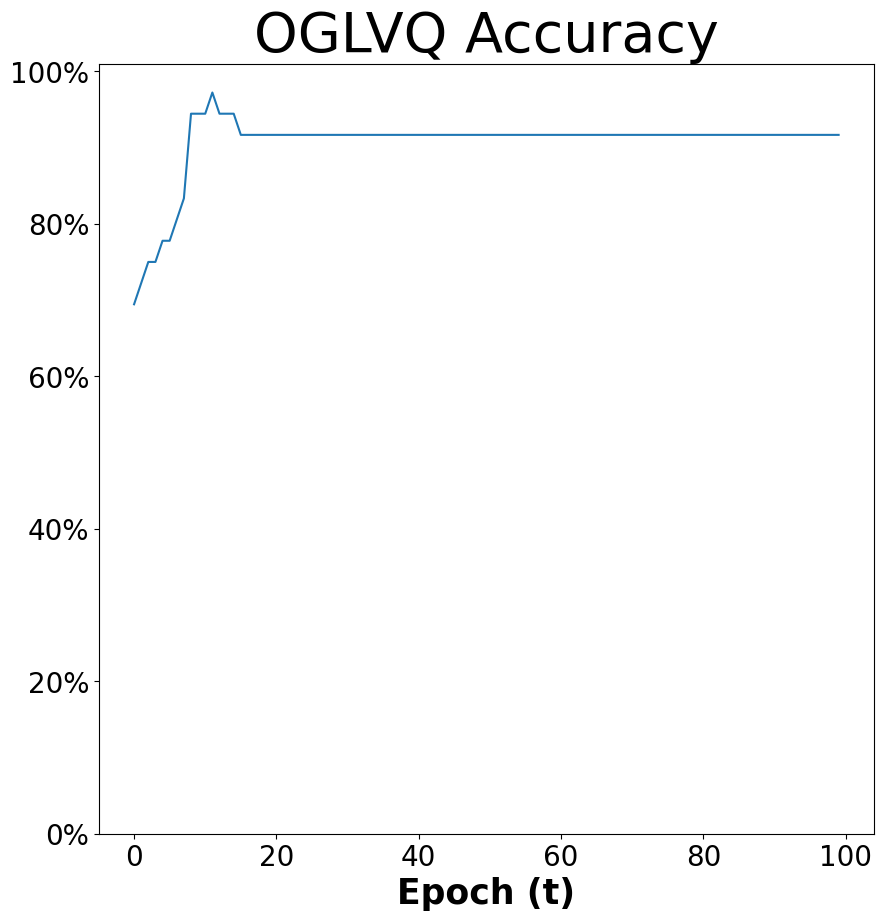

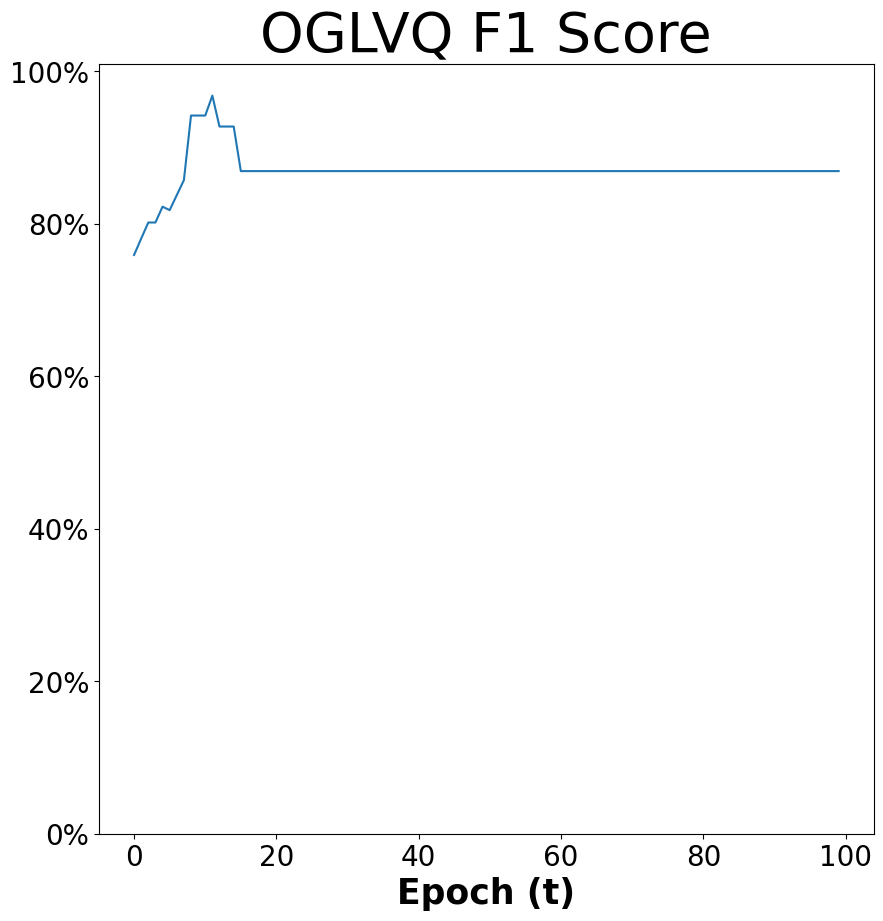

In [55]:
save_figs(oglvq_fscore, experiment, "OGLVQ", learning_rate)

##### 3-step lr = 0.01

In [56]:
learning_rate = 0.01
oglvq_fscore = oglvq.OGLVQ(prototypes, learning_rate)
hist = oglvq_fscore.train(
    num_epochs, train_set_fscore, test_set_fscore, sample_number=train_dist
)


Epoch: 1, Loss: 91.2380, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 11, Loss: 86.0560, Accuracy: 75.00 %, F_1_score: 80.17 %
Epoch: 21, Loss: 82.1430, Accuracy: 80.56 %, F_1_score: 83.76 %
Epoch: 31, Loss: 78.5849, Accuracy: 94.44 %, F_1_score: 94.20 %
Epoch: 41, Loss: 75.9251, Accuracy: 94.44 %, F_1_score: 92.76 %
Epoch: 51, Loss: 74.4318, Accuracy: 91.67 %, F_1_score: 86.91 %
Epoch: 61, Loss: 73.3974, Accuracy: 91.67 %, F_1_score: 86.91 %
Epoch: 71, Loss: 72.5971, Accuracy: 91.67 %, F_1_score: 86.91 %
Epoch: 81, Loss: 71.9458, Accuracy: 91.67 %, F_1_score: 86.91 %
Epoch: 91, Loss: 71.3994, Accuracy: 91.67 %, F_1_score: 86.91 %


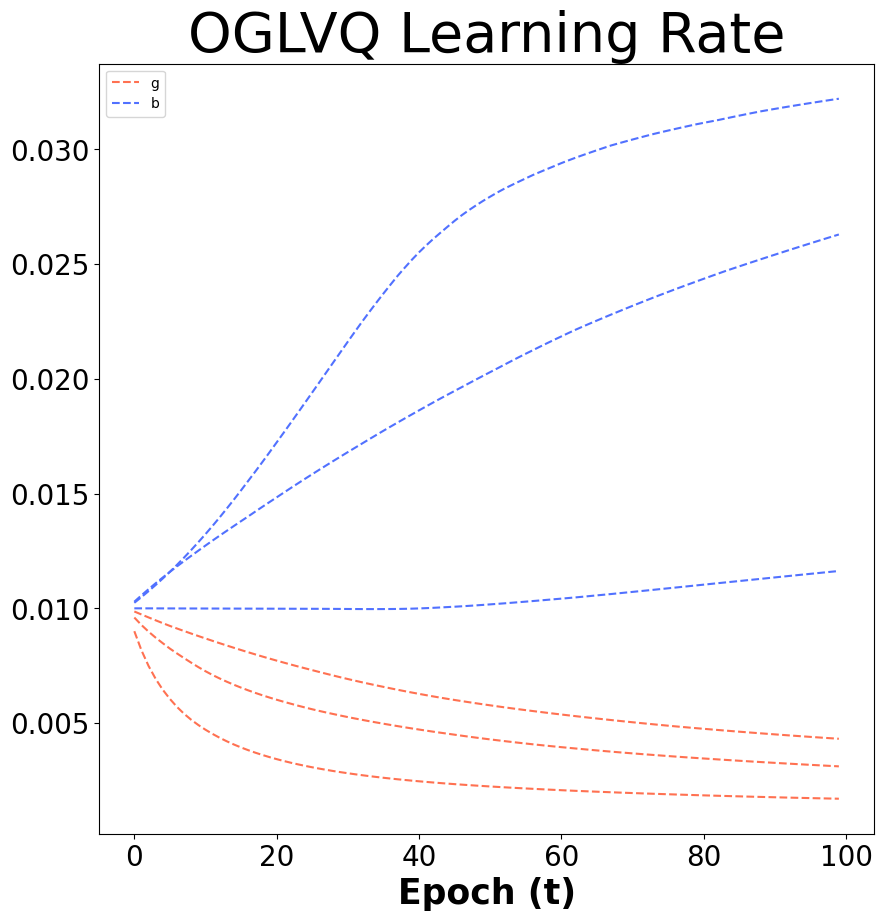

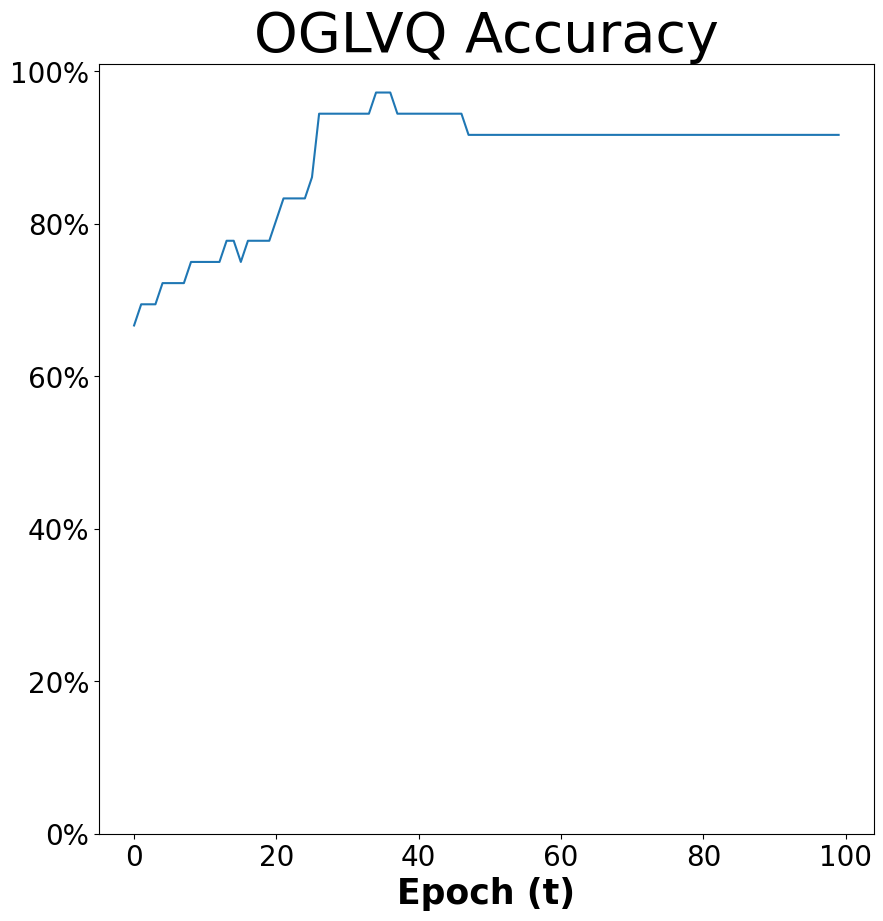

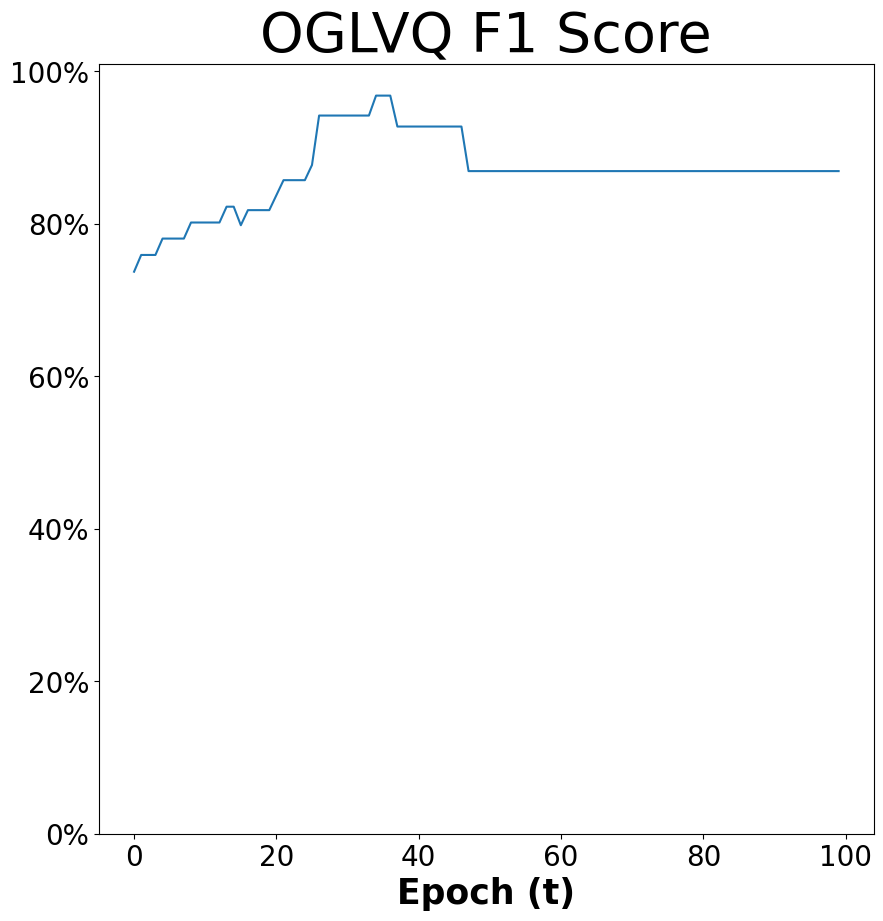

In [57]:
save_figs(oglvq_fscore, experiment, "OGLVQ", learning_rate)

##### CP

##### 1-step lr = 0.1

In [58]:
learning_rate = 0.1
cp_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = cp_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.conditional_probability,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4403, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 11, Loss: 0.4403, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 21, Loss: 0.4402, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 31, Loss: 0.4402, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 41, Loss: 0.4404, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 51, Loss: 0.4411, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 61, Loss: 0.4420, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 71, Loss: 0.4429, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 81, Loss: 0.4451, Accuracy: 72.22 %, F_1_score: 78.06 %
Epoch: 91, Loss: 0.4507, Accuracy: 69.44 %, F_1_score: 75.92 %


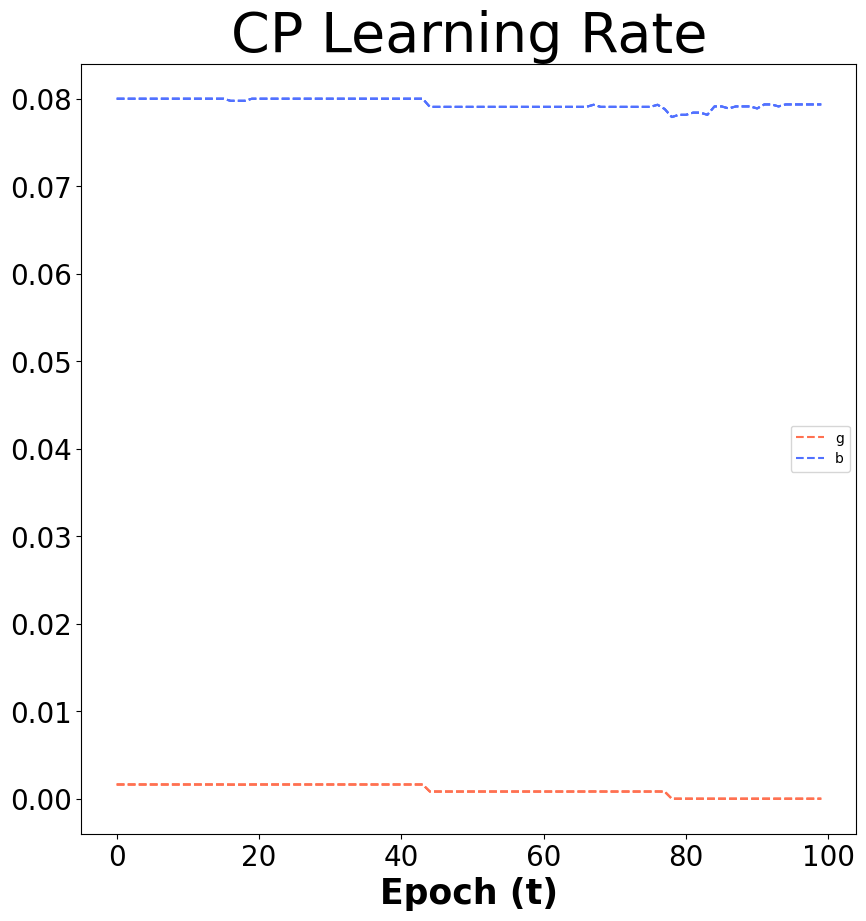

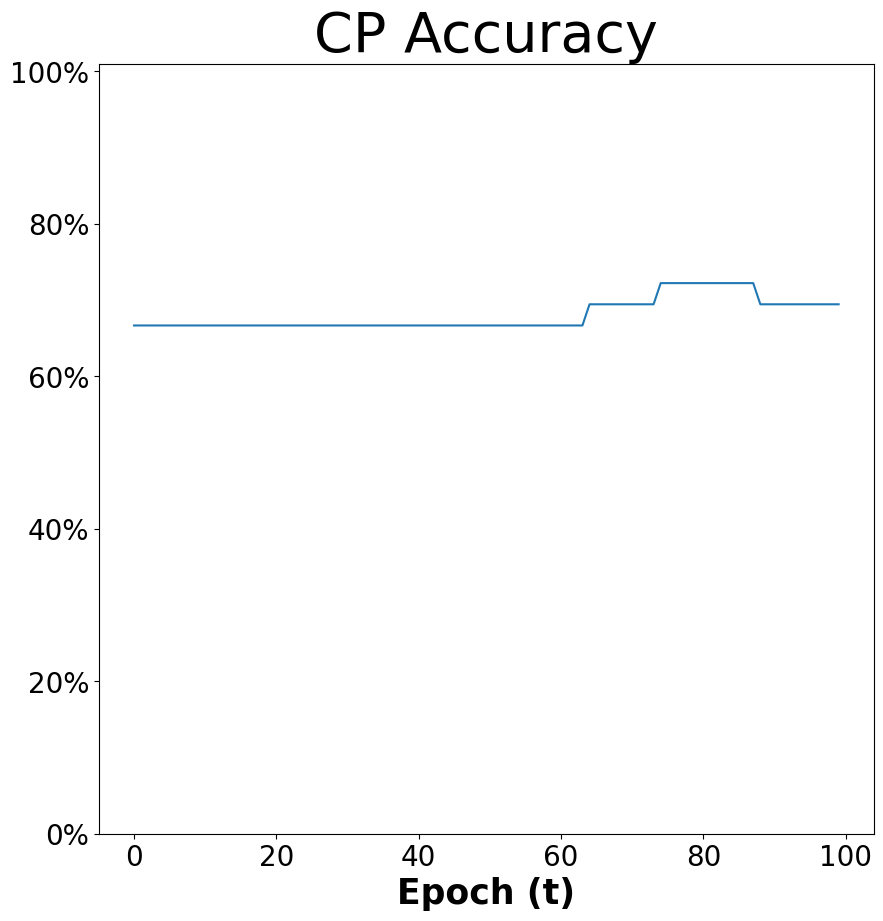

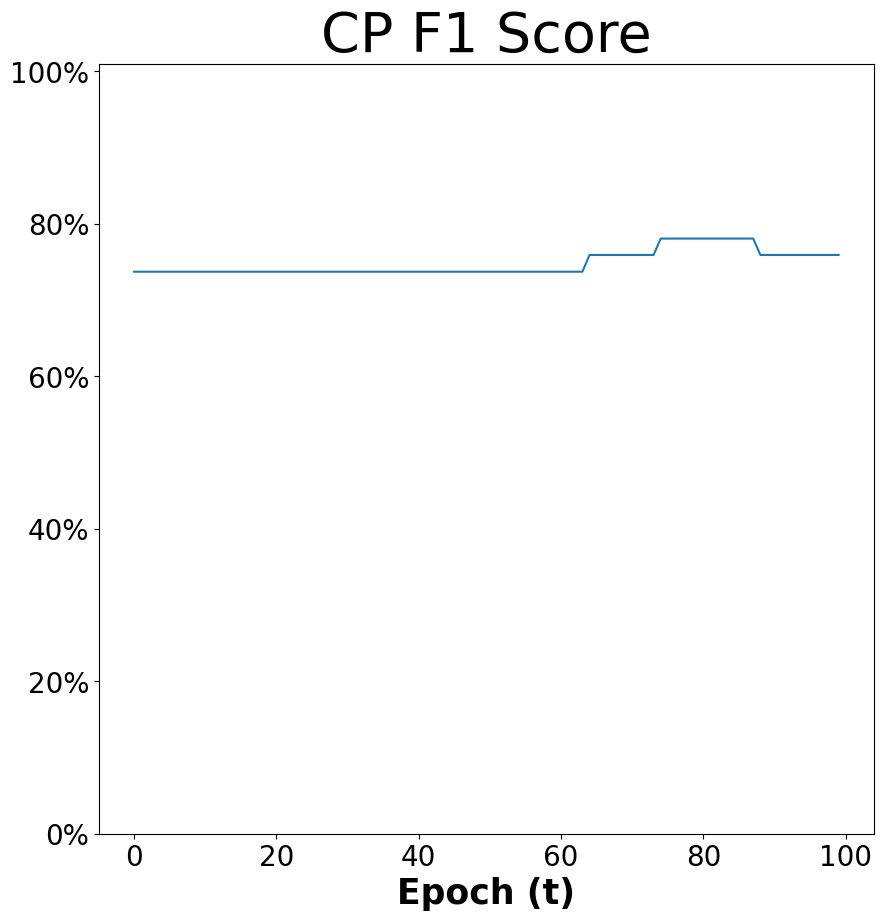

In [59]:
save_figs(cp_glvq_fscore, experiment, "CP", learning_rate)

##### 2-step lr = 0.03

In [60]:
learning_rate = 0.03
cp_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = cp_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.conditional_probability,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4405, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 11, Loss: 0.4405, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 21, Loss: 0.4406, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 31, Loss: 0.4405, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 41, Loss: 0.4405, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 51, Loss: 0.4404, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 61, Loss: 0.4404, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 71, Loss: 0.4404, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 81, Loss: 0.4404, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 91, Loss: 0.4403, Accuracy: 66.67 %, F_1_score: 73.72 %


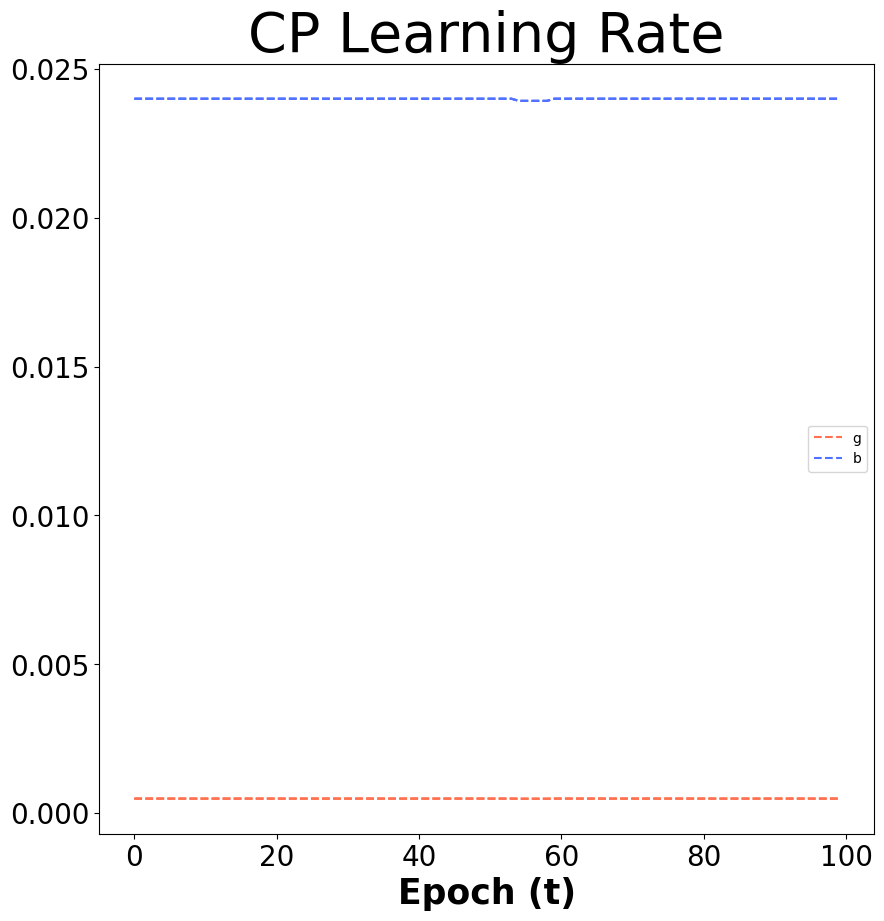

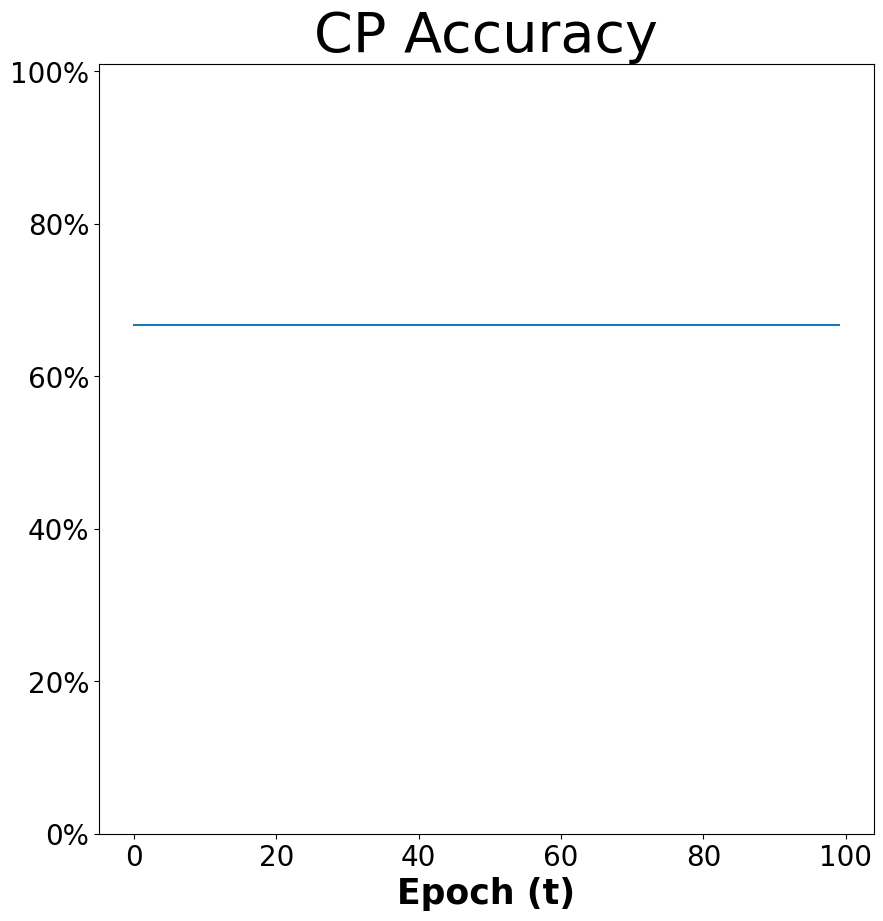

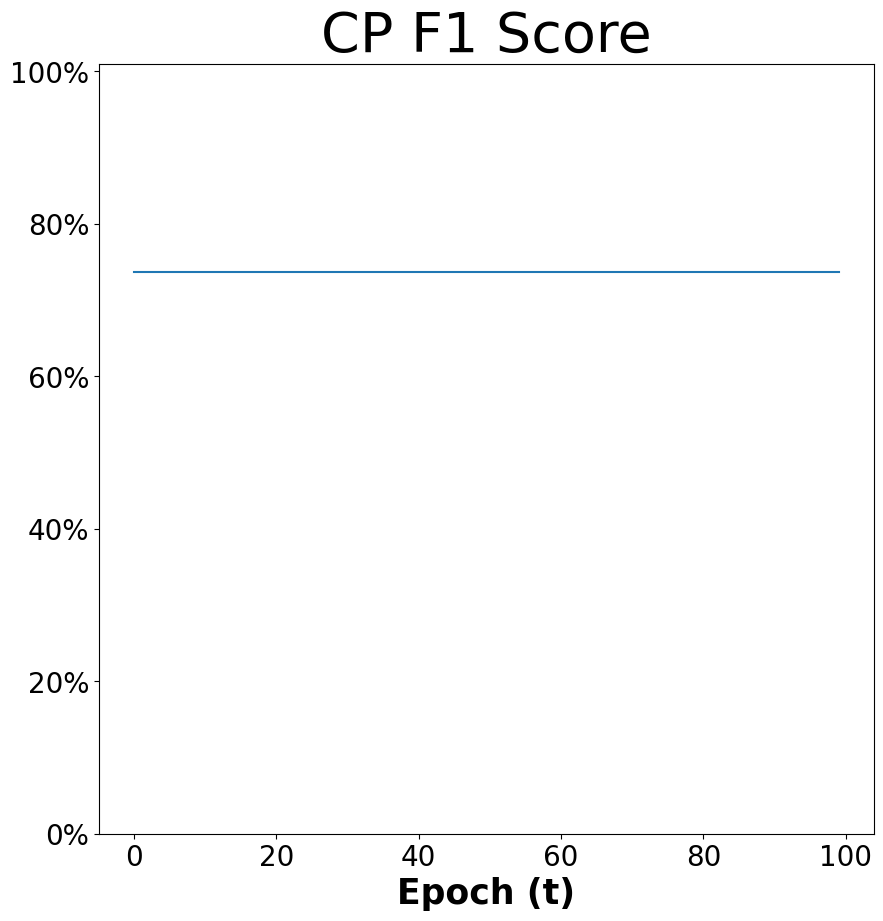

In [61]:
save_figs(cp_glvq_fscore, experiment, "CP", learning_rate)

##### 3-step lr = 0.01

In [62]:
learning_rate = 0.01
cp_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = cp_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.conditional_probability,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4405, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 11, Loss: 0.4405, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 21, Loss: 0.4405, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 31, Loss: 0.4406, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 41, Loss: 0.4406, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 51, Loss: 0.4406, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 61, Loss: 0.4406, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 71, Loss: 0.4406, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 81, Loss: 0.4406, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 91, Loss: 0.4405, Accuracy: 66.67 %, F_1_score: 73.72 %


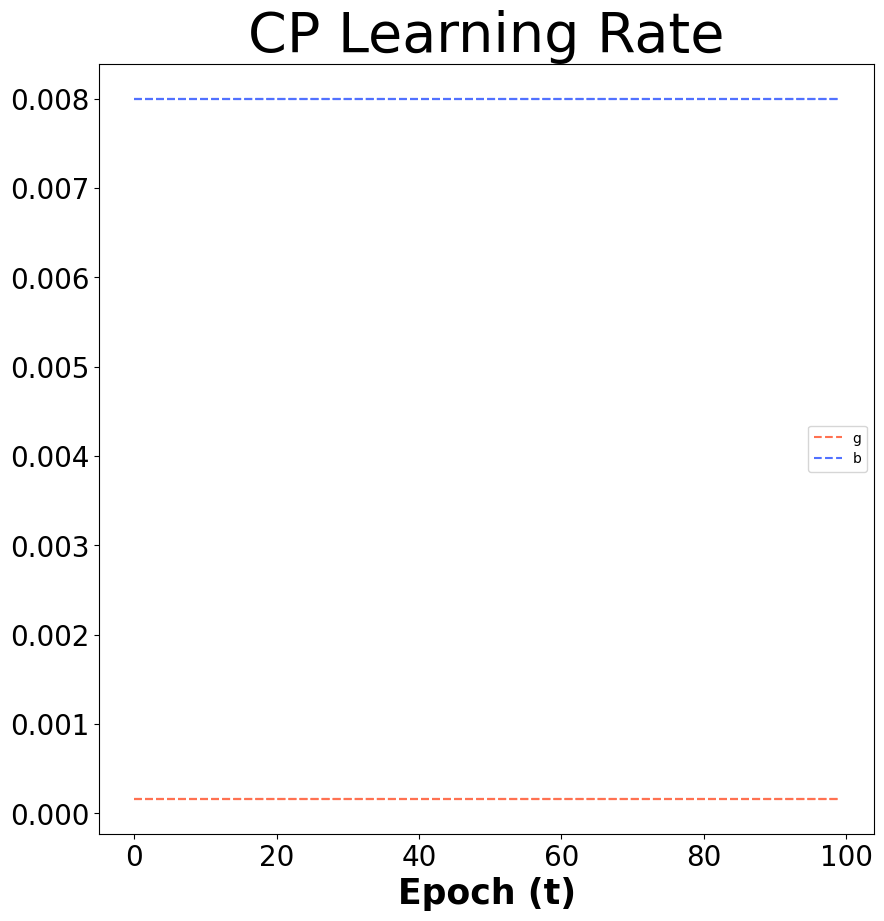

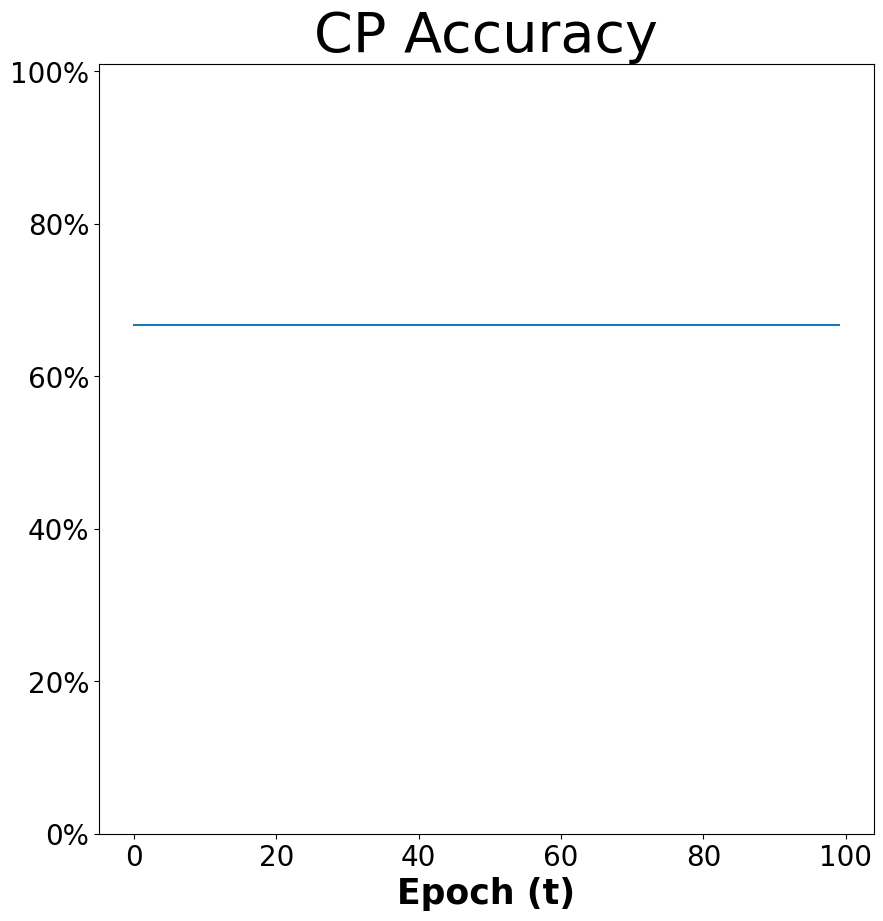

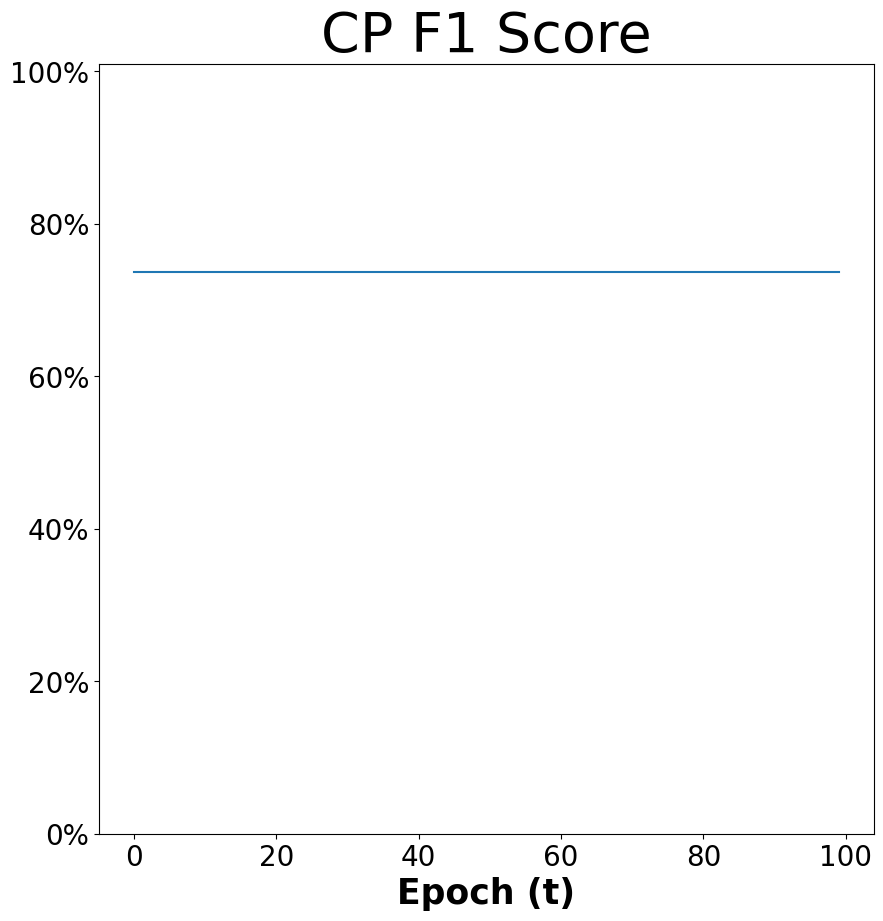

In [63]:
save_figs(cp_glvq_fscore, experiment, "CP", learning_rate)

##### DFH

##### 1-step lr = 0.1

In [64]:
learning_rate = 0.1
dfh_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = dfh_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.dual_factor_heuristic,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4387, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 11, Loss: 0.4206, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 21, Loss: 0.4094, Accuracy: 77.78 %, F_1_score: 82.25 %
Epoch: 31, Loss: 0.4006, Accuracy: 77.78 %, F_1_score: 82.25 %
Epoch: 41, Loss: 0.3971, Accuracy: 80.56 %, F_1_score: 84.30 %
Epoch: 51, Loss: 0.3946, Accuracy: 83.33 %, F_1_score: 86.35 %
Epoch: 61, Loss: 0.3927, Accuracy: 83.33 %, F_1_score: 86.35 %
Epoch: 71, Loss: 0.3916, Accuracy: 83.33 %, F_1_score: 86.35 %
Epoch: 81, Loss: 0.3908, Accuracy: 83.33 %, F_1_score: 86.35 %
Epoch: 91, Loss: 0.3898, Accuracy: 83.33 %, F_1_score: 86.35 %


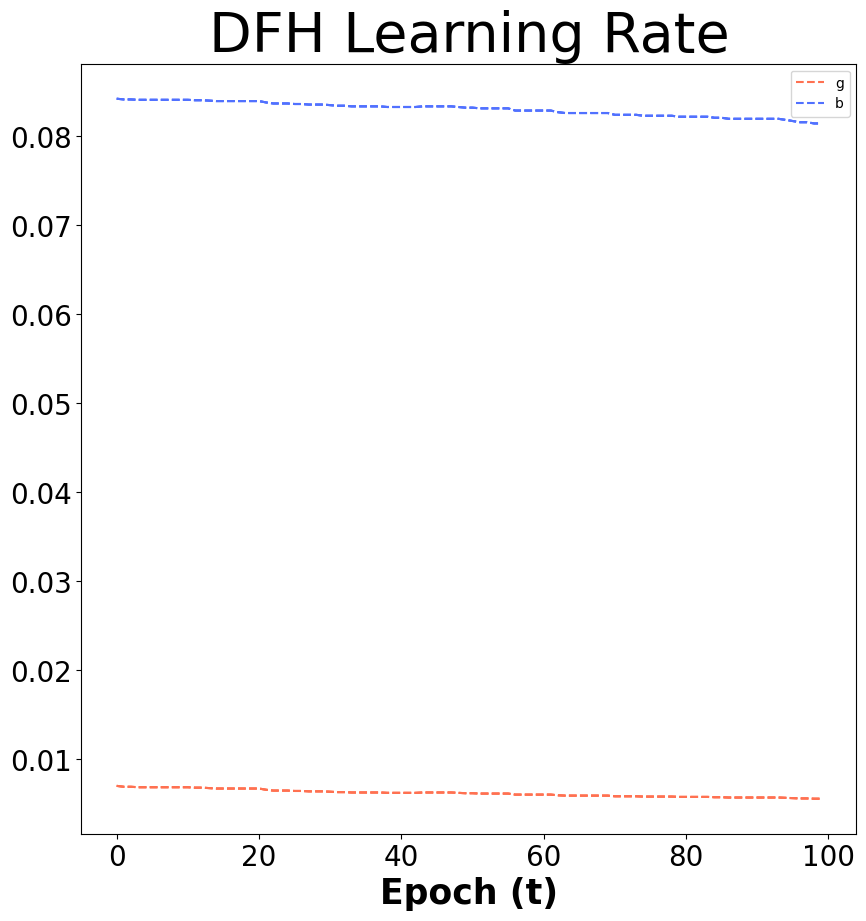

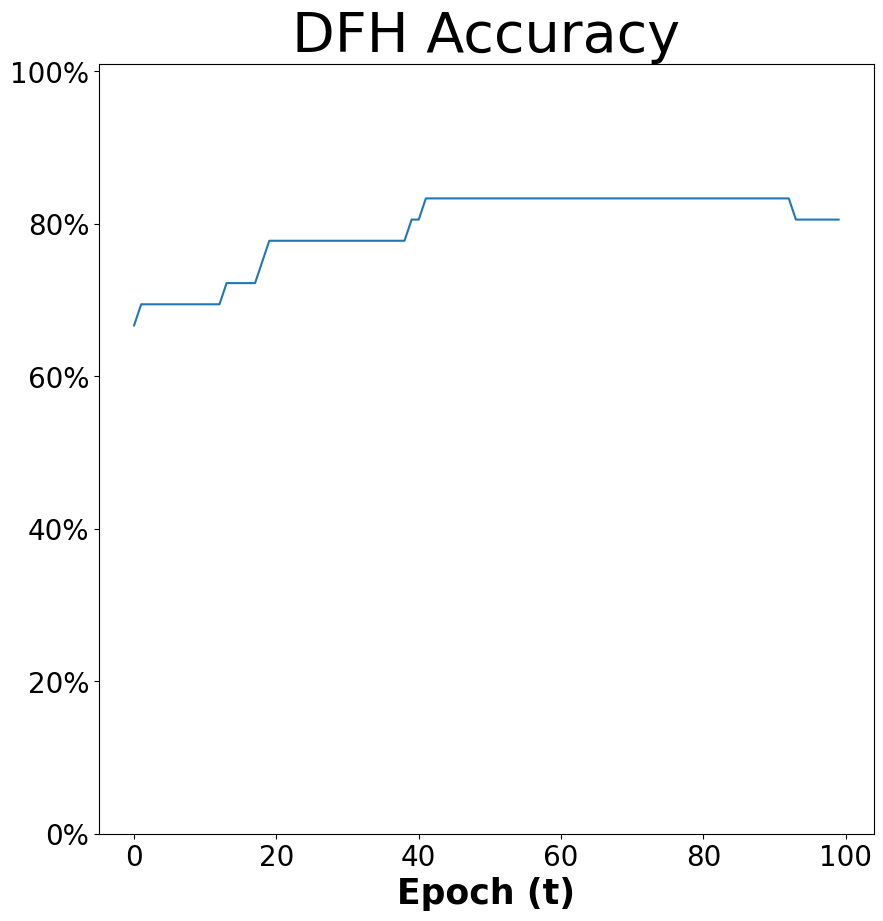

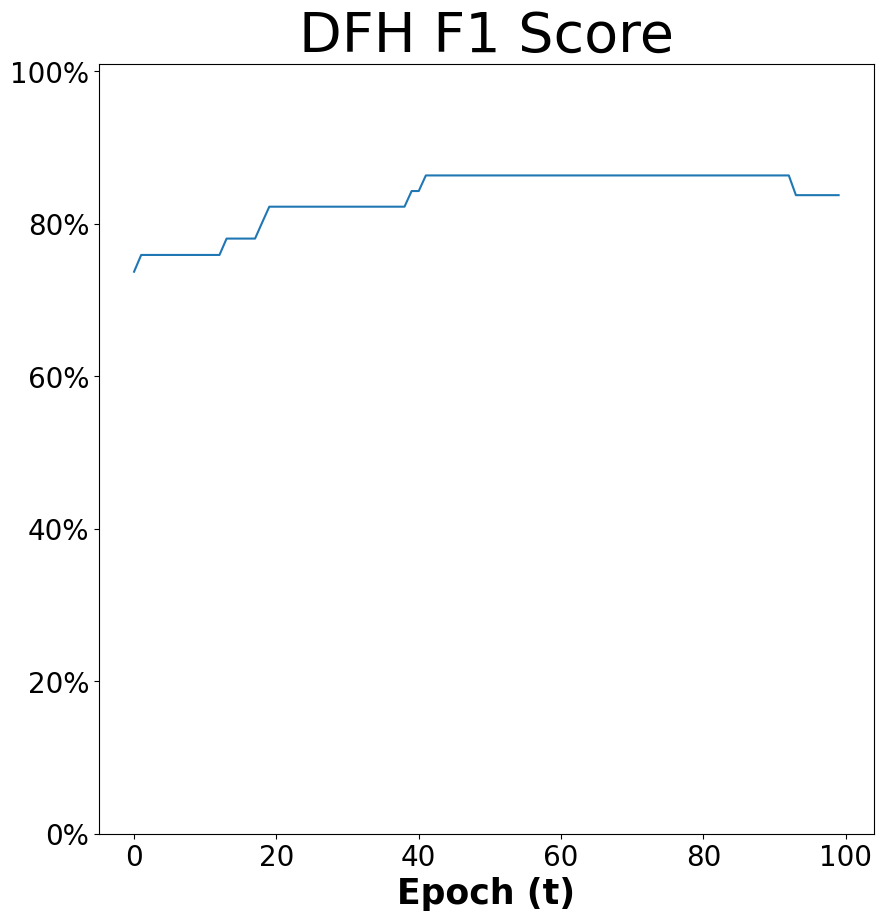

In [65]:
save_figs(dfh_glvq_fscore, experiment, "DFH", learning_rate)

##### 2-step lr = 0.03

In [66]:
learning_rate = 0.03
dfh_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = dfh_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.dual_factor_heuristic,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4400, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 11, Loss: 0.4329, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 21, Loss: 0.4273, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 31, Loss: 0.4227, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 41, Loss: 0.4187, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 51, Loss: 0.4151, Accuracy: 72.22 %, F_1_score: 78.06 %
Epoch: 61, Loss: 0.4119, Accuracy: 72.22 %, F_1_score: 78.06 %
Epoch: 71, Loss: 0.4089, Accuracy: 77.78 %, F_1_score: 82.25 %
Epoch: 81, Loss: 0.4062, Accuracy: 77.78 %, F_1_score: 82.25 %
Epoch: 91, Loss: 0.4036, Accuracy: 77.78 %, F_1_score: 82.25 %


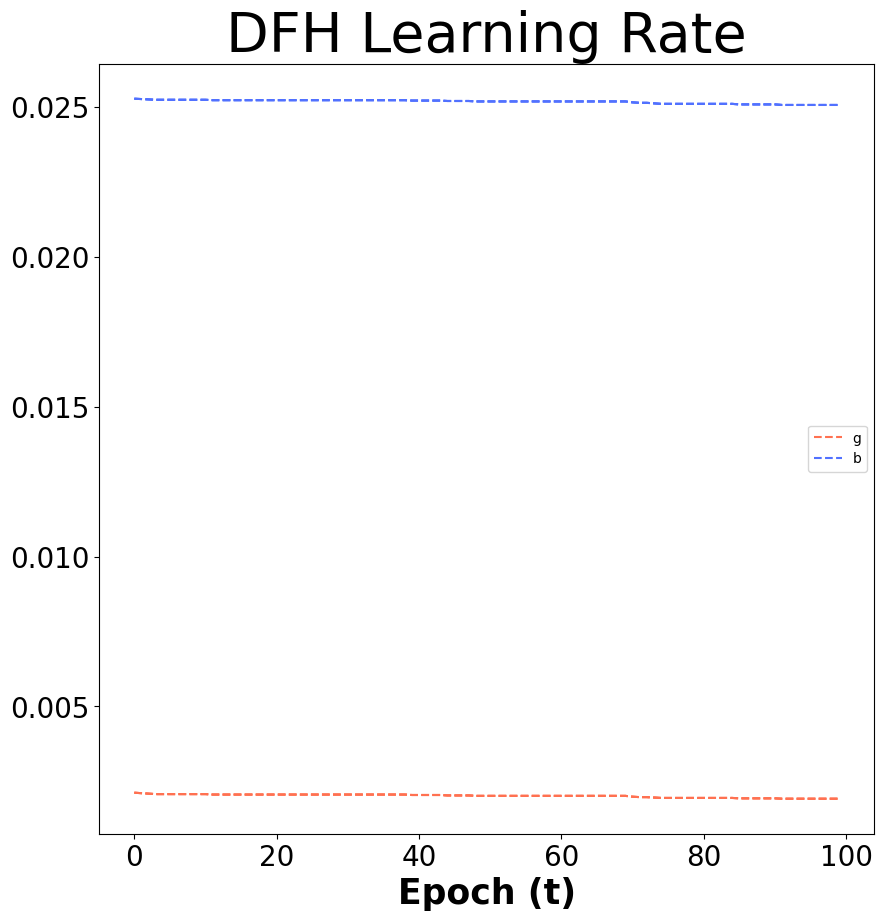

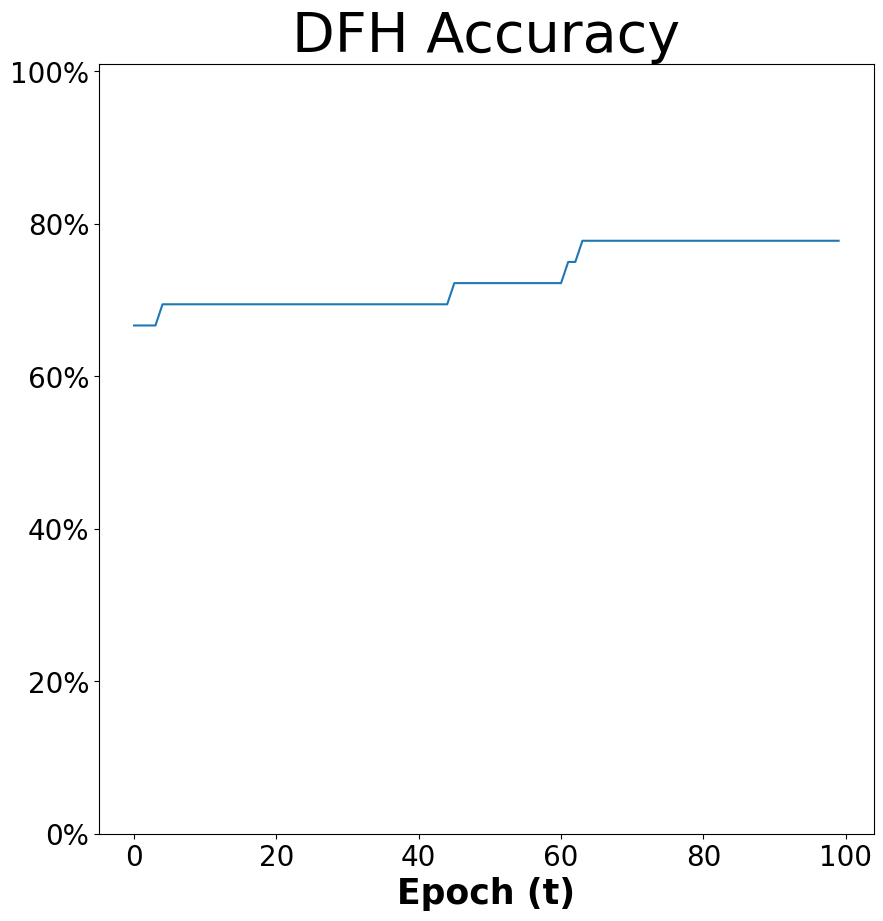

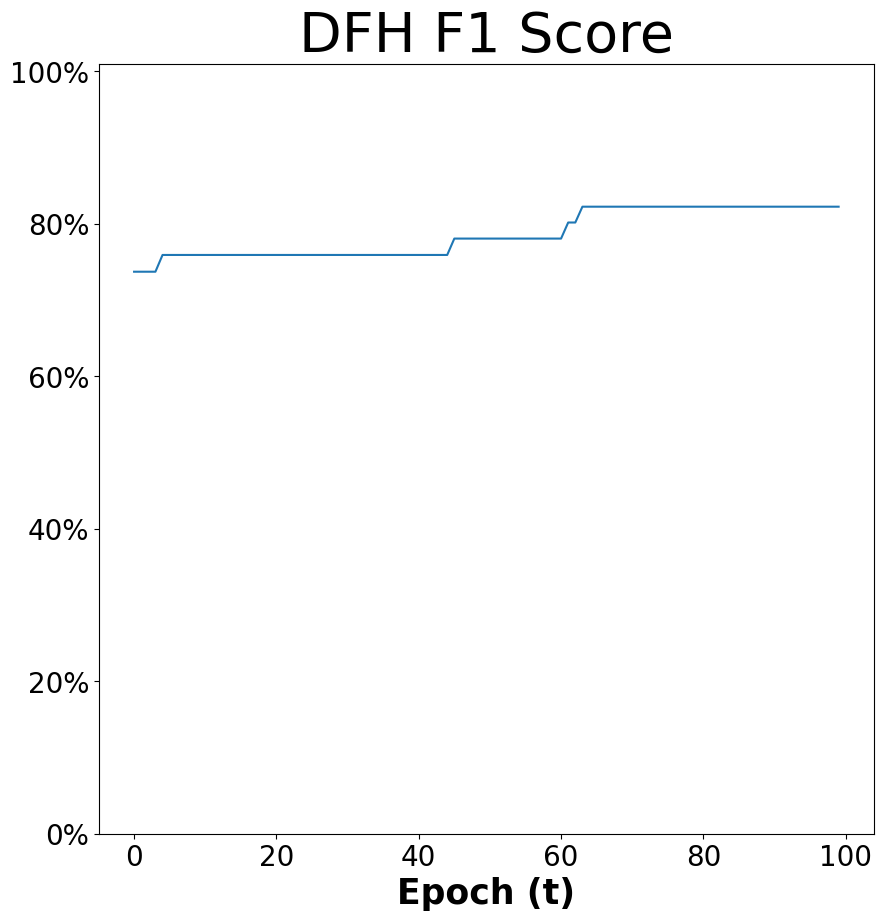

In [67]:
save_figs(dfh_glvq_fscore, experiment, "DFH", learning_rate)

##### 3-step lr = 0.01

In [68]:
learning_rate = 0.01
dfh_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = dfh_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.dual_factor_heuristic,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4404, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 11, Loss: 0.4377, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 21, Loss: 0.4354, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 31, Loss: 0.4332, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 41, Loss: 0.4312, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 51, Loss: 0.4293, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 61, Loss: 0.4276, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 71, Loss: 0.4259, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 81, Loss: 0.4244, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 91, Loss: 0.4229, Accuracy: 69.44 %, F_1_score: 75.92 %


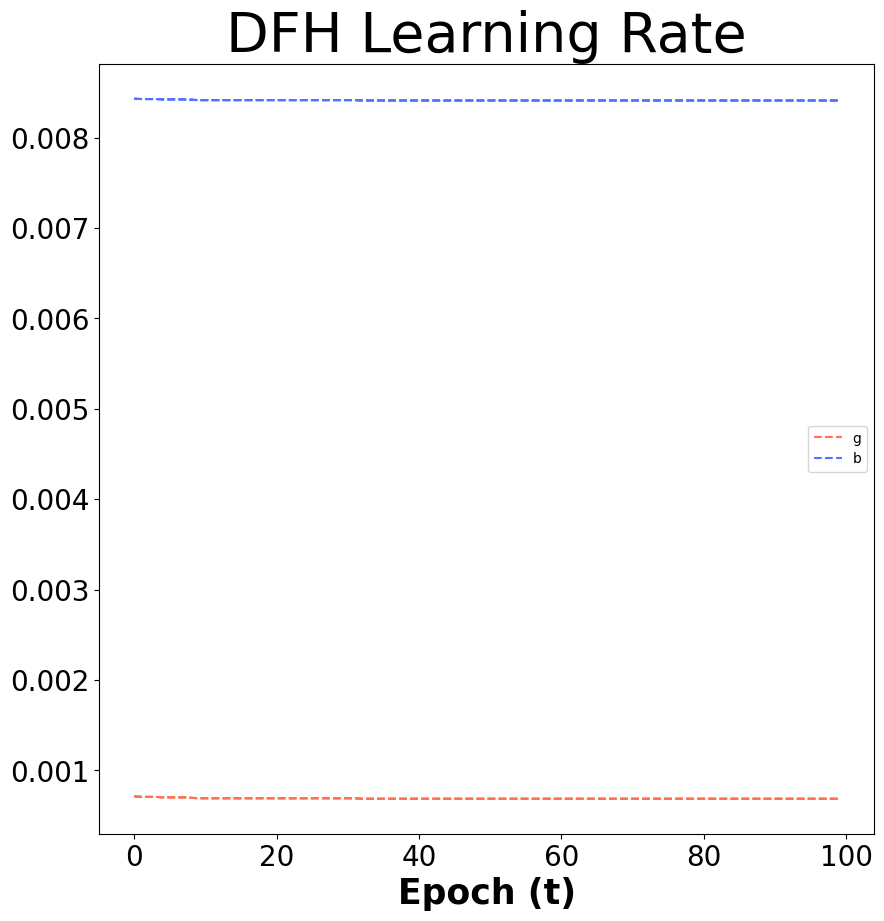

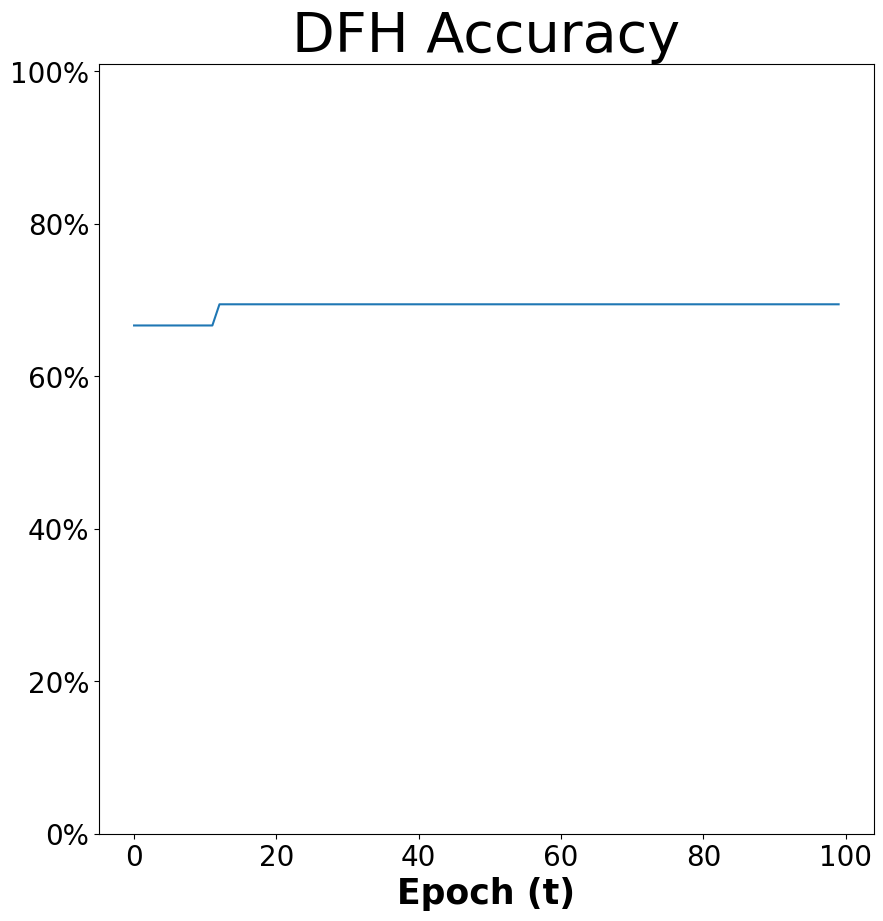

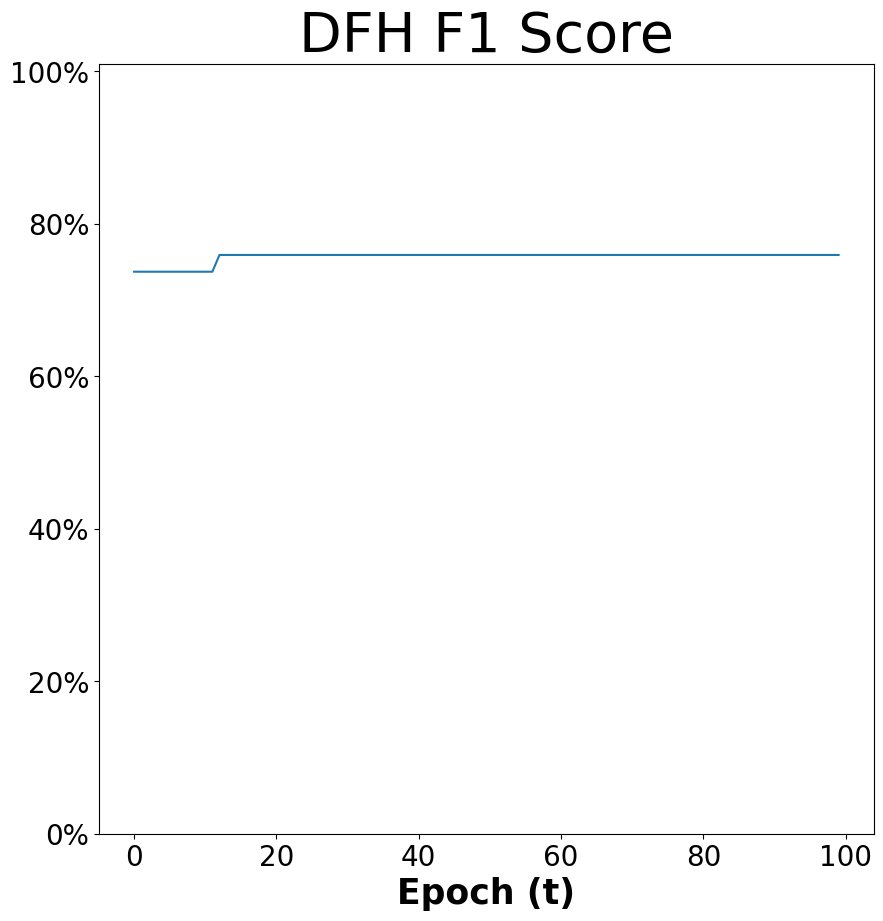

In [69]:
save_figs(dfh_glvq_fscore, experiment, "DFH", learning_rate)

##### MS

##### 1-step lr = 0.1

In [70]:
learning_rate = 0.1
ms_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = ms_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.middle_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4373, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 11, Loss: 0.4091, Accuracy: 75.00 %, F_1_score: 80.17 %
Epoch: 21, Loss: 0.3939, Accuracy: 83.33 %, F_1_score: 86.35 %
Epoch: 31, Loss: 0.3870, Accuracy: 83.33 %, F_1_score: 85.73 %
Epoch: 41, Loss: 0.3829, Accuracy: 86.11 %, F_1_score: 87.71 %
Epoch: 51, Loss: 0.3797, Accuracy: 88.89 %, F_1_score: 89.75 %
Epoch: 61, Loss: 0.3771, Accuracy: 91.67 %, F_1_score: 91.89 %
Epoch: 71, Loss: 0.3751, Accuracy: 91.67 %, F_1_score: 91.89 %
Epoch: 81, Loss: 0.3734, Accuracy: 91.67 %, F_1_score: 91.89 %
Epoch: 91, Loss: 0.3719, Accuracy: 91.67 %, F_1_score: 91.89 %


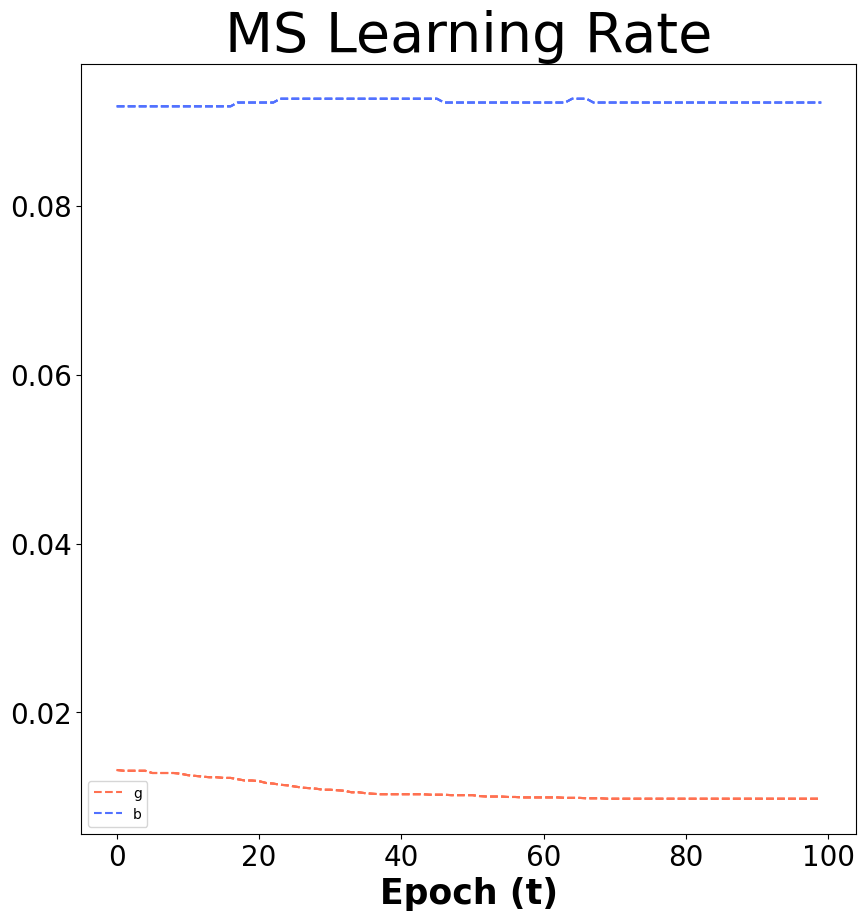

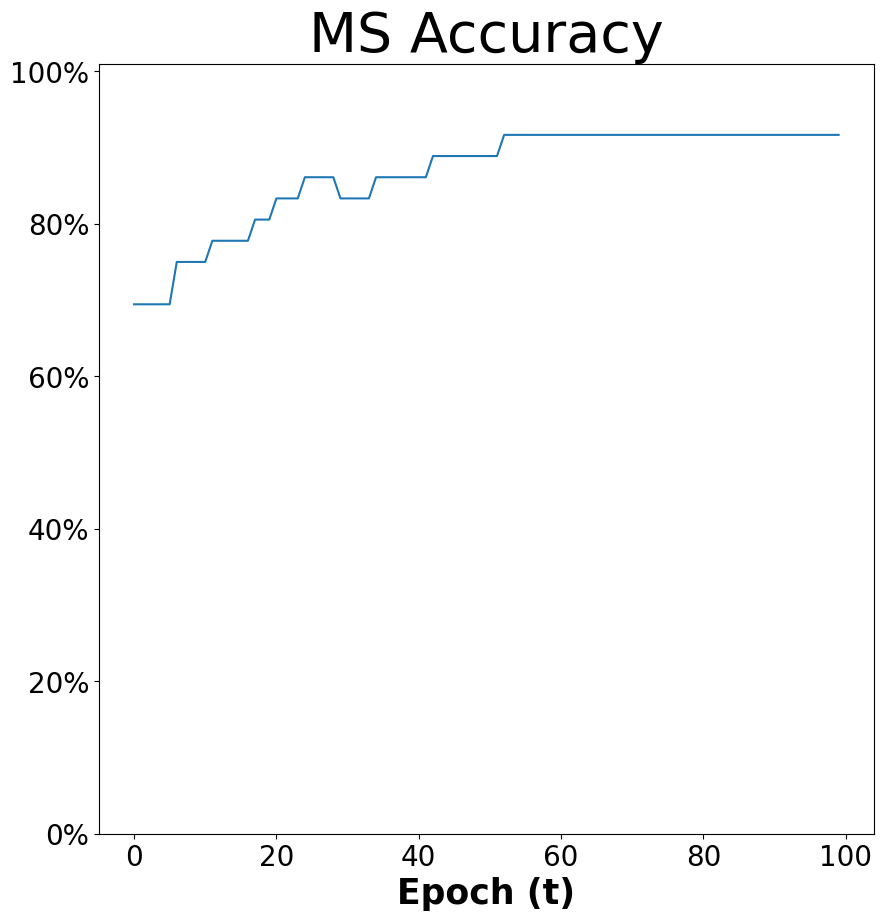

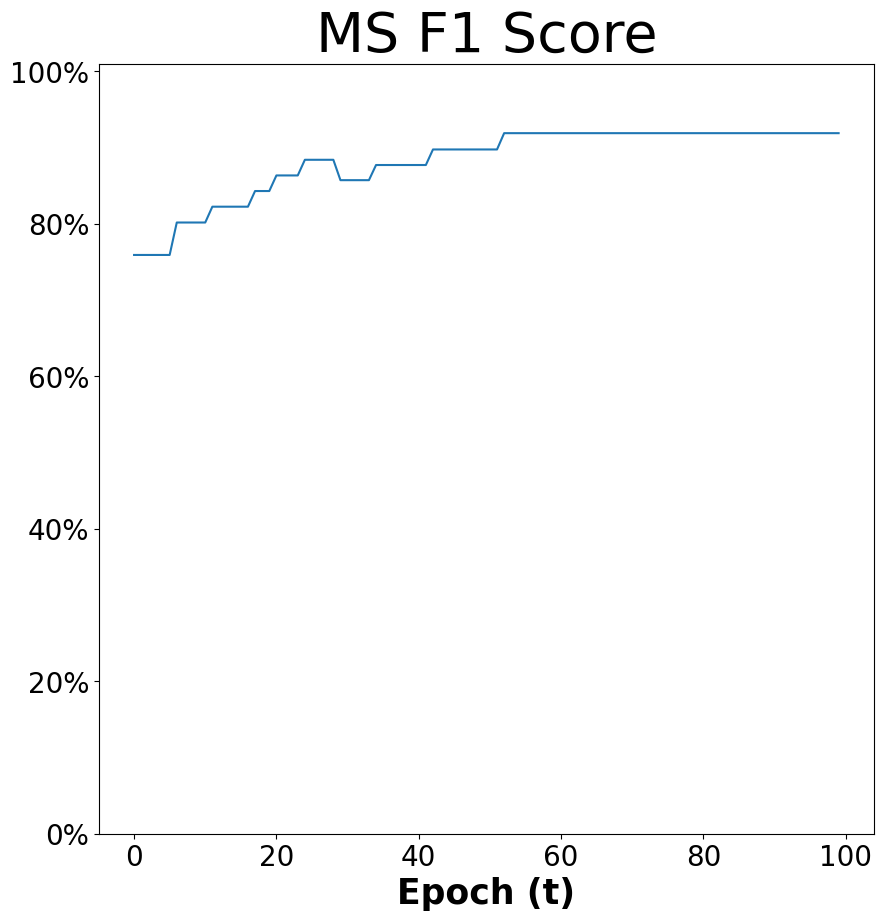

In [71]:
save_figs(ms_glvq_fscore, experiment, "MS", learning_rate)

##### 2-step lr = 0.03

In [72]:
learning_rate = 0.03
ms_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = ms_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.middle_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4395, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 11, Loss: 0.4271, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 21, Loss: 0.4186, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 31, Loss: 0.4119, Accuracy: 75.00 %, F_1_score: 80.17 %
Epoch: 41, Loss: 0.4062, Accuracy: 77.78 %, F_1_score: 82.25 %
Epoch: 51, Loss: 0.4009, Accuracy: 77.78 %, F_1_score: 82.25 %
Epoch: 61, Loss: 0.3964, Accuracy: 80.56 %, F_1_score: 84.30 %
Epoch: 71, Loss: 0.3935, Accuracy: 83.33 %, F_1_score: 86.35 %
Epoch: 81, Loss: 0.3910, Accuracy: 83.33 %, F_1_score: 86.35 %
Epoch: 91, Loss: 0.3890, Accuracy: 86.11 %, F_1_score: 88.40 %


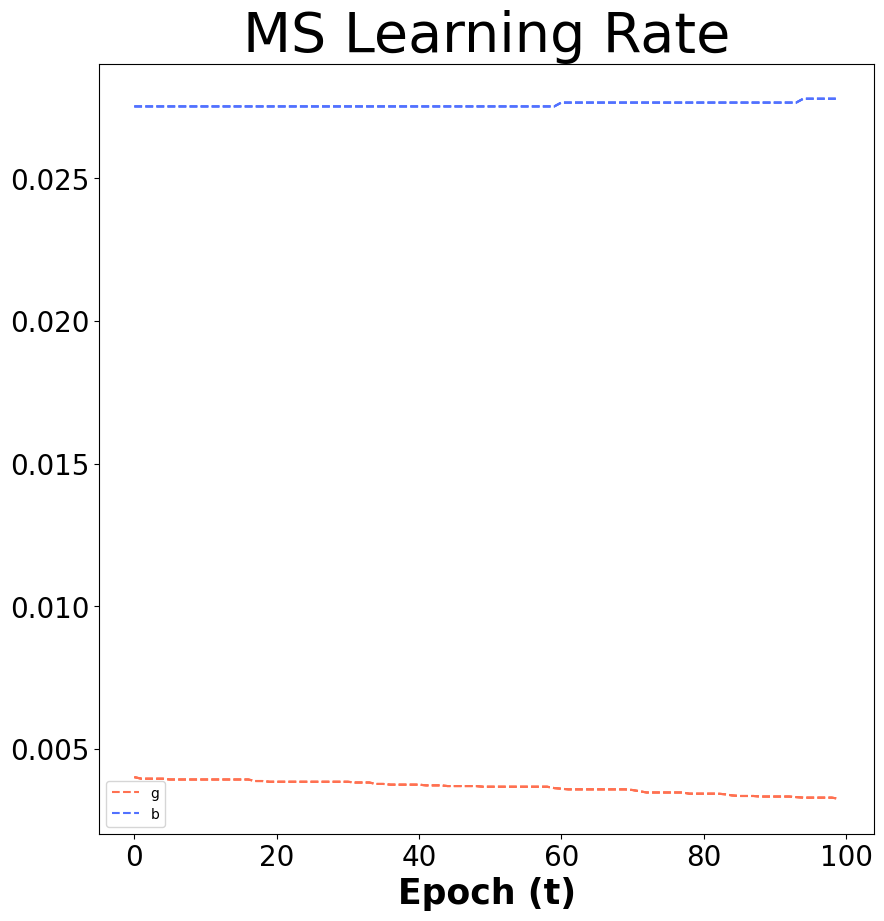

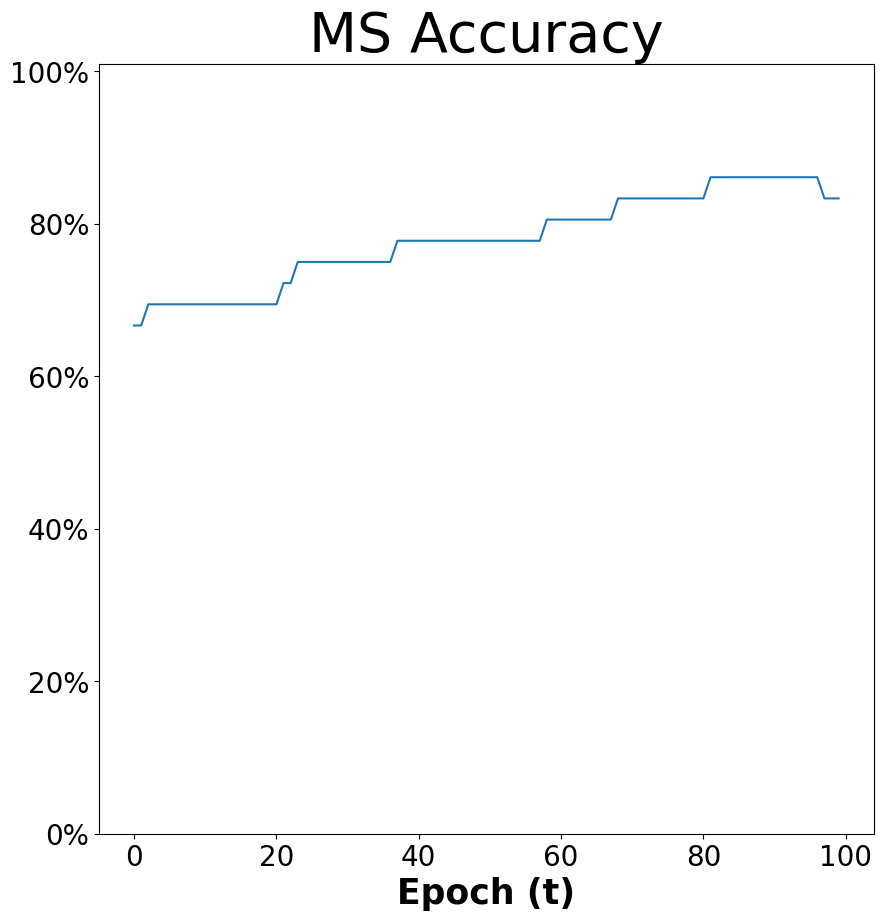

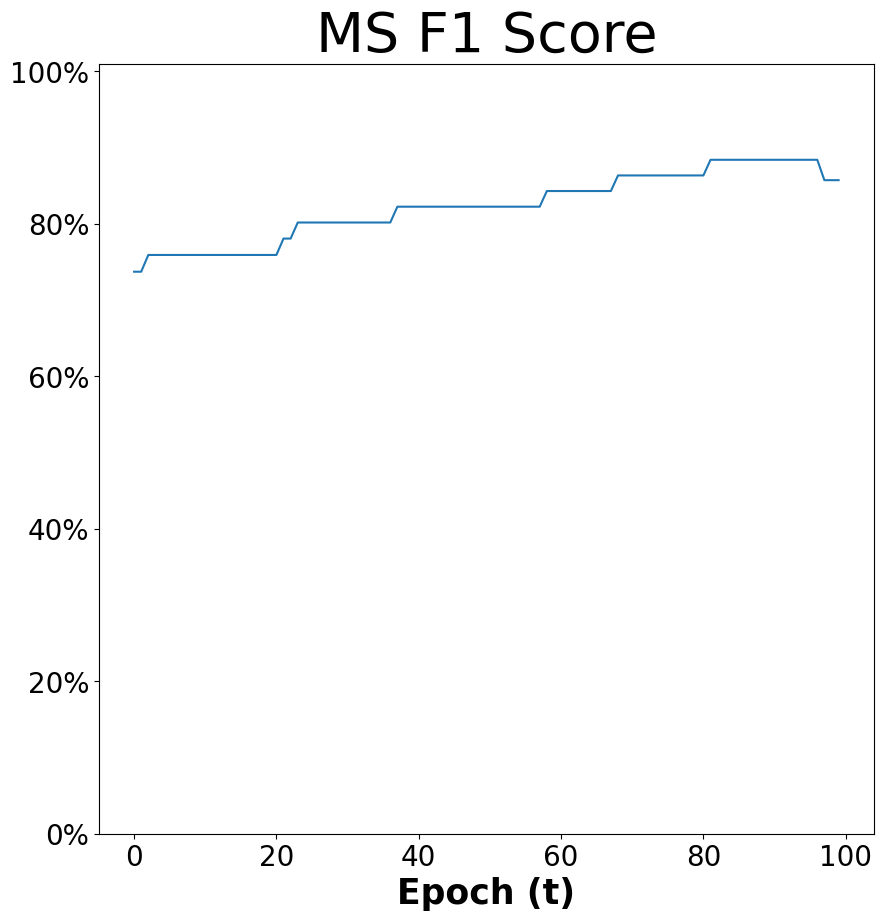

In [73]:
save_figs(ms_glvq_fscore, experiment, "MS", learning_rate)

##### 3-step lr = 0.01

In [74]:
learning_rate = 0.01
ms_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = ms_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.middle_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4402, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 11, Loss: 0.4353, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 21, Loss: 0.4311, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 31, Loss: 0.4275, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 41, Loss: 0.4243, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 51, Loss: 0.4215, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 61, Loss: 0.4189, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 71, Loss: 0.4166, Accuracy: 75.00 %, F_1_score: 80.17 %
Epoch: 81, Loss: 0.4143, Accuracy: 75.00 %, F_1_score: 80.17 %
Epoch: 91, Loss: 0.4122, Accuracy: 75.00 %, F_1_score: 80.17 %


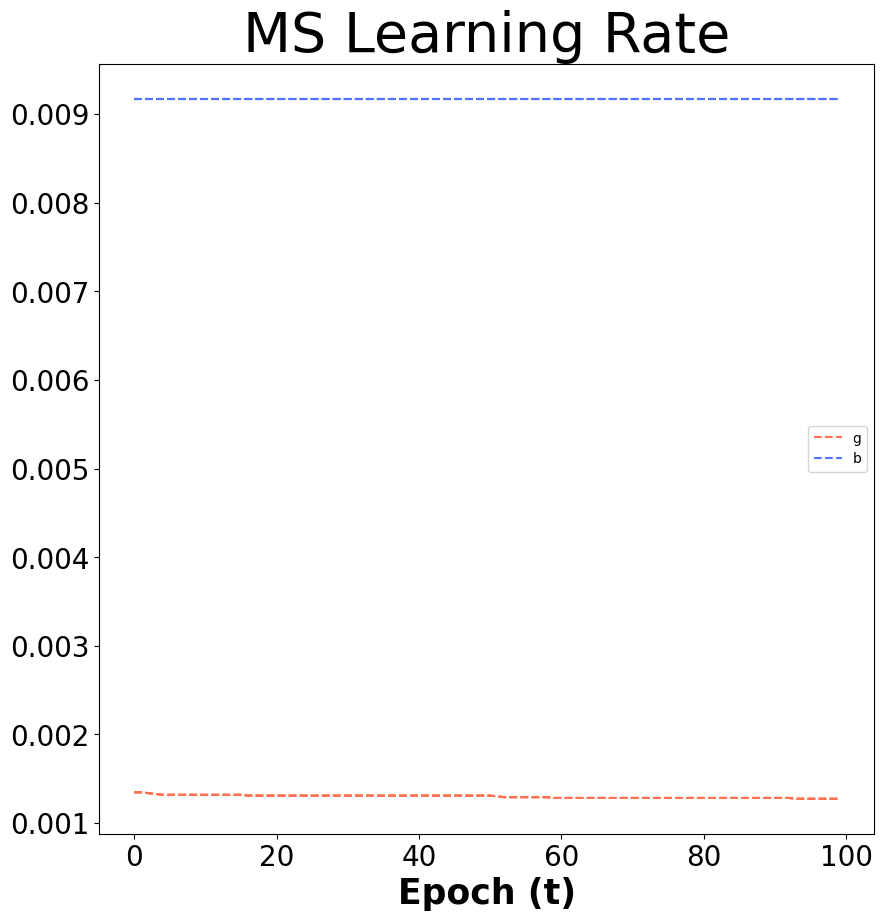

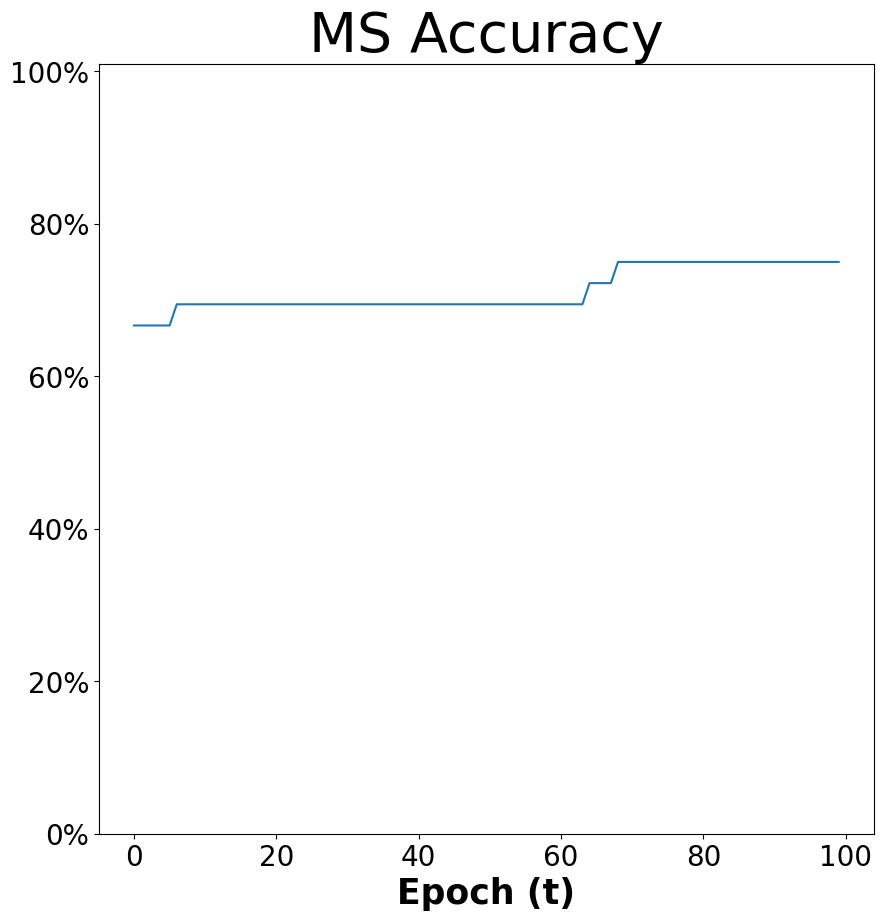

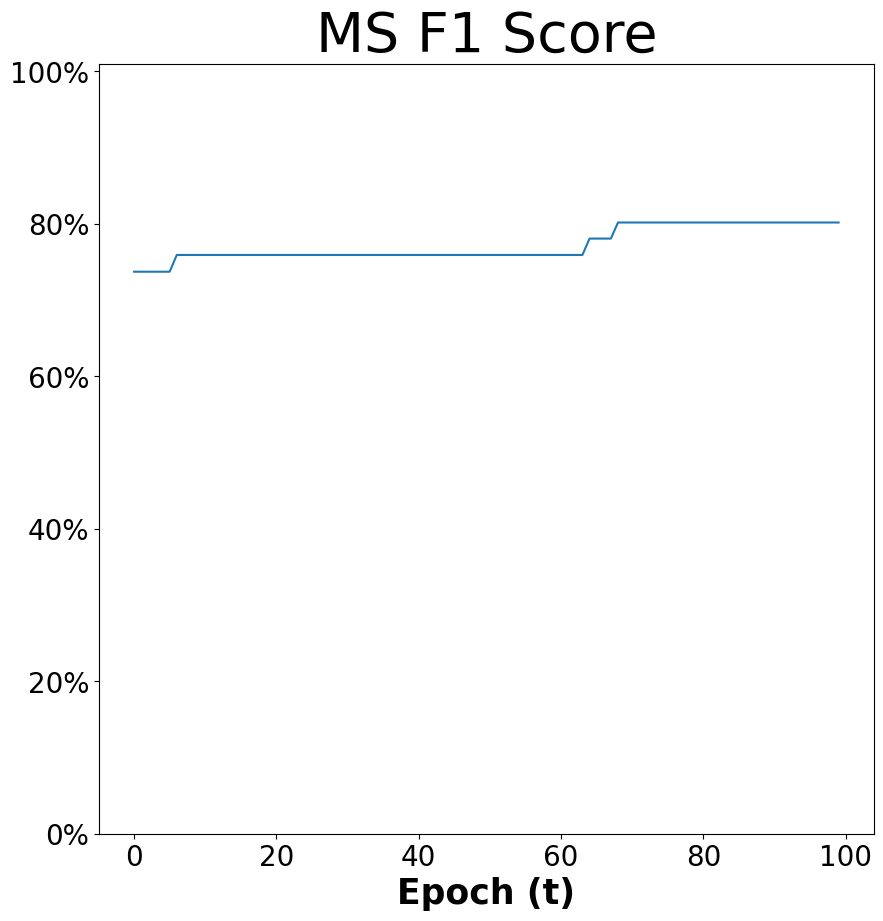

In [75]:
save_figs(ms_glvq_fscore, experiment, "MS", learning_rate)

##### LS

##### 1-step lr = 0.1

In [76]:
learning_rate = 0.1
ls_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = ls_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.loose_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4379, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 11, Loss: 0.4119, Accuracy: 75.00 %, F_1_score: 80.17 %
Epoch: 21, Loss: 0.3968, Accuracy: 80.56 %, F_1_score: 84.30 %
Epoch: 31, Loss: 0.3892, Accuracy: 86.11 %, F_1_score: 88.40 %
Epoch: 41, Loss: 0.3840, Accuracy: 83.33 %, F_1_score: 85.73 %
Epoch: 51, Loss: 0.3798, Accuracy: 88.89 %, F_1_score: 89.75 %
Epoch: 61, Loss: 0.3761, Accuracy: 91.67 %, F_1_score: 91.89 %
Epoch: 71, Loss: 0.3727, Accuracy: 91.67 %, F_1_score: 91.89 %
Epoch: 81, Loss: 0.3696, Accuracy: 91.67 %, F_1_score: 91.89 %
Epoch: 91, Loss: 0.3669, Accuracy: 94.44 %, F_1_score: 94.20 %


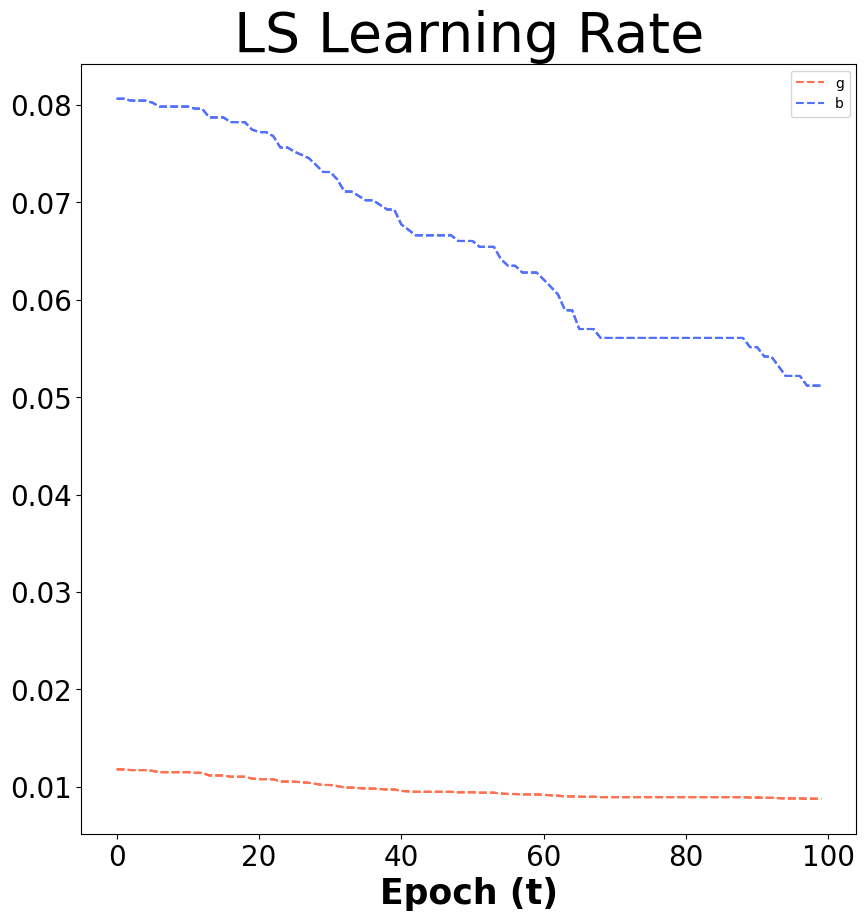

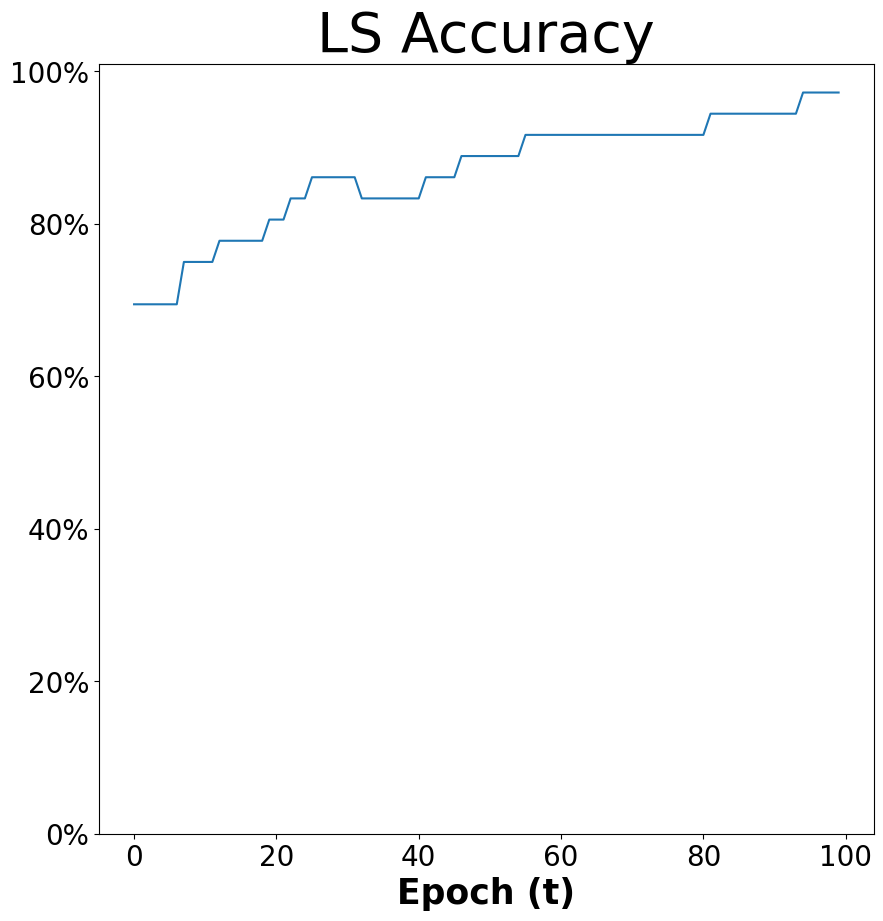

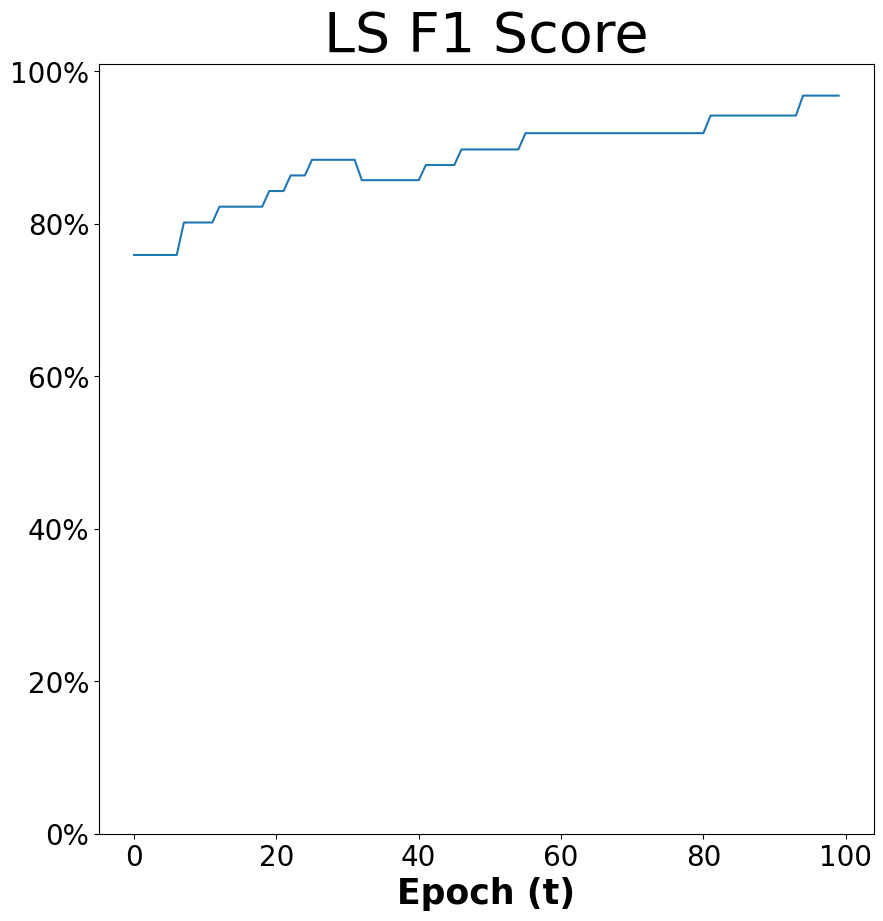

In [77]:
save_figs(ls_glvq_fscore, experiment, "LS", learning_rate)

##### 2-step lr = 0.03

In [78]:
learning_rate = 0.03
ls_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = ls_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.loose_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4397, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 11, Loss: 0.4287, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 21, Loss: 0.4209, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 31, Loss: 0.4146, Accuracy: 75.00 %, F_1_score: 80.17 %
Epoch: 41, Loss: 0.4093, Accuracy: 77.78 %, F_1_score: 82.25 %
Epoch: 51, Loss: 0.4044, Accuracy: 77.78 %, F_1_score: 82.25 %
Epoch: 61, Loss: 0.3999, Accuracy: 77.78 %, F_1_score: 82.25 %
Epoch: 71, Loss: 0.3965, Accuracy: 80.56 %, F_1_score: 84.30 %
Epoch: 81, Loss: 0.3939, Accuracy: 83.33 %, F_1_score: 86.35 %
Epoch: 91, Loss: 0.3917, Accuracy: 86.11 %, F_1_score: 88.40 %


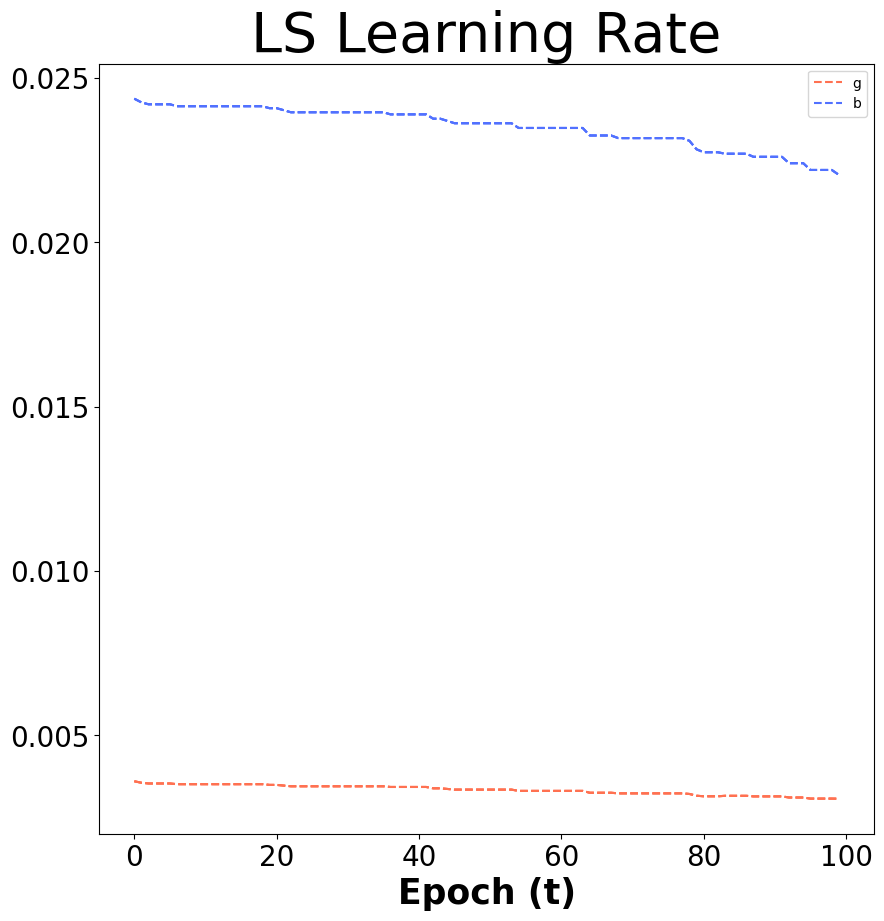

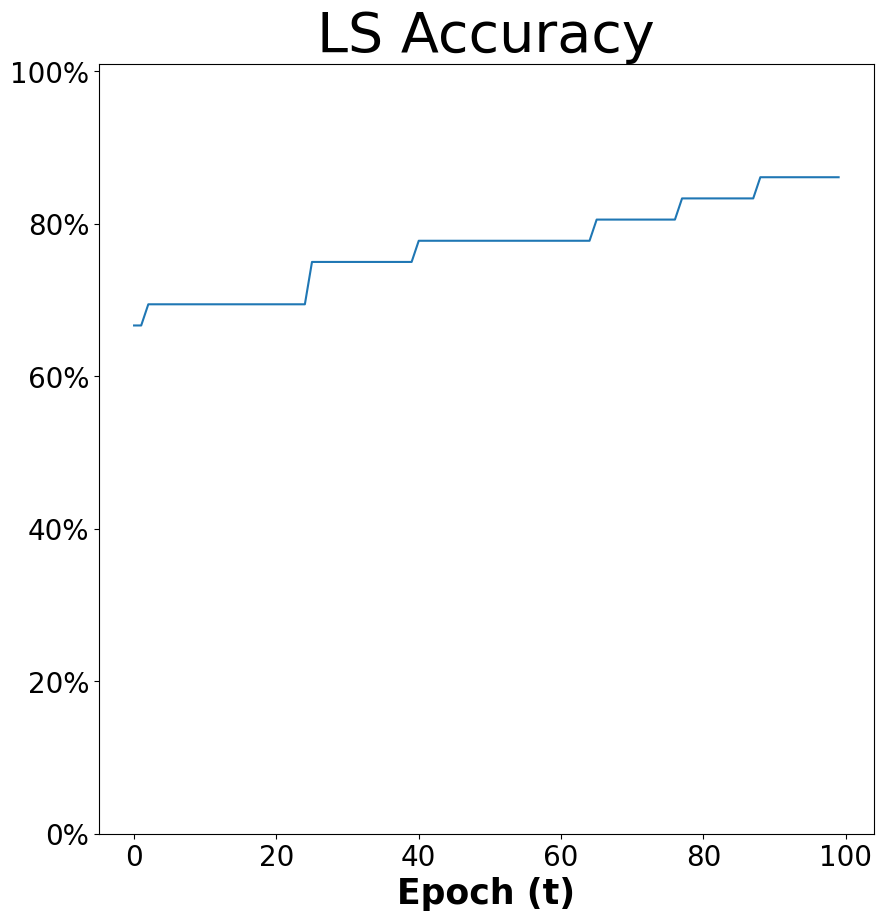

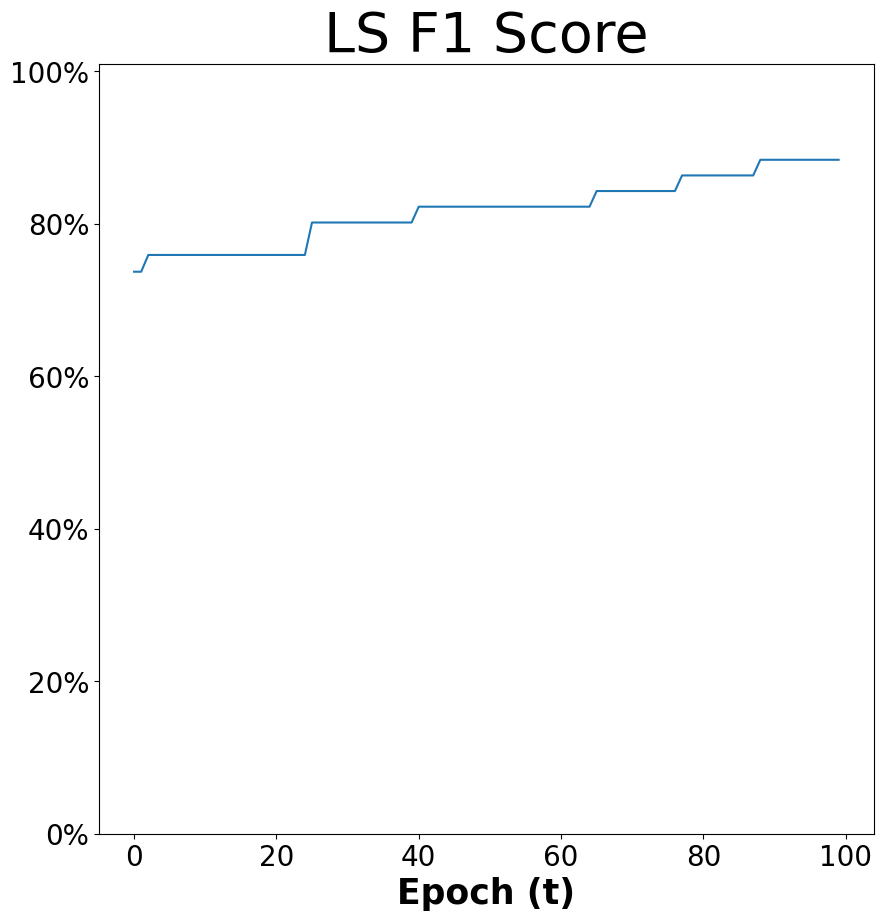

In [79]:
save_figs(ls_glvq_fscore, experiment, "LS", learning_rate)

##### 3-step lr = 0.01

In [80]:
learning_rate = 0.01
ls_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = ls_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.loose_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4403, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 11, Loss: 0.4360, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 21, Loss: 0.4323, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 31, Loss: 0.4291, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 41, Loss: 0.4262, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 51, Loss: 0.4236, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 61, Loss: 0.4212, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 71, Loss: 0.4189, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 81, Loss: 0.4169, Accuracy: 75.00 %, F_1_score: 80.17 %
Epoch: 91, Loss: 0.4149, Accuracy: 75.00 %, F_1_score: 80.17 %


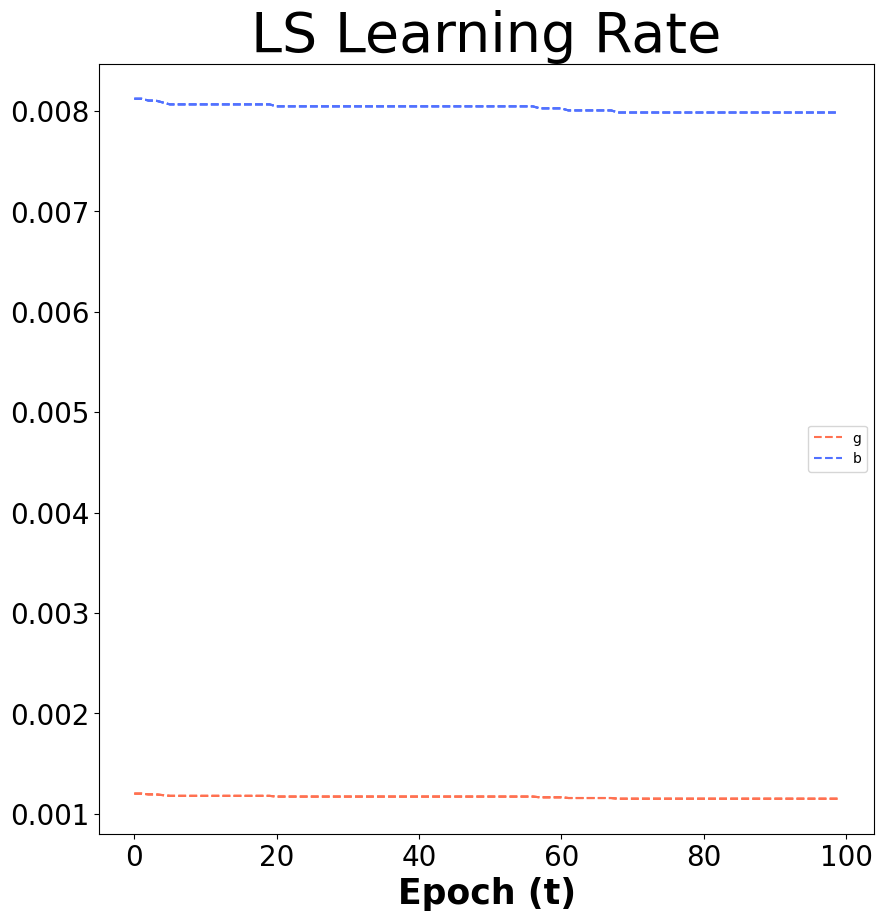

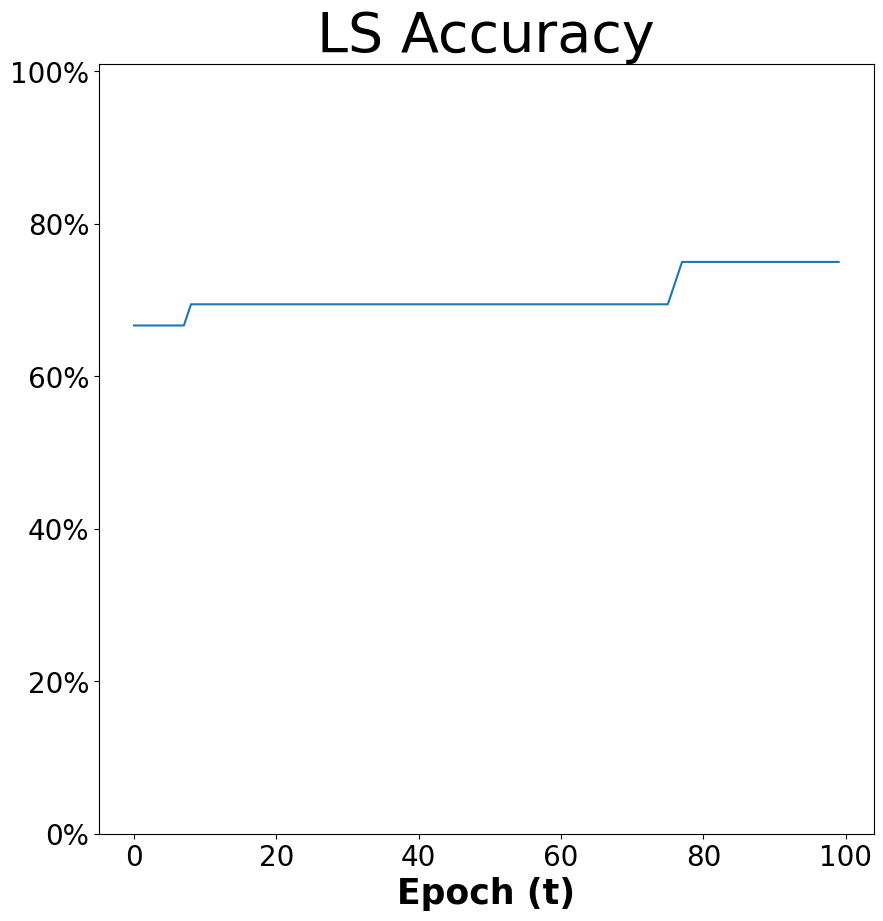

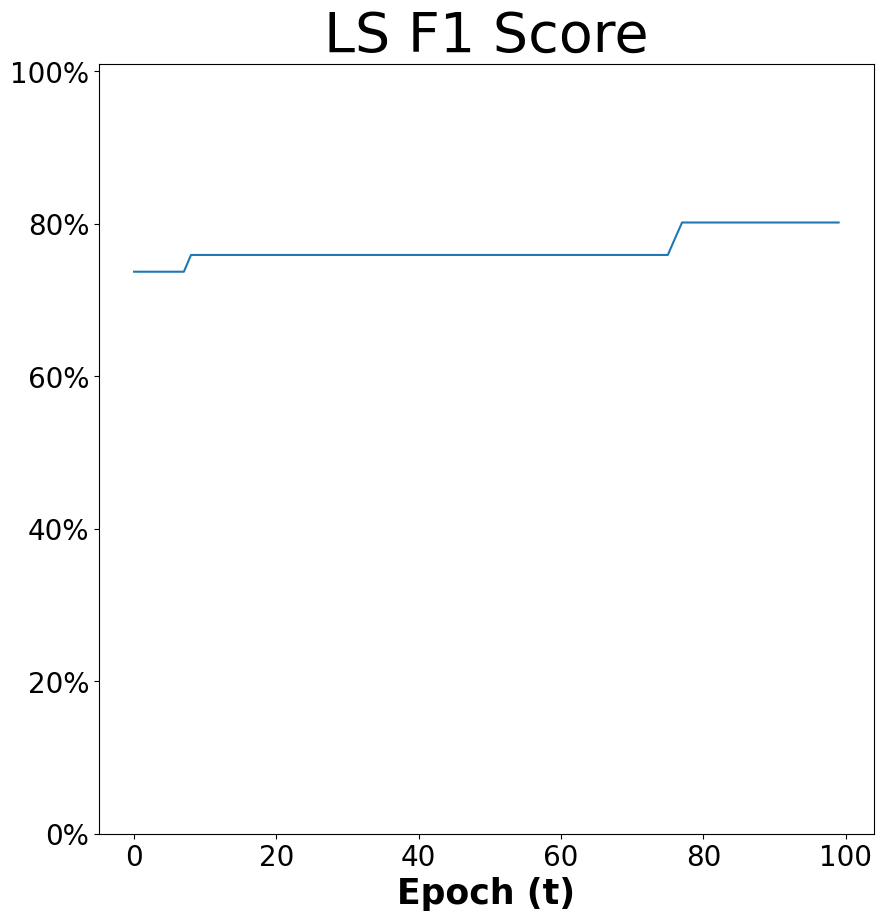

In [81]:
save_figs(ls_glvq_fscore, experiment, "LS", learning_rate)

##### LSR

##### 1-step lr = 0.1

In [82]:
learning_rate = 0.1
lsr_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = lsr_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.loose_symmetry_rarity,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4378, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 11, Loss: 0.4097, Accuracy: 77.78 %, F_1_score: 82.25 %
Epoch: 21, Loss: 0.3943, Accuracy: 86.11 %, F_1_score: 88.40 %
Epoch: 31, Loss: 0.3860, Accuracy: 83.33 %, F_1_score: 85.73 %
Epoch: 41, Loss: 0.3801, Accuracy: 88.89 %, F_1_score: 89.75 %
Epoch: 51, Loss: 0.3754, Accuracy: 94.44 %, F_1_score: 94.20 %
Epoch: 61, Loss: 0.3716, Accuracy: 94.44 %, F_1_score: 94.20 %
Epoch: 71, Loss: 0.3684, Accuracy: 94.44 %, F_1_score: 94.20 %
Epoch: 81, Loss: 0.3655, Accuracy: 94.44 %, F_1_score: 94.20 %
Epoch: 91, Loss: 0.3629, Accuracy: 97.22 %, F_1_score: 96.82 %


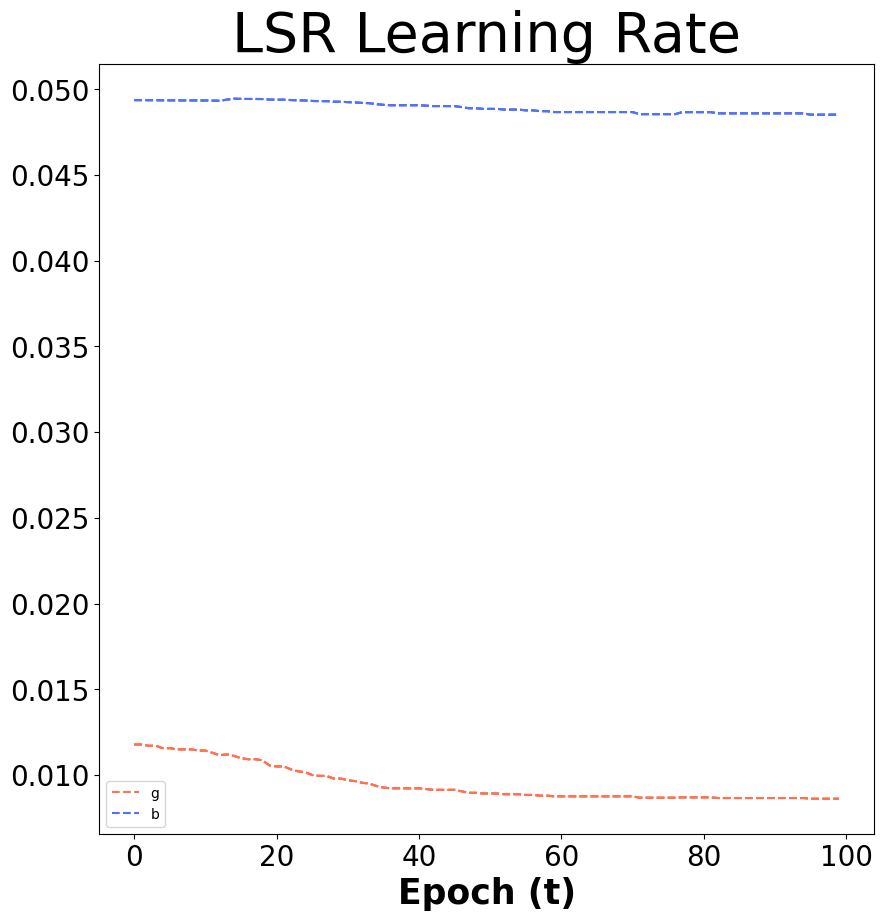

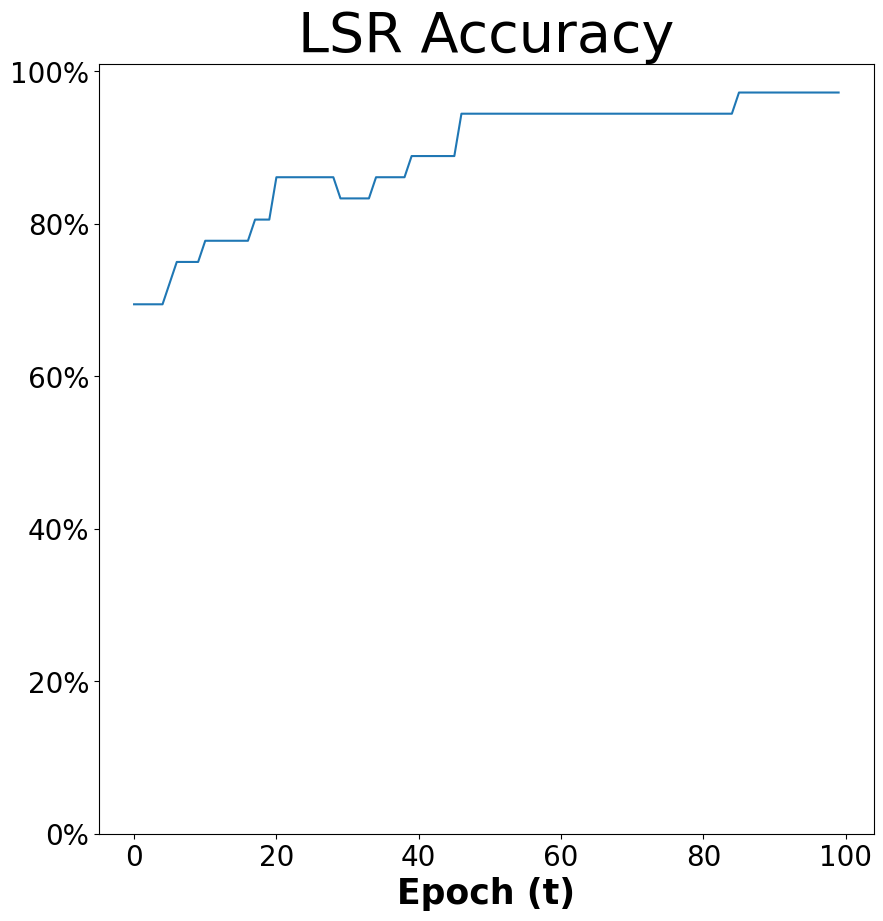

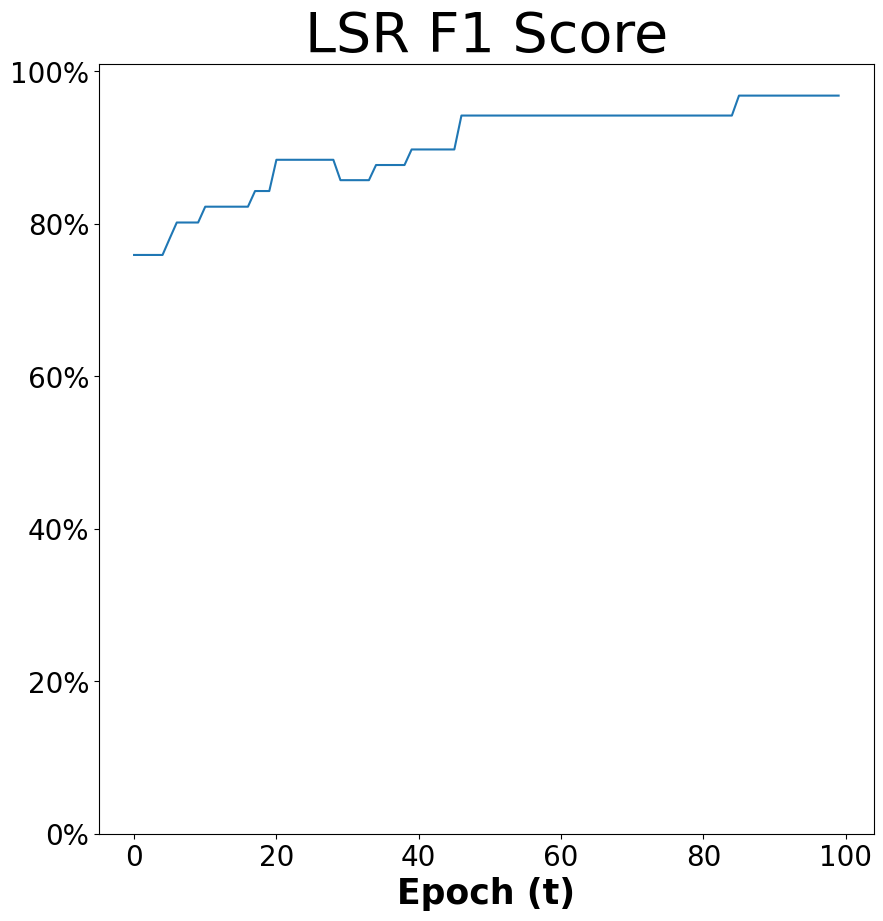

In [83]:
save_figs(lsr_glvq_fscore, experiment, "LSR", learning_rate)

##### 2-step lr = 0.03

In [84]:
learning_rate = 0.03
lsr_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = lsr_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.loose_symmetry_rarity,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4397, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 11, Loss: 0.4279, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 21, Loss: 0.4194, Accuracy: 72.22 %, F_1_score: 78.06 %
Epoch: 31, Loss: 0.4126, Accuracy: 75.00 %, F_1_score: 80.17 %
Epoch: 41, Loss: 0.4067, Accuracy: 77.78 %, F_1_score: 82.25 %
Epoch: 51, Loss: 0.4011, Accuracy: 77.78 %, F_1_score: 82.25 %
Epoch: 61, Loss: 0.3971, Accuracy: 80.56 %, F_1_score: 84.30 %
Epoch: 71, Loss: 0.3938, Accuracy: 86.11 %, F_1_score: 88.40 %
Epoch: 81, Loss: 0.3910, Accuracy: 86.11 %, F_1_score: 88.40 %
Epoch: 91, Loss: 0.3885, Accuracy: 86.11 %, F_1_score: 88.40 %


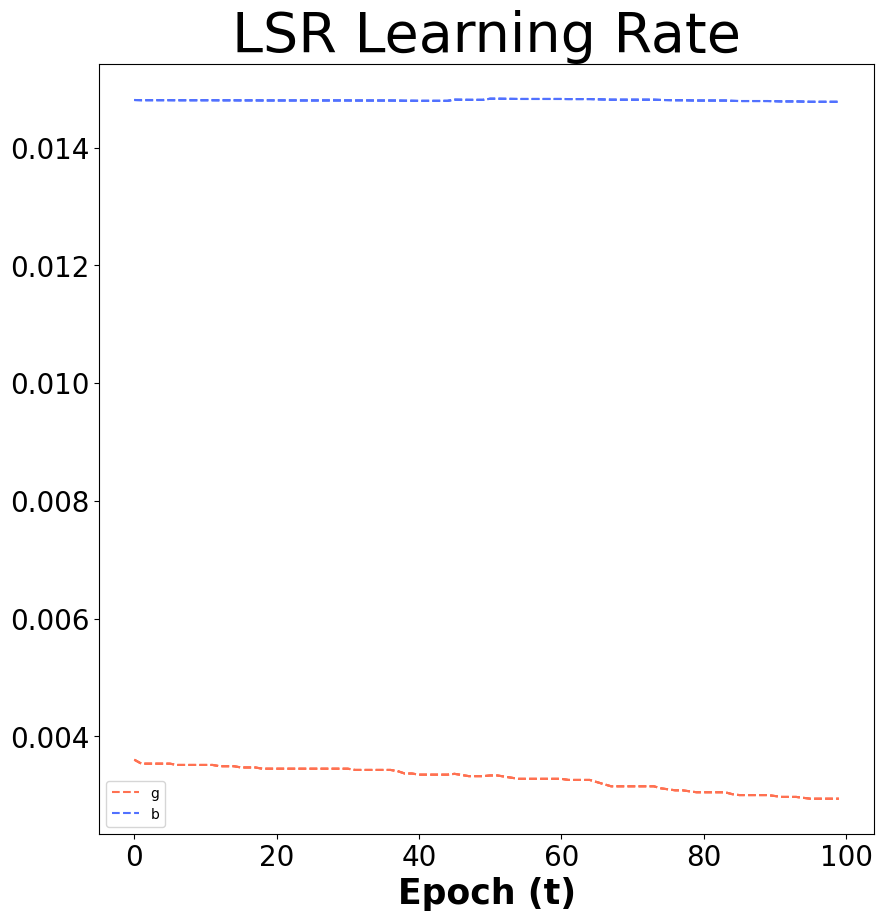

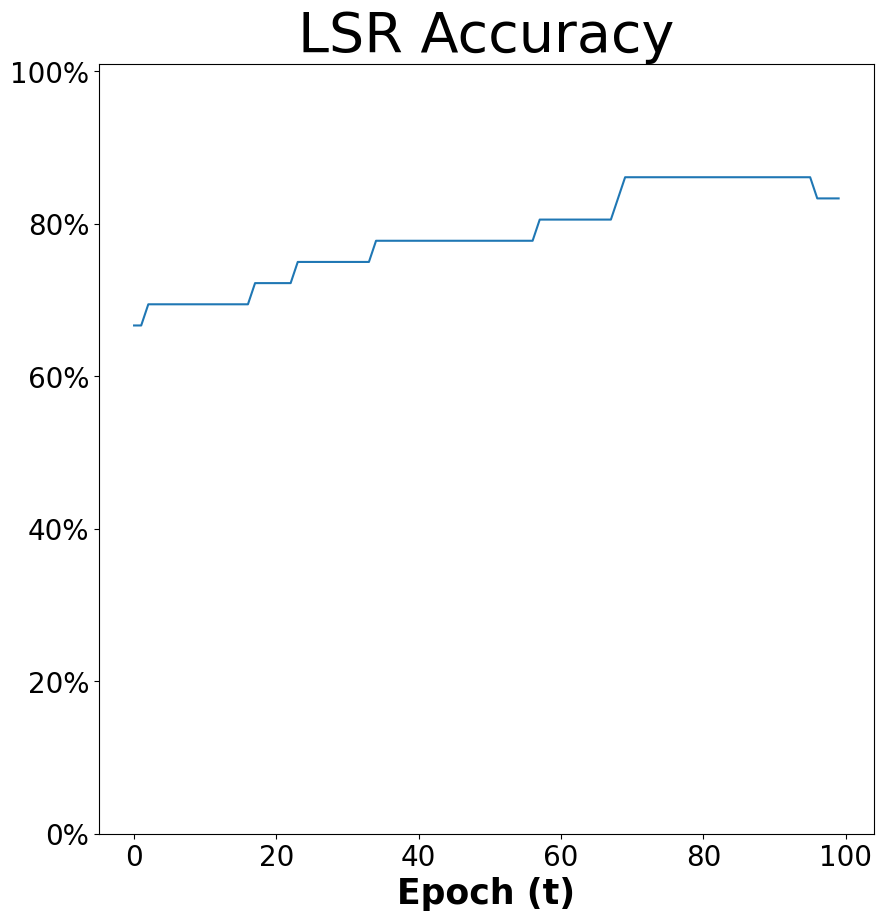

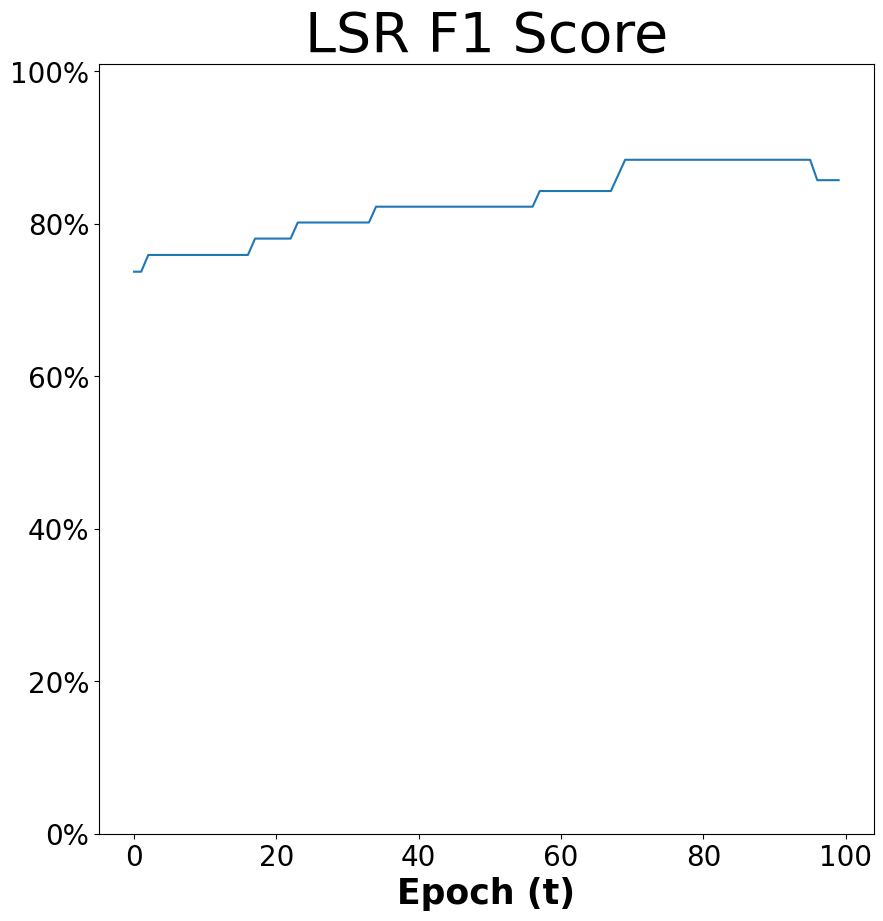

In [85]:
save_figs(lsr_glvq_fscore, experiment, "LSR", learning_rate)

##### 3-step lr = 0.01

In [86]:
learning_rate = 0.01
lsr_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = lsr_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.loose_symmetry_rarity,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4403, Accuracy: 66.67 %, F_1_score: 73.72 %
Epoch: 11, Loss: 0.4357, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 21, Loss: 0.4318, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 31, Loss: 0.4283, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 41, Loss: 0.4252, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 51, Loss: 0.4224, Accuracy: 69.44 %, F_1_score: 75.92 %
Epoch: 61, Loss: 0.4197, Accuracy: 72.22 %, F_1_score: 78.06 %
Epoch: 71, Loss: 0.4173, Accuracy: 75.00 %, F_1_score: 80.17 %
Epoch: 81, Loss: 0.4151, Accuracy: 75.00 %, F_1_score: 80.17 %
Epoch: 91, Loss: 0.4129, Accuracy: 75.00 %, F_1_score: 80.17 %


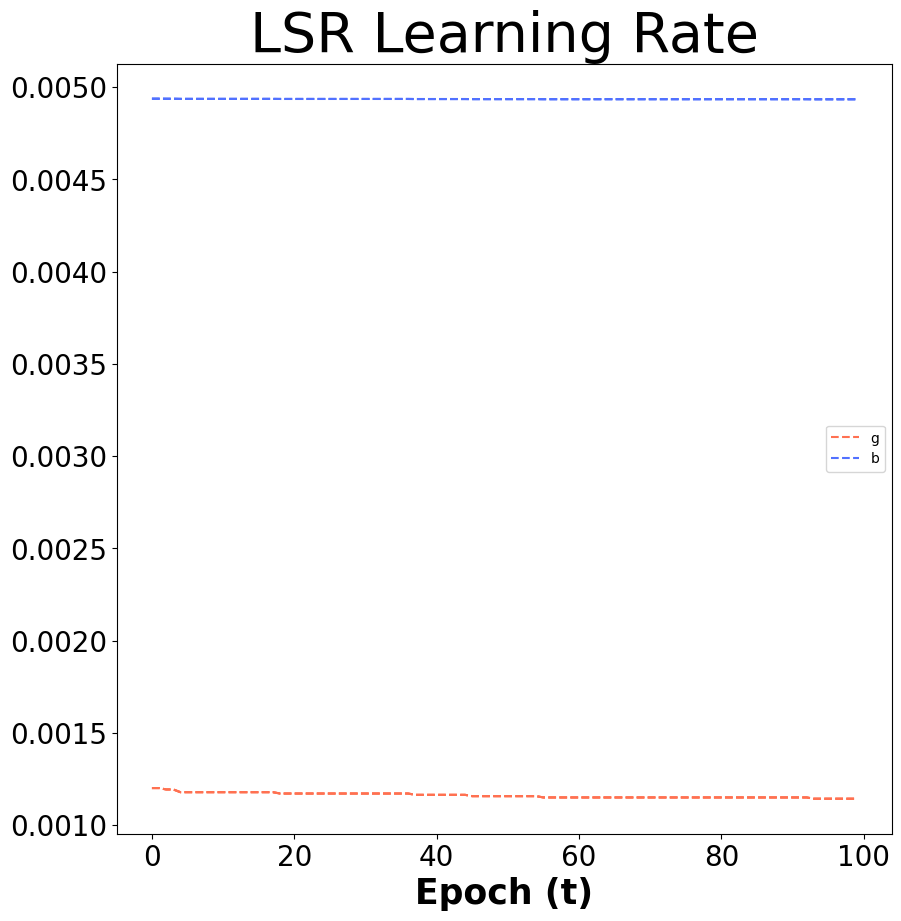

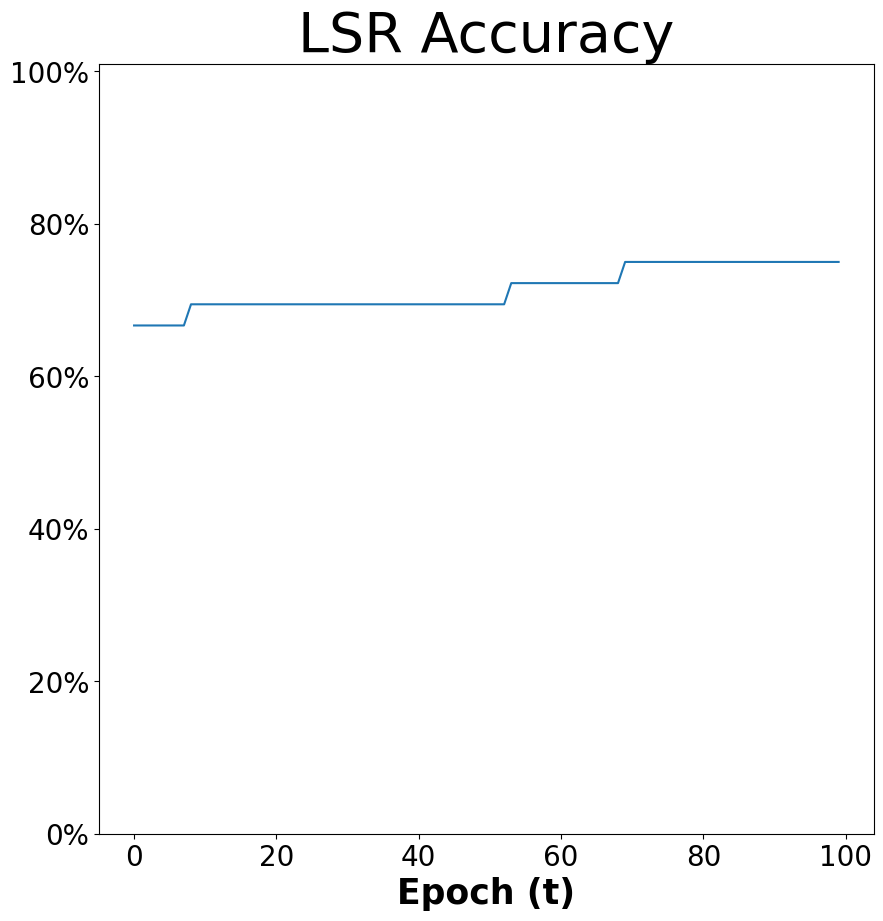

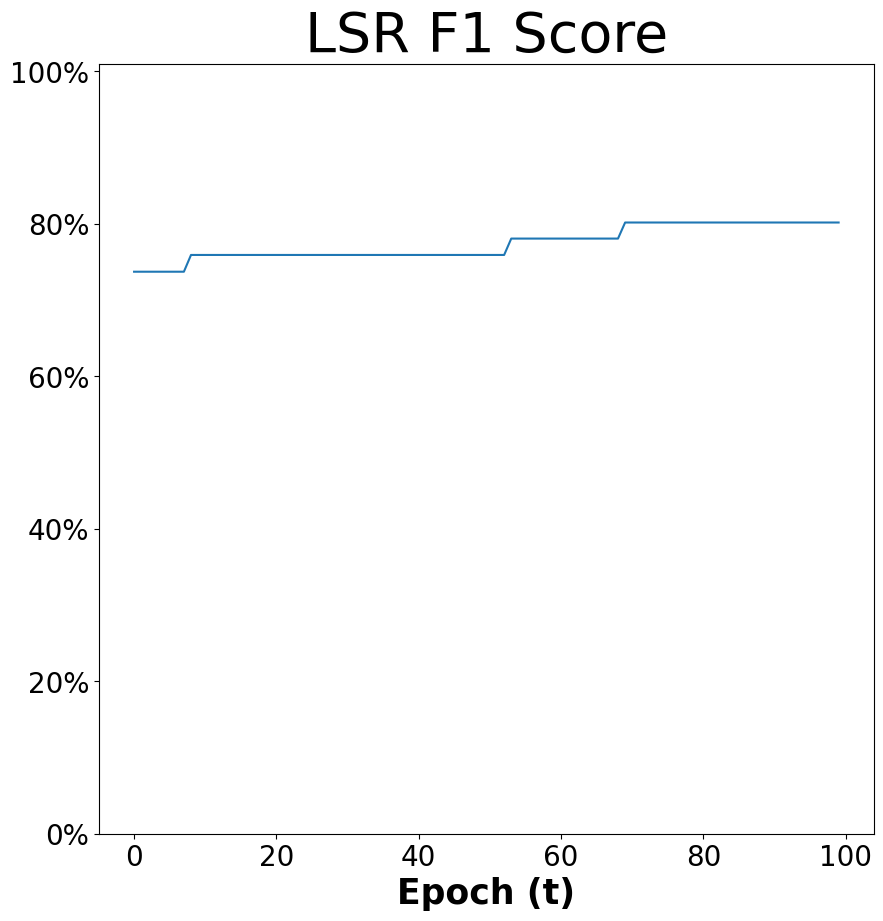

In [87]:
save_figs(lsr_glvq_fscore, experiment, "LSR", learning_rate)